In [3]:
# camera calibration
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

#read in all images
images = glob.glob('camera_cal/calibration*.jpg')


objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


for fname in images:
    #read in each image
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
 


In [4]:
#load in one image to get the shape
img = mpimg.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) #just to get the shape
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

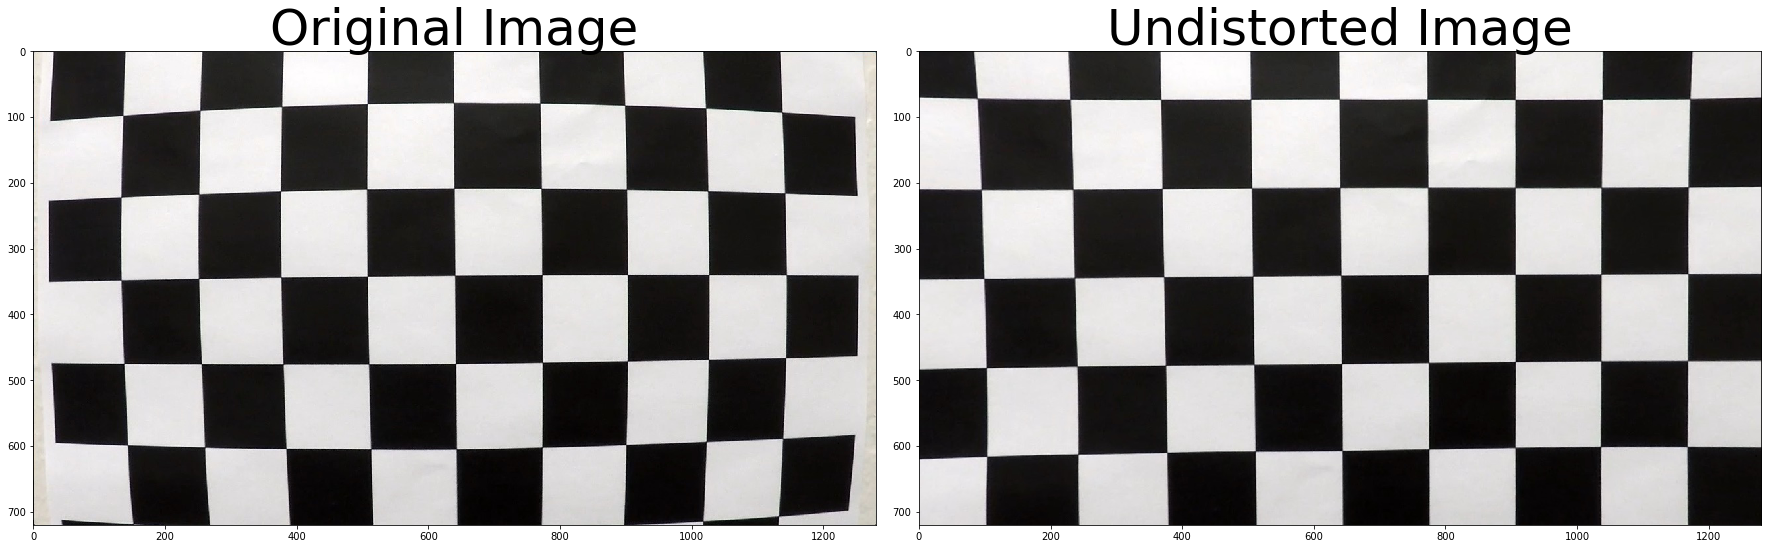

In [5]:
#show one example

dst = cv2.undistort(img, mtx, dist, None, mtx)
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

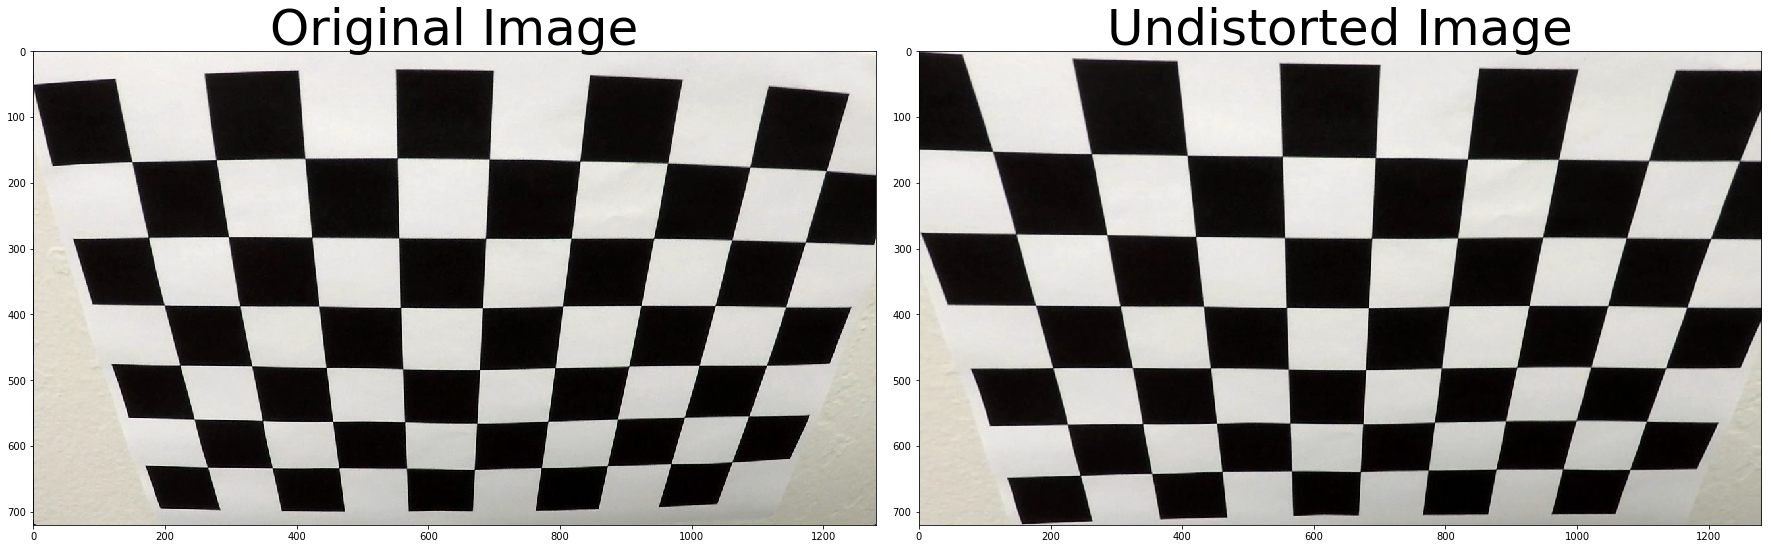

In [6]:
#show another example
img2 = mpimg.imread('camera_cal/calibration2.jpg')
dst2 = cv2.undistort(img2, mtx, dist, None, mtx)
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst2)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
#save the calibration result 
import pickle
camera_calib_dict = {}
camera_calib_dict['mtx'] = mtx
camera_calib_dict['dist'] = dist
camera_calib_dict['rvecs'] = rvecs
camera_calib_dict['tvecs'] = tvecs
with open('calibration.p','wb') as f:
    pickle.dump(camera_calib_dict, f)
f.close()
    

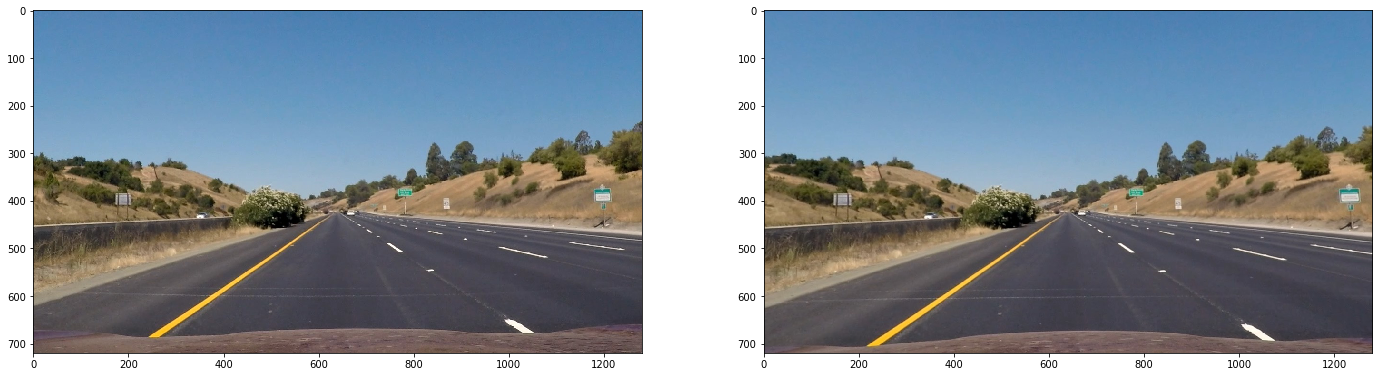

In [134]:
# undistort an image
def undistort(img, mtx, dist):
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image
test_image = mpimg.imread('test_images/straight_lines1.jpg')
dst_test = undistort(test_image, mtx, dist)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(test_image)
ax2.imshow(dst_test)

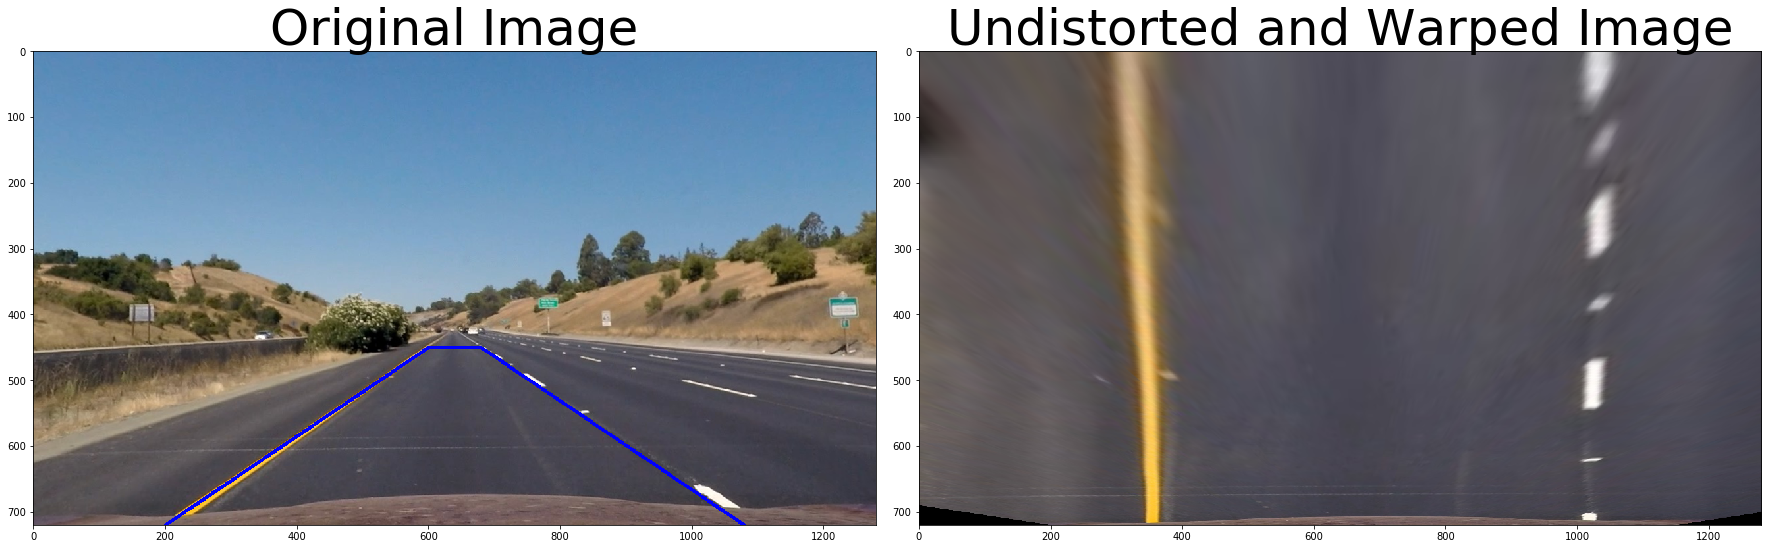

In [146]:
#perspective transform 
def calculate_perspective_transform(img):
    """apply perspective transform"""
    src = np.float32([[600,450],[680,450], [1080, img.shape[0]], [200, img.shape[0]]])
    src = src.reshape((-1,1,2))
    dst = np.float32([[350,0],[1000,0],[1000, img.shape[0]],[350, img.shape[0]]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def apply_perspective_transform(img, M):
    img_size = (img.shape[1], img.shape[0])
    img_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return img_warped

from copy import deepcopy
dst_test_w_anchor_points = deepcopy(dst_test)
dst_test_overlay = cv2.line(dst_test_w_anchor_points,(600,450),(680,450),(0,0,255),3)
dst_test_overlay = cv2.line(dst_test_w_anchor_points,(680,450),(1080,img_size[1]),(0,0,255),3)
dst_test_overlay = cv2.line(dst_test_w_anchor_points,(600,450),(200,img_size[1]),(0,0,255),3)

M, Minv = calculate_perspective_transform(dst_test_w_anchor_points)
dst_test_warped = apply_perspective_transform(dst_test, M)

%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst_test_overlay)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst_test_warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

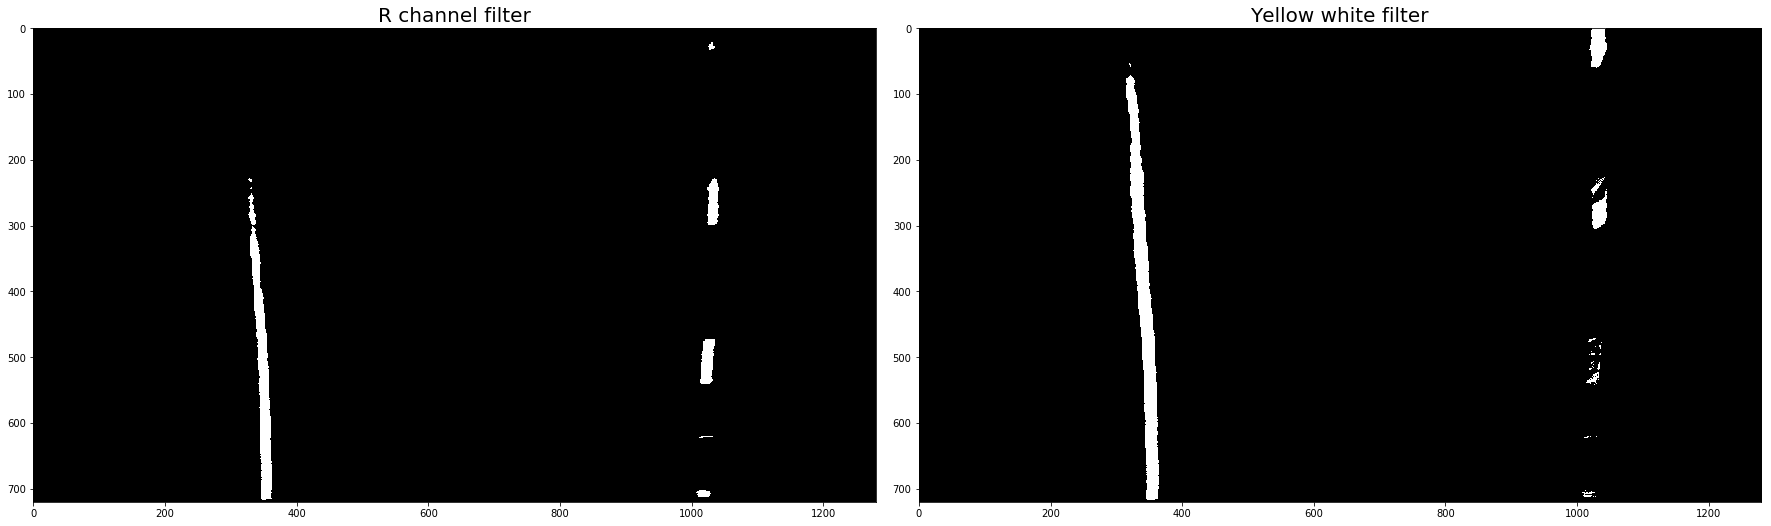

In [93]:
## try different thresholding technique to detect the lane

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelmag = np.sqrt(np.sum([np.square(sobelx), np.square(sobely)], axis=0 ))
    scaled_sobel = np.uint8(255*sobelmag/np.max(sobelmag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel_angle = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(sobel_angle)
    dir_binary[(sobel_angle >= thresh[0]) & (sobel_angle <= thresh[1])] = 1
    return dir_binary

def r_select(img, thresh=(200, 255)):
    R = img[:,:,0]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

def color_mask(hsv,low,high):
    """Return color mask from HSV image"""
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    """Apply color mask to HSV image"""
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def apply_yellow_white_mask(img, yellow_hsv_low=np.array([ 0, 80, 200]), yellow_hsv_high=np.array([ 40, 255, 255]),
                            white_hsv_low=np.array([  20,   0,   200]), white_hsv_high=np.array([ 255,  80, 255])):
    """Apply yellow white mask to HSV image"""
    image_HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_YW_image = cv2.bitwise_or(mask_yellow,mask_white)
    return mask_YW_image


#choose threshold
yellow_hsv_low  = np.array([ 0, 80, 200])
yellow_hsv_high = np.array([ 40, 255, 255])
white_hsv_low  = np.array([  20,   0,   200])
white_hsv_high = np.array([ 255,  80, 255])

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
dst_test_warped = cv2.warpPerspective(dst_test, M, img_size, flags=cv2.INTER_LINEAR)

#plot lane detected using R supressing and yellow&white mask
r_binary = r_select(dst_test_warped, thresh=(220, 255))
yw_binary = apply_yellow_white_mask(dst_test_warped, yellow_hsv_low, yellow_hsv_high, white_hsv_low, white_hsv_high)

#plot lane detected using R supressing and yellow&white mask
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(r_binary, cmap='gray')
ax1.set_title('R channel filter', fontsize=20)
ax2.imshow(yw_binary, cmap='gray')
ax2.set_title('Yellow white filter', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)





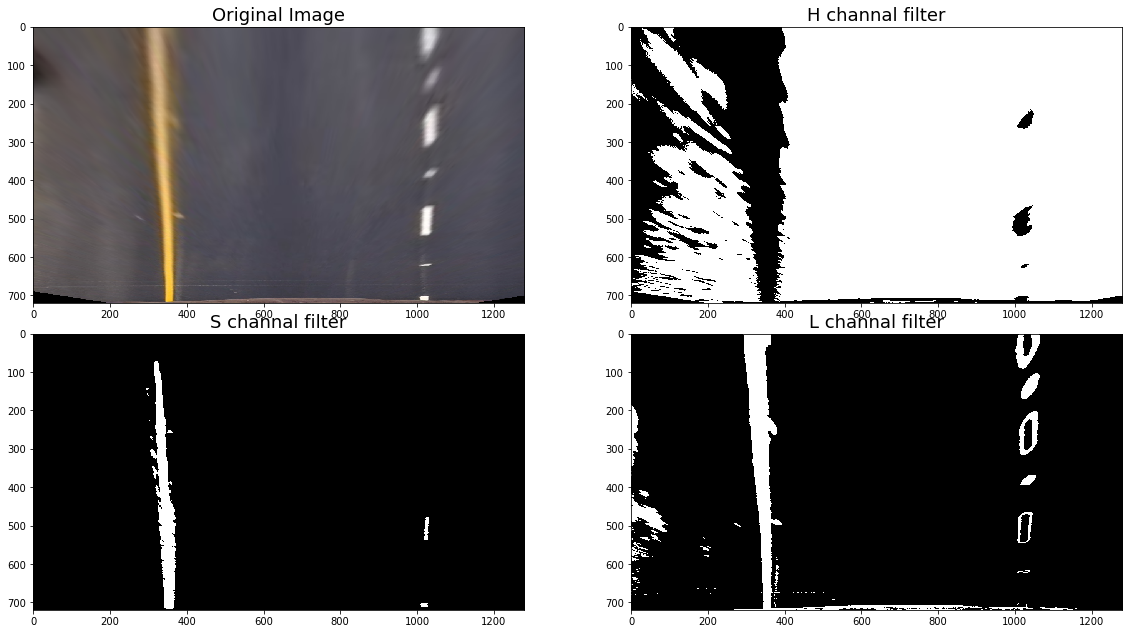

In [61]:
# try HLS color space
def hls_select(img, channel='S', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'S':
        channel_img = hls[:,:,2]
    elif channel == 'H':
        channel_img = hls[:,:,0]
    elif channel == 'L':
        channel_img = hls[:,:,1]
    else:
        raise Exception('Ilegal channel')
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh[0]) & (channel_img <= thresh[1])] = 1
    return binary_output
l_binary = hls_select(dst_test_warped, channel='L', thresh=(100, 200))
s_binary = hls_select(dst_test_warped, channel='S', thresh=(100, 255))
h_binary = hls_select(dst_test_warped, channel='H', thresh=(100, 255))
%matplotlib inline
f, axs = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()
axs[0, 0].imshow(dst_test_warped)
axs[0, 0].set_title('Original Image', fontsize=18)
axs[0, 1].imshow(h_binary, cmap='gray')
axs[0, 1].set_title('H channal filter', fontsize=18)
axs[1, 0].imshow(s_binary, cmap='gray')
axs[1, 0].set_title('S channal filter', fontsize=18)
axs[1, 1].imshow(l_binary, cmap='gray')
axs[1, 1].set_title('L channal filter', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



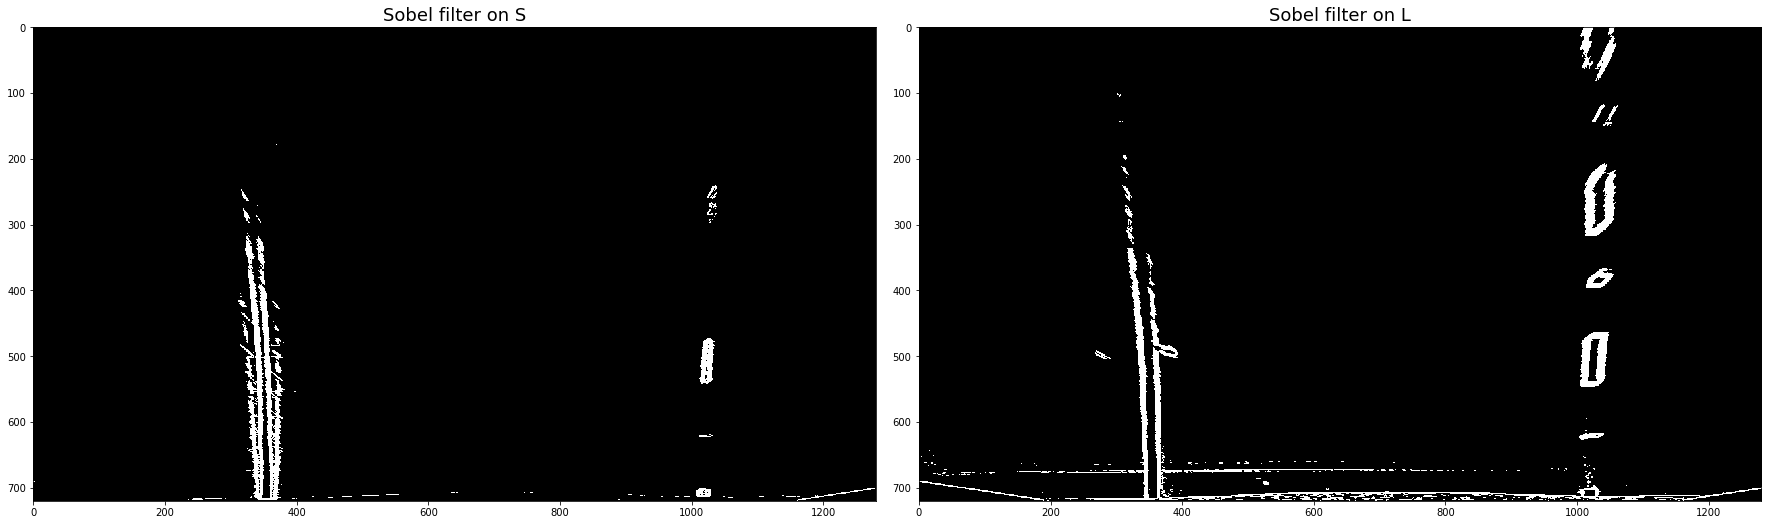

In [91]:
def apply_sobel_filter_on_hls(img, channel='S', sobel_kernel=3, mag_thresh=(0, 255)):
    """apply sobel filter on L and S channel"""
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'S':
        channel_img = hls[:,:,2]
    elif channel == 'L':
        channel_img = hls[:,:,1]
    else:
        raise Exception('Ilegal channel')
    channel_mag_binary = mag_threshold(channel_img, sobel_kernel=sobel_kernel, mag_thresh=mag_thresh)
    return channel_mag_binary


sobel_on_s_binary = apply_sobel_filter_on_hls(dst_test_warped, mag_thresh= (15,255))
sobel_on_l_binary = apply_sobel_filter_on_hls(dst_test_warped, channel='L', mag_thresh= (15,255))

%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sobel_on_s_binary, cmap='gray')
ax1.set_title('Sobel filter on S', fontsize=18)
ax2.imshow(sobel_on_l_binary, cmap='gray')
ax2.set_title('Sobel filter on L', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

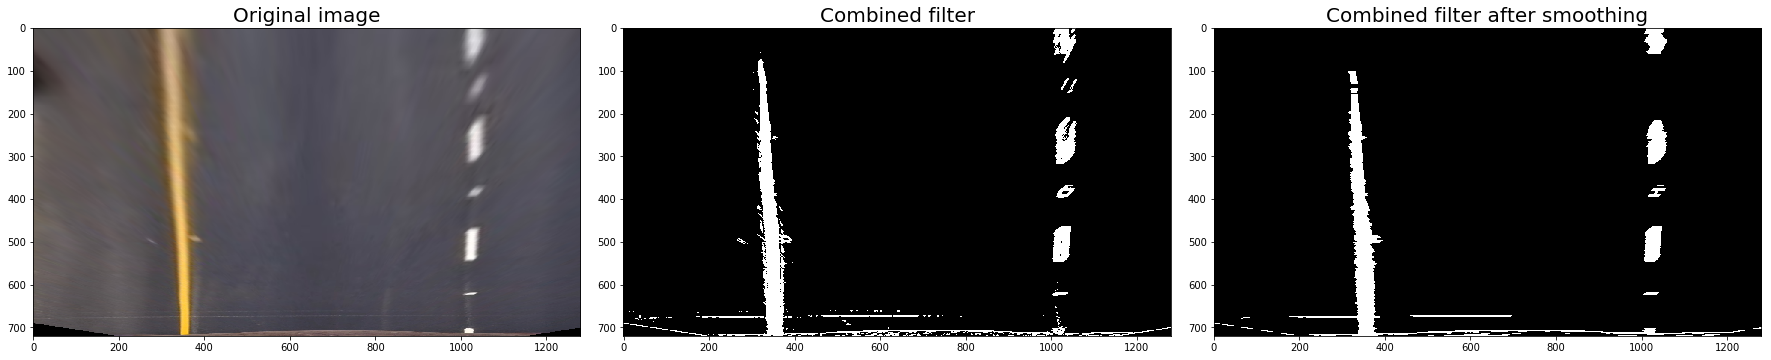

In [111]:
#combine different filters
def combine_filters(wrap_img):
    sobel_on_s_binary = apply_sobel_filter_on_hls(wrap_img, mag_thresh= (15,255))
    sobel_on_l_binary = apply_sobel_filter_on_hls(wrap_img, channel='L', mag_thresh= (15,255))
    l_binary = hls_select(wrap_img, channel='L', thresh=(100, 200))
    s_binary = hls_select(wrap_img, channel='S', thresh=(100, 255))
    yw_binary = apply_yellow_white_mask(wrap_img)
    yw_binary[(yw_binary !=0)] = 1
    combined_lsx = np.zeros_like(sobel_on_s_binary)
    combined_lsx[((l_binary == 1) & (s_binary == 1) | (sobel_on_s_binary == 1) |(sobel_on_l_binary == 1)| (yw_binary == 1))] = 1
    return combined_lsx

def apply_smoothing(img, window_size=30, threshold=0.05):
    """apply smoothing in x direction and apply threshold"""
    kernel = np.ones((1, window_size), np.float32) / window_size
    dst = cv2.filter2D(img, -1, kernel)
    img_lane = np.zeros_like(dst)
    img_lane[dst>=threshold] = 1
    return img_lane

combined_binary = combine_filters(dst_test_warped)
combined_binary_smoothed = apply_smoothing(combined_binary)

%matplotlib inline
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst_test_warped)
ax1.set_title('Original image', fontsize=20)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined filter', fontsize=20)
ax3.imshow(combined_binary_smoothed, cmap='gray')
ax3.set_title('Combined filter after smoothing', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [114]:
#find left lane and right lane and offset (pixel)
def find_line_fit_and_car_offset(img, nwindows=9, margin=100, minpix=50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    offset = 1/2*(leftx_base + rightx_base) - midpoint
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # to plot
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, out_img, offset


44.0


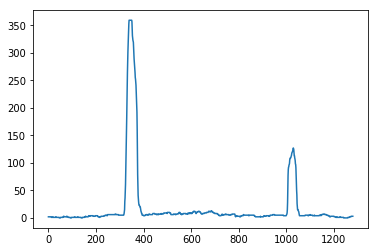

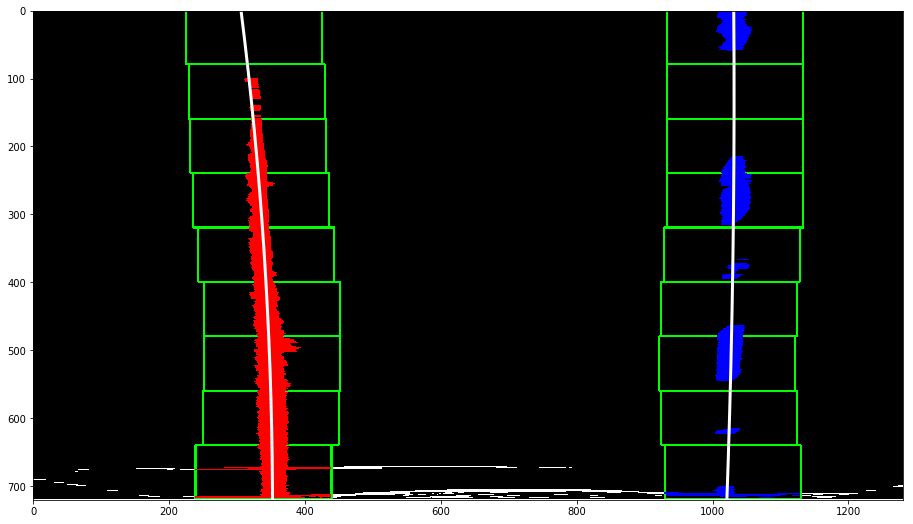

In [116]:
# Generate x and y values for plotting
def get_fit_xy(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

left_fit, right_fit, out_img, offset = find_line_fit_and_car_offset(combined_binary_smoothed)
left_fitx, right_fitx, ploty = get_fit_xy(combined_binary_smoothed, left_fit, right_fit)

fig = plt.figure(figsize=(16, 9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='white', linewidth=3.0)
plt.plot(right_fitx, ploty, color='white',  linewidth=3.0)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

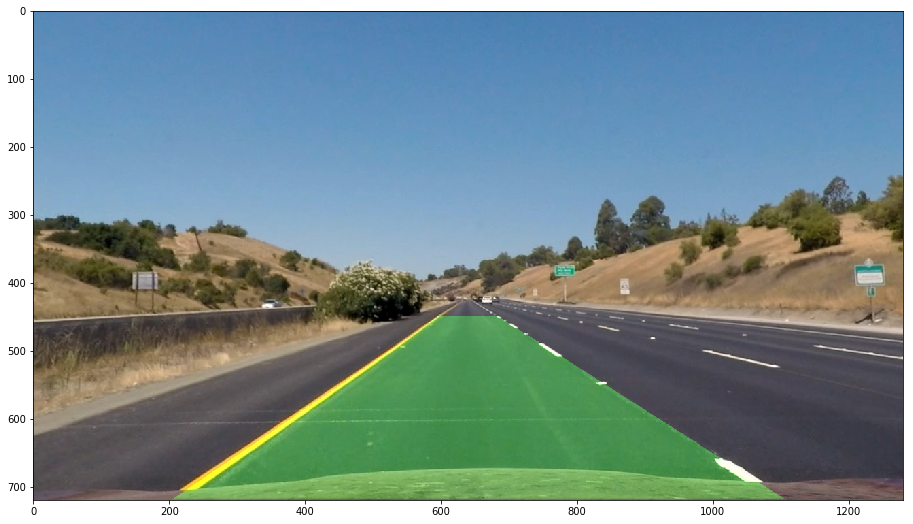

In [122]:
#transformed the wrapped image back onto the original image 
def project_back(wrap_img, origin_img, left_fitx, right_fitx, ploty, Minv):
    warp_zero = np.zeros_like(wrap_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = apply_perspective_transform(color_warp, Minv)
    # Combine the result with the original image
    result = cv2.addWeighted(origin_img, 1, newwarp, 0.3, 0)
    return result

img_w_lane_overlay = project_back(combined_binary_smoothed, dst_test, left_fitx, right_fitx, ploty, Minv)
fig = plt.figure(figsize=(16, 9))
plt.imshow(img_w_lane_overlay)

1920.0318245134172 m 5463.112518623087 m
0.2325714285714286 m


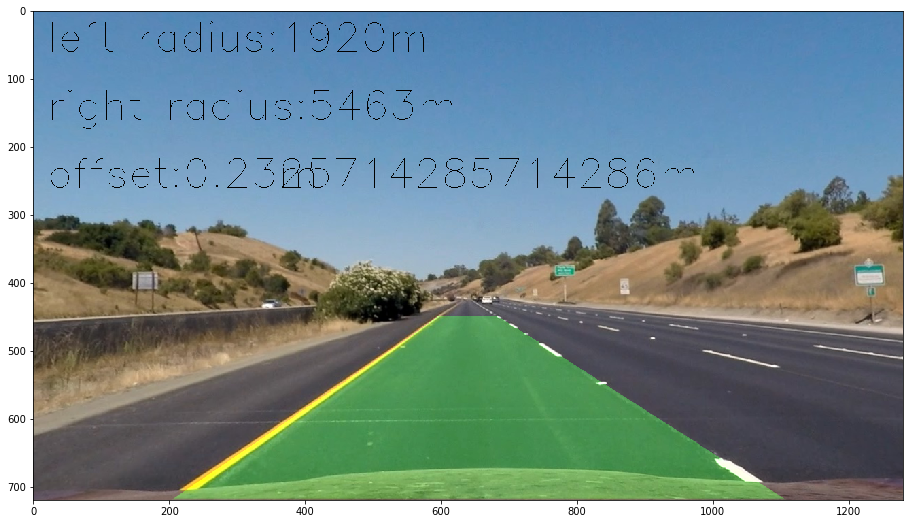

In [132]:
#calculate curvature and vehicle offset
def calculate_curvature_and_vehicle_position(ploty, left_fitx, right_fitx, offset_pixel):
    y_eval = np.max(ploty)
    # left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    # right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # print(left_curverad,'pixel',right_curverad,'pixel')

    #pixel to real world
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    offset = offset_pixel * xm_per_pix
    return left_curverad, right_curverad, offset

def add_curvature_and_offset_info(result, left_curverad, right_curverad, offset):
    cv2.putText(result, "left radius:"+ str(int(left_curverad))+'m', (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0))
    cv2.putText(result, "right radius:"+ str(int(right_curverad))+'m', (20, 160), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0))
    cv2.putText(result, "offset:"+ str(round(offset,2))+'m', (20, 260), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0))
    return result

del img_w_lane_overlay_and_info
left_curverad, right_curverad, offset_m = calculate_curvature_and_vehicle_position(ploty, left_fitx, right_fitx, offset)
img_w_lane_overlay_and_info = add_curvature_and_offset_info(img_w_lane_overlay, left_curverad, right_curverad, offset_m)

fig = plt.figure(figsize=(16, 9))
plt.imshow(img_w_lane_overlay_and_info)



90.0
339.30025764800916 m 316.77500552621626 m
0.47571428571428576 m


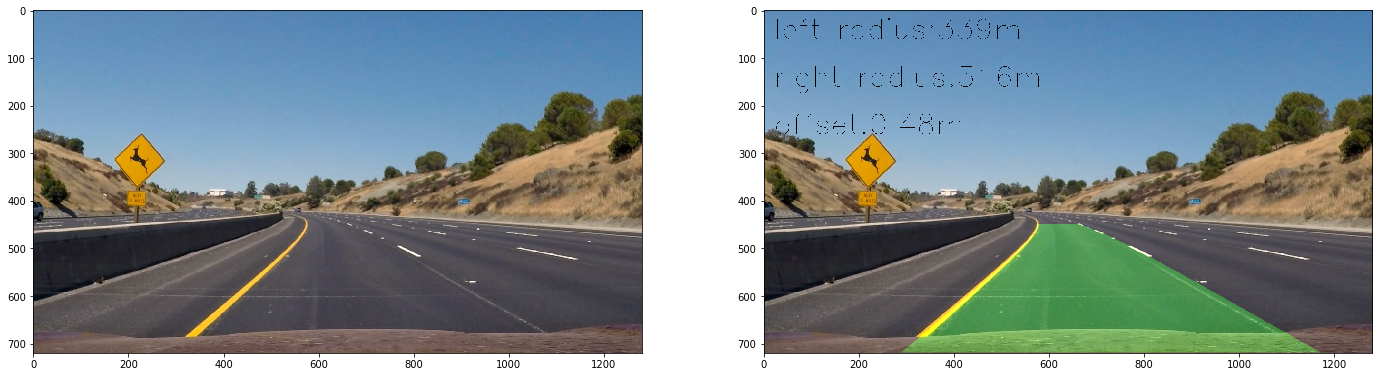

In [139]:
#apply the same method on a test image
def detect_lane_from_frame(frame, mtx, dist, M, Minv):
    #undistort
    frame_undistored = undistort(frame, mtx, dist)
    #apply perspective transform
    frame_warped = apply_perspective_transform(frame_undistored, M)
    #apply filter and smoothing
    lane_filtered = combine_filters(frame_warped)
    lane_smoothed = apply_smoothing(lane_filtered)
    #find left lane and right lane
    left_fit, right_fit, out_img, offset_pixel = find_line_fit_and_car_offset(lane_smoothed)
    left_fitx, right_fitx, ploty = get_fit_xy(lane_smoothed, left_fit, right_fit)
    frame_w_lane = project_back(lane_smoothed, frame, left_fitx, right_fitx, ploty, Minv)
    left_curverad, right_curverad, offset = calculate_curvature_and_vehicle_position(ploty, left_fitx, right_fitx, offset_pixel)
    frame_w_lane_and_info = add_curvature_and_offset_info(frame_w_lane, left_curverad, right_curverad, offset)
    return frame_w_lane_and_info

test_image2 = mpimg.imread('test_images/test2.jpg')
frame_w_lane_and_info_2 = detect_lane_from_frame(test_image2, mtx, dist, M, Minv)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(test_image2)
#print(test_image2.shape)
ax2.imshow(frame_w_lane_and_info_2)


103.5
502.3131345188856 m 217.34073854780107 m
0.5470714285714285 m


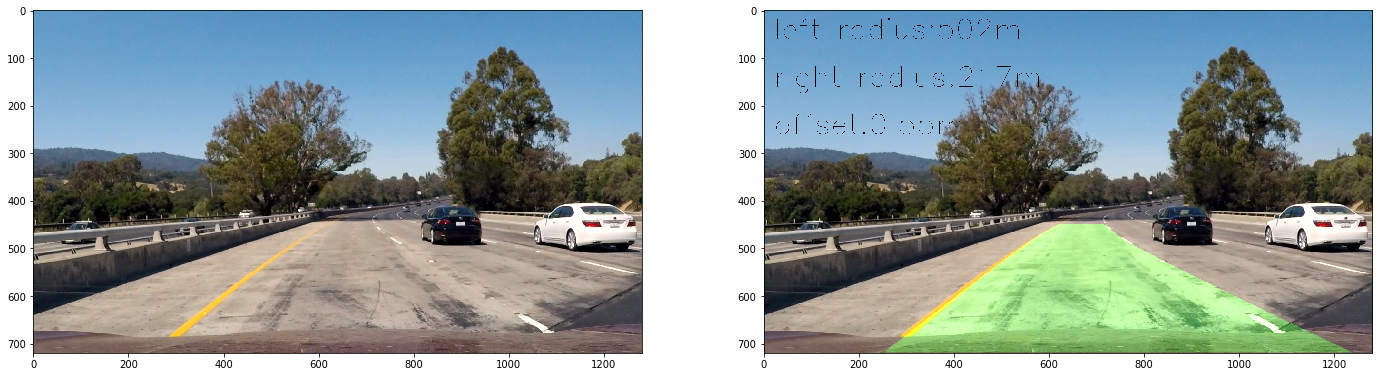

In [140]:
test_image2 = mpimg.imread('test_images/test1.jpg')
frame_w_lane_and_info_2 = detect_lane_from_frame(test_image2, mtx, dist, M, Minv)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(test_image2)
#print(test_image2.shape)
ax2.imshow(frame_w_lane_and_info_2)


97.5
356.42061088554044 m 370.9828712596163 m
0.5153571428571428 m
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|          | 0/126 [00:00<?, ?it/s]

97.5


  1%|          | 1/126 [00:00<00:25,  4.88it/s]

356.42061088554044 m 370.9828712596163 m
0.5153571428571428 m


  2%|▏         | 2/126 [00:00<00:29,  4.17it/s]

99.0
343.7166199648665 m 351.6211125604305 m
0.5232857142857144 m


  2%|▏         | 3/126 [00:00<00:29,  4.12it/s]

77.0
346.0674300627497 m 248.9430451587625 m
0.40700000000000003 m


  3%|▎         | 4/126 [00:00<00:28,  4.28it/s]

86.5
354.1220343219587 m 268.1830994861047 m
0.45721428571428574 m


  4%|▍         | 5/126 [00:01<00:29,  4.14it/s]

88.5
367.6098736423419 m 284.46816588874833 m
0.4677857142857143 m


  5%|▍         | 6/126 [00:01<00:28,  4.15it/s]

90.5
353.90240445471886 m 364.941413257806 m
0.47835714285714287 m


  6%|▌         | 7/126 [00:01<00:28,  4.13it/s]

94.5
369.8742824544799 m 360.79760975183024 m
0.4995 m


  6%|▋         | 8/126 [00:01<00:27,  4.25it/s]

94.5
376.8011949912186 m 367.6726269778364 m
0.4995 m
96.5


  8%|▊         | 10/126 [00:02<00:24,  4.75it/s]

392.2342109304499 m 397.95644366790737 m
0.5100714285714286 m
100.0
393.3089791680878 m 422.2891882427149 m
0.5285714285714286 m


  9%|▊         | 11/126 [00:02<00:23,  4.89it/s]

97.0
414.4390460333255 m 378.9594936830203 m
0.5127142857142858 m
94.5


 10%|▉         | 12/126 [00:02<00:22,  5.00it/s]

427.6733493172712 m 433.42203676055885 m
0.4995 m
96.5


 10%|█         | 13/126 [00:02<00:23,  4.83it/s]

458.5349670222036 m 464.29341097806594 m
0.5100714285714286 m
96.5


 12%|█▏        | 15/126 [00:03<00:22,  4.88it/s]

435.4060801712552 m 466.0443334288456 m
0.5100714285714286 m
70.5
417.67532454197675 m 252.90953971924 m
0.37264285714285716 m


 13%|█▎        | 16/126 [00:03<00:22,  4.87it/s]

67.0
405.73580748403987 m 236.67744014259725 m
0.35414285714285715 m
72.0


 13%|█▎        | 17/126 [00:03<00:22,  4.85it/s]

385.04464141727067 m 268.7707679992982 m
0.38057142857142856 m
71.0


 14%|█▍        | 18/126 [00:03<00:22,  4.84it/s]

376.8932467975181 m 255.17883607120746 m
0.3752857142857143 m


 15%|█▌        | 19/126 [00:04<00:23,  4.55it/s]

81.0
392.00782594978665 m 282.8539815366753 m
0.42814285714285716 m


 16%|█▌        | 20/126 [00:04<00:23,  4.56it/s]

83.5
407.3830048596214 m 277.23366373757347 m
0.4413571428571429 m


 17%|█▋        | 21/126 [00:04<00:23,  4.55it/s]

86.5
405.8536818535126 m 272.4238947399605 m
0.45721428571428574 m
89.5


 18%|█▊        | 23/126 [00:05<00:20,  4.95it/s]

432.90601792261316 m 349.13019524567244 m
0.4730714285714286 m
69.0
389.050267127544 m 273.4420776242584 m
0.3647142857142857 m


 19%|█▉        | 24/126 [00:05<00:20,  5.07it/s]

82.5
383.21293561034093 m 302.24287160724845 m
0.4360714285714286 m
84.0


 20%|█▉        | 25/126 [00:05<00:19,  5.10it/s]

372.86072846923867 m 311.89205942823946 m
0.444 m
85.5


 21%|██        | 26/126 [00:05<00:20,  4.96it/s]

383.1554342538169 m 332.6734235929084 m
0.45192857142857146 m
78.0


 21%|██▏       | 27/126 [00:05<00:20,  4.91it/s]

345.493305160108 m 352.9712395827451 m
0.4122857142857143 m
81.0


 23%|██▎       | 29/126 [00:06<00:19,  4.97it/s]

369.56735551838915 m 387.9658065620177 m
0.42814285714285716 m
89.5
359.43738111066517 m 398.4842847940138 m
0.4730714285714286 m


 24%|██▍       | 30/126 [00:06<00:19,  4.97it/s]

66.5
322.23909759094107 m 261.1641119827136 m
0.35150000000000003 m


 25%|██▍       | 31/126 [00:06<00:21,  4.50it/s]

79.5
303.8790365845442 m 280.0528711255641 m
0.4202142857142857 m


 25%|██▌       | 32/126 [00:06<00:21,  4.31it/s]

77.5
282.5424864625962 m 254.82232491515262 m
0.40964285714285714 m


 26%|██▌       | 33/126 [00:07<00:23,  3.99it/s]

80.5
286.69155957254003 m 262.1683026562884 m
0.42550000000000004 m


 27%|██▋       | 34/126 [00:07<00:22,  4.09it/s]

82.5
275.4108918818996 m 297.52425015105706 m
0.4360714285714286 m


 28%|██▊       | 35/126 [00:07<00:21,  4.14it/s]

84.5
265.81443614599795 m 296.4359673865852 m
0.4466428571428572 m
87.5


 29%|██▉       | 37/126 [00:08<00:19,  4.63it/s]

257.5744933947657 m 340.1070100274873 m
0.4625 m
79.0
258.9763569667248 m 223.00333838816027 m
0.4175714285714286 m


 30%|███       | 38/126 [00:08<00:18,  4.73it/s]

82.5
252.56103095957934 m 242.53748127591658 m
0.4360714285714286 m
52.0


 32%|███▏      | 40/126 [00:08<00:17,  4.99it/s]

250.04998106002245 m 160.43135116008676 m
0.27485714285714286 m
56.5
258.37024959723067 m 180.298320156716 m
0.29864285714285715 m


 33%|███▎      | 41/126 [00:08<00:16,  5.13it/s]

61.0
263.3443954545346 m 173.74561108743507 m
0.32242857142857145 m
69.5


 33%|███▎      | 42/126 [00:09<00:15,  5.29it/s]

261.8732627727211 m 202.77388115215845 m
0.3673571428571429 m
69.5


 34%|███▍      | 43/126 [00:09<00:16,  5.07it/s]

284.3217827342344 m 209.46113735840805 m
0.3673571428571429 m


 35%|███▍      | 44/126 [00:09<00:17,  4.56it/s]

71.5
296.0280426666056 m 205.58942652932282 m
0.37792857142857145 m


 36%|███▌      | 45/126 [00:09<00:19,  4.23it/s]

84.0
316.20776160009655 m 241.35422292339697 m
0.444 m


 37%|███▋      | 46/126 [00:10<00:20,  3.99it/s]

85.5
317.00052254316046 m 250.87043658695208 m
0.45192857142857146 m


 37%|███▋      | 47/126 [00:10<00:19,  4.12it/s]

88.5
341.30284460576405 m 292.9645530103793 m
0.4677857142857143 m


 38%|███▊      | 48/126 [00:10<00:18,  4.20it/s]

89.5
342.55140365373626 m 260.80172994443024 m
0.4730714285714286 m


 39%|███▉      | 49/126 [00:10<00:18,  4.21it/s]

83.5
375.41097959846985 m 209.83003129717156 m
0.4413571428571429 m


 40%|███▉      | 50/126 [00:10<00:17,  4.29it/s]

85.0
380.1835266800413 m 255.2038542631574 m
0.4492857142857143 m


 40%|████      | 51/126 [00:11<00:17,  4.31it/s]

86.5
413.2970623909975 m 278.457394899901 m
0.45721428571428574 m


 41%|████▏     | 52/126 [00:11<00:17,  4.34it/s]

87.0
400.7976349606056 m 283.9118416196883 m
0.45985714285714285 m


 42%|████▏     | 53/126 [00:11<00:17,  4.20it/s]

62.5
401.52571251220365 m 202.61683492283478 m
0.33035714285714285 m


 43%|████▎     | 54/126 [00:11<00:16,  4.24it/s]

63.0
393.2973532146672 m 209.6348520103563 m
0.333 m


 44%|████▎     | 55/126 [00:12<00:16,  4.28it/s]

69.0
404.51443685385766 m 218.54487109438938 m
0.3647142857142857 m
68.5


 44%|████▍     | 56/126 [00:12<00:15,  4.51it/s]

409.4073062853894 m 218.5661348843487 m
0.3620714285714286 m


 45%|████▌     | 57/126 [00:12<00:16,  4.25it/s]

72.0
412.5388853146724 m 204.0746248420155 m
0.38057142857142856 m


 46%|████▌     | 58/126 [00:12<00:16,  4.20it/s]

73.0
415.8117599948017 m 177.46213030775232 m
0.3858571428571429 m


 47%|████▋     | 59/126 [00:13<00:17,  3.92it/s]

73.5
395.5203485236345 m 175.61758189992585 m
0.3885 m


 48%|████▊     | 60/126 [00:13<00:16,  4.12it/s]

72.0
395.5027890396975 m 189.20978722466828 m
0.38057142857142856 m
73.5


 49%|████▉     | 62/126 [00:13<00:13,  4.64it/s]

383.39285715848877 m 236.23437876676647 m
0.3885 m
74.5
375.68824223014553 m 222.88956722316703 m
0.3937857142857143 m


 50%|█████     | 63/126 [00:13<00:13,  4.76it/s]

71.0
377.2748253744145 m 276.4430814101334 m
0.3752857142857143 m
41.5


 51%|█████     | 64/126 [00:14<00:12,  4.83it/s]

391.48978994891525 m 173.1301998885354 m
0.21935714285714286 m
40.5


 52%|█████▏    | 66/126 [00:14<00:12,  4.92it/s]

381.7614674307106 m 197.12499361988583 m
0.21407142857142858 m
44.0
387.6438141427956 m 201.6179110737786 m
0.2325714285714286 m


 53%|█████▎    | 67/126 [00:14<00:12,  4.91it/s]

47.0
389.9904911764801 m 236.7849341070692 m
0.24842857142857144 m
50.0


 55%|█████▍    | 69/126 [00:15<00:11,  5.03it/s]

399.4207484225612 m 240.3862858031844 m
0.2642857142857143 m
51.0
378.1211408909846 m 219.93418775876518 m
0.2695714285714286 m


 56%|█████▌    | 70/126 [00:15<00:10,  5.15it/s]

60.0
406.7674910105661 m 252.17349190997982 m
0.31714285714285717 m


 56%|█████▋    | 71/126 [00:15<00:11,  4.83it/s]

62.5
415.6969184038144 m 247.41618935315512 m
0.33035714285714285 m


 57%|█████▋    | 72/126 [00:15<00:11,  4.67it/s]

57.5
423.92048738107206 m 222.74902537515104 m
0.30392857142857144 m


 58%|█████▊    | 73/126 [00:16<00:12,  4.40it/s]

60.0
429.96144196445147 m 249.18210319508356 m
0.31714285714285717 m


 59%|█████▊    | 74/126 [00:16<00:11,  4.37it/s]

60.5
445.14719893320836 m 252.43687153210092 m
0.3197857142857143 m


 60%|█████▉    | 75/126 [00:16<00:11,  4.47it/s]

63.5
489.28172906362875 m 256.1487358229987 m
0.33564285714285713 m
63.0


 61%|██████    | 77/126 [00:16<00:10,  4.77it/s]

495.32746651620363 m 261.4218873132868 m
0.333 m
66.0
536.2174227828066 m 298.4822051905362 m
0.34885714285714287 m


 62%|██████▏   | 78/126 [00:17<00:09,  4.95it/s]

69.5
555.703616758043 m 307.12162520588623 m
0.3673571428571429 m
58.0


 63%|██████▎   | 80/126 [00:17<00:09,  5.09it/s]

567.5710197576695 m 271.88666897705053 m
0.3065714285714286 m
54.5
519.3880699527766 m 276.25447851555884 m
0.2880714285714286 m


 64%|██████▍   | 81/126 [00:17<00:08,  5.08it/s]

60.0
480.0911586253845 m 293.9375300378865 m
0.31714285714285717 m
61.0


 66%|██████▌   | 83/126 [00:18<00:08,  5.12it/s]

483.28140792677704 m 301.2413164399979 m
0.32242857142857145 m
63.0
473.7294630834938 m 342.6763993559277 m
0.333 m


 67%|██████▋   | 84/126 [00:18<00:08,  5.11it/s]

54.5
457.74656068810697 m 362.3575300829768 m
0.2880714285714286 m


 67%|██████▋   | 85/126 [00:18<00:08,  4.96it/s]

50.5
434.99416764275384 m 252.60749649485422 m
0.26692857142857146 m


 68%|██████▊   | 86/126 [00:18<00:08,  4.73it/s]

47.5
404.38306022057355 m 279.33026972880424 m
0.25107142857142856 m
51.0


 69%|██████▉   | 87/126 [00:18<00:08,  4.77it/s]

380.72208134148786 m 295.889488373048 m
0.2695714285714286 m


 70%|██████▉   | 88/126 [00:19<00:08,  4.34it/s]

57.0
383.2136802352961 m 295.62611254468356 m
0.3012857142857143 m


 71%|███████   | 89/126 [00:19<00:08,  4.49it/s]

58.0
352.72727060998 m 319.6641530873868 m
0.3065714285714286 m
29.5


 72%|███████▏  | 91/126 [00:19<00:07,  4.86it/s]

314.972413766878 m 194.77899117887532 m
0.15592857142857144 m
36.5
329.1744945921011 m 213.13245057636826 m
0.19292857142857145 m


 73%|███████▎  | 92/126 [00:19<00:06,  4.96it/s]

40.5
333.70023203346807 m 237.48634300511222 m
0.21407142857142858 m
47.0


 75%|███████▍  | 94/126 [00:20<00:06,  5.10it/s]

317.76043948253226 m 265.10896302369713 m
0.24842857142857144 m
52.5
311.2626847382413 m 273.5004049303704 m
0.2775 m


 75%|███████▌  | 95/126 [00:20<00:06,  5.12it/s]

55.5
320.1485525760714 m 285.4753348869457 m
0.29335714285714287 m
57.0


 76%|███████▌  | 96/126 [00:20<00:05,  5.14it/s]

325.1922054253757 m 296.5721868623019 m
0.3012857142857143 m
50.0
318.8873615007267 m 266.97116943565305 m
0.2642857142857143 m


 78%|███████▊  | 98/126 [00:21<00:05,  5.11it/s]

54.0
327.13677721714106 m 283.3995305631859 m
0.2854285714285714 m
55.0


 79%|███████▊  | 99/126 [00:21<00:05,  4.93it/s]

327.53101249178235 m 280.93143437176195 m
0.2907142857142857 m
58.0


 79%|███████▉  | 100/126 [00:21<00:05,  4.83it/s]

330.23590900407766 m 307.0292070734042 m
0.3065714285714286 m
61.0


 80%|████████  | 101/126 [00:21<00:05,  4.60it/s]

317.3112790447396 m 279.78325381831905 m
0.32242857142857145 m


 81%|████████  | 102/126 [00:22<00:05,  4.36it/s]

61.5
318.1913837460567 m 283.2897854097722 m
0.32507142857142857 m


 82%|████████▏ | 103/126 [00:22<00:05,  4.40it/s]

42.5
310.0308145399465 m 236.64365678931986 m
0.22464285714285714 m
65.5


 83%|████████▎ | 104/126 [00:22<00:04,  4.61it/s]

303.0805902242614 m 300.85859753365867 m
0.34621428571428575 m
66.5


 83%|████████▎ | 105/126 [00:22<00:04,  4.65it/s]

318.79390349227015 m 325.93290612312575 m
0.35150000000000003 m
68.5


 84%|████████▍ | 106/126 [00:22<00:04,  4.54it/s]

323.6451244632713 m 326.9195208505342 m
0.3620714285714286 m
71.0


 86%|████████▌ | 108/126 [00:23<00:03,  4.67it/s]

331.01319006462614 m 332.1845738416803 m
0.3752857142857143 m
71.5
314.7137691496093 m 310.26083783220025 m
0.37792857142857145 m


 87%|████████▋ | 109/126 [00:23<00:03,  4.89it/s]

63.0
303.67336973908544 m 241.81065482678738 m
0.333 m
66.0


 87%|████████▋ | 110/126 [00:23<00:03,  4.95it/s]

312.3795842021741 m 229.91946670025845 m
0.34885714285714287 m
71.5


 89%|████████▉ | 112/126 [00:24<00:02,  4.93it/s]

308.25436987582935 m 270.959919633093 m
0.37792857142857145 m
73.5
327.8888092320674 m 275.1563065634267 m
0.3885 m


 90%|████████▉ | 113/126 [00:24<00:02,  4.78it/s]

73.5
303.59720174496596 m 249.56871410162046 m
0.3885 m


 90%|█████████ | 114/126 [00:24<00:02,  4.48it/s]

76.0
309.872681822557 m 274.9263523868052 m
0.40171428571428575 m


 91%|█████████▏| 115/126 [00:24<00:02,  4.40it/s]

77.0
293.32678949334706 m 261.8116707008446 m
0.40700000000000003 m


 92%|█████████▏| 116/126 [00:25<00:02,  3.99it/s]

55.0
285.5203960126497 m 193.27432136122067 m
0.2907142857142857 m


 93%|█████████▎| 117/126 [00:25<00:02,  4.10it/s]

79.5
286.4268402995036 m 260.07714818351093 m
0.4202142857142857 m


 94%|█████████▎| 118/126 [00:25<00:01,  4.03it/s]

71.0
284.9549272705288 m 241.1897105126203 m
0.3752857142857143 m


 94%|█████████▍| 119/126 [00:25<00:01,  4.10it/s]

73.0
286.23841884644764 m 233.4990923680187 m
0.3858571428571429 m


 95%|█████████▌| 120/126 [00:26<00:01,  4.28it/s]

74.5
279.7616451949719 m 217.10681523459687 m
0.3937857142857143 m


 96%|█████████▌| 121/126 [00:26<00:01,  4.24it/s]

78.5
283.7859711792316 m 231.0321446373607 m
0.4149285714285714 m
78.5


 98%|█████████▊| 123/126 [00:26<00:00,  4.65it/s]

280.3870013614564 m 225.27989775453818 m
0.4149285714285714 m
80.5
277.865602333212 m 189.165130026193 m
0.42550000000000004 m


 98%|█████████▊| 124/126 [00:26<00:00,  4.59it/s]

82.5
277.4464291205101 m 194.25028747787022 m
0.4360714285714286 m


 99%|█████████▉| 125/126 [00:27<00:00,  4.38it/s]

77.5
274.87219556652343 m 170.74352571304175 m
0.40964285714285714 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 26.4 s, sys: 6.13 s, total: 32.5 s
Wall time: 28.7 s


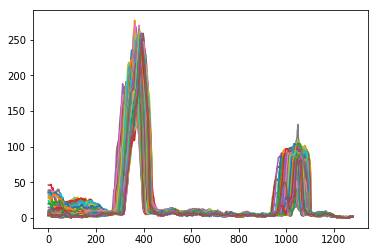

In [142]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(img):
    global mtx
    global dist
    global M
    global Minv

    return detect_lane_from_frame(img, mtx, dist, M, Minv)

clip = VideoFileClip("project_video.mp4").subclip(0,5)
clip_annotated = clip.fl_image(process_image)
%time clip_annotated.write_videofile("project_video_out.mp4", audio=False)

# vidcap = cv2.VideoCapture('big_buck_bunny_720p_5mb.mp4')
# success,image = vidcap.read()
# count = 0
# success = True
# video = cv2.VideoWriter("rec_out.avi", cv.CV_FOURCC(*'DIVX'), fps, (img.shape[1], img.shape[0]))
# while success:
#   success,image = vidcap.read()
#   print('Read a new frame: ', success)
#   cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
# video.write(img)
#   count += 1

In [143]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_out.mp4"))

97.5
356.42061088554044 m 370.9828712596163 m
0.5153571428571428 m
[MoviePy] >>>> Building video project_video_out_complete.mp4
[MoviePy] Writing video project_video_out_complete.mp4


  0%|          | 1/1261 [00:00<05:29,  3.83it/s]

97.5
356.42061088554044 m 370.9828712596163 m
0.5153571428571428 m


  0%|          | 2/1261 [00:00<05:14,  4.00it/s]

99.0
343.7166199648665 m 351.6211125604305 m
0.5232857142857144 m
77.0


  0%|          | 4/1261 [00:00<04:38,  4.51it/s]

346.0674300627497 m 248.9430451587625 m
0.40700000000000003 m
86.5
354.1220343219587 m 268.1830994861047 m
0.45721428571428574 m


  0%|          | 5/1261 [00:01<04:30,  4.64it/s]

88.5
367.6098736423419 m 284.46816588874833 m
0.4677857142857143 m
90.5


  0%|          | 6/1261 [00:01<04:23,  4.75it/s]

353.90240445471886 m 364.941413257806 m
0.47835714285714287 m
94.5
369.8742824544799 m 360.79760975183024 m
0.4995 m


  1%|          | 8/1261 [00:01<04:25,  4.72it/s]

94.5
376.8011949912186 m 367.6726269778364 m
0.4995 m
96.5


  1%|          | 9/1261 [00:01<04:18,  4.84it/s]

392.2342109304499 m 397.95644366790737 m
0.5100714285714286 m
100.0


  1%|          | 10/1261 [00:02<04:22,  4.76it/s]

393.3089791680878 m 422.2891882427149 m
0.5285714285714286 m
97.0


  1%|          | 11/1261 [00:02<04:32,  4.59it/s]

414.4390460333255 m 378.9594936830203 m
0.5127142857142858 m


  1%|          | 12/1261 [00:02<05:05,  4.09it/s]

94.5
427.6733493172712 m 433.42203676055885 m
0.4995 m


  1%|          | 13/1261 [00:02<05:16,  3.94it/s]

96.5
458.5349670222036 m 464.29341097806594 m
0.5100714285714286 m


  1%|          | 14/1261 [00:03<05:23,  3.85it/s]

96.5
435.4060801712552 m 466.0443334288456 m
0.5100714285714286 m


  1%|          | 15/1261 [00:03<05:16,  3.94it/s]

70.5
417.67532454197675 m 252.90953971924 m
0.37264285714285716 m


  1%|▏         | 16/1261 [00:03<04:55,  4.22it/s]

67.0
405.73580748403987 m 236.67744014259725 m
0.35414285714285715 m


  1%|▏         | 17/1261 [00:03<04:51,  4.27it/s]

72.0
385.04464141727067 m 268.7707679992982 m
0.38057142857142856 m


  1%|▏         | 18/1261 [00:04<04:51,  4.26it/s]

71.0
376.8932467975181 m 255.17883607120746 m
0.3752857142857143 m


  2%|▏         | 19/1261 [00:04<04:43,  4.38it/s]

81.0
392.00782594978665 m 282.8539815366753 m
0.42814285714285716 m


  2%|▏         | 20/1261 [00:04<04:33,  4.53it/s]

83.5
407.3830048596214 m 277.23366373757347 m
0.4413571428571429 m
86.5


  2%|▏         | 22/1261 [00:04<04:15,  4.85it/s]

405.8536818535126 m 272.4238947399605 m
0.45721428571428574 m
89.5
432.90601792261316 m 349.13019524567244 m
0.4730714285714286 m


  2%|▏         | 23/1261 [00:05<04:10,  4.95it/s]

69.0
389.050267127544 m 273.4420776242584 m
0.3647142857142857 m
82.5


  2%|▏         | 25/1261 [00:05<03:55,  5.25it/s]

383.21293561034093 m 302.24287160724845 m
0.4360714285714286 m
84.0
372.86072846923867 m 311.89205942823946 m
0.444 m


  2%|▏         | 26/1261 [00:05<04:06,  5.00it/s]

85.5
383.1554342538169 m 332.6734235929084 m
0.45192857142857146 m
78.0


  2%|▏         | 27/1261 [00:05<04:11,  4.90it/s]

345.493305160108 m 352.9712395827451 m
0.4122857142857143 m
81.0


  2%|▏         | 28/1261 [00:06<04:31,  4.54it/s]

369.56735551838915 m 387.9658065620177 m
0.42814285714285716 m


  2%|▏         | 29/1261 [00:06<05:15,  3.90it/s]

89.5
359.43738111066517 m 398.4842847940138 m
0.4730714285714286 m


  2%|▏         | 30/1261 [00:06<05:00,  4.10it/s]

66.5
322.23909759094107 m 261.1641119827136 m
0.35150000000000003 m


  2%|▏         | 31/1261 [00:06<05:02,  4.07it/s]

79.5
303.8790365845442 m 280.0528711255641 m
0.4202142857142857 m


  3%|▎         | 32/1261 [00:07<05:06,  4.01it/s]

77.5
282.5424864625962 m 254.82232491515262 m
0.40964285714285714 m


  3%|▎         | 33/1261 [00:07<05:00,  4.08it/s]

80.5
286.69155957254003 m 262.1683026562884 m
0.42550000000000004 m
82.5


  3%|▎         | 35/1261 [00:07<04:26,  4.60it/s]

275.4108918818996 m 297.52425015105706 m
0.4360714285714286 m
84.5
265.81443614599795 m 296.4359673865852 m
0.4466428571428572 m


  3%|▎         | 36/1261 [00:08<04:14,  4.82it/s]

87.5
257.5744933947657 m 340.1070100274873 m
0.4625 m
79.0


  3%|▎         | 37/1261 [00:08<04:15,  4.80it/s]

258.9763569667248 m 223.00333838816027 m
0.4175714285714286 m
82.5


  3%|▎         | 38/1261 [00:08<04:28,  4.55it/s]

252.56103095957934 m 242.53748127591658 m
0.4360714285714286 m
52.0


  3%|▎         | 39/1261 [00:08<04:39,  4.38it/s]

250.04998106002245 m 160.43135116008676 m
0.27485714285714286 m
56.5


  3%|▎         | 40/1261 [00:08<04:34,  4.44it/s]

258.37024959723067 m 180.298320156716 m
0.29864285714285715 m


  3%|▎         | 41/1261 [00:09<05:02,  4.03it/s]

61.0
263.3443954545346 m 173.74561108743507 m
0.32242857142857145 m


  3%|▎         | 42/1261 [00:09<05:03,  4.01it/s]

69.5
261.8732627727211 m 202.77388115215845 m
0.3673571428571429 m
69.5


  3%|▎         | 44/1261 [00:09<04:34,  4.43it/s]

284.3217827342344 m 209.46113735840805 m
0.3673571428571429 m
71.5
296.0280426666056 m 205.58942652932282 m
0.37792857142857145 m


  4%|▎         | 45/1261 [00:10<04:21,  4.65it/s]

84.0
316.20776160009655 m 241.35422292339697 m
0.444 m
85.5


  4%|▎         | 46/1261 [00:10<04:13,  4.80it/s]

317.00052254316046 m 250.87043658695208 m
0.45192857142857146 m
88.5


  4%|▎         | 47/1261 [00:10<04:12,  4.81it/s]

341.30284460576405 m 292.9645530103793 m
0.4677857142857143 m
89.5
342.55140365373626 m 260.80172994443024 m
0.4730714285714286 m


  4%|▍         | 49/1261 [00:10<04:08,  4.88it/s]

83.5
375.41097959846985 m 209.83003129717156 m
0.4413571428571429 m
85.0


  4%|▍         | 50/1261 [00:11<04:03,  4.97it/s]

380.1835266800413 m 255.2038542631574 m
0.4492857142857143 m
86.5


  4%|▍         | 51/1261 [00:11<04:09,  4.84it/s]

413.2970623909975 m 278.457394899901 m
0.45721428571428574 m
87.0


  4%|▍         | 52/1261 [00:11<04:24,  4.57it/s]

400.7976349606056 m 283.9118416196883 m
0.45985714285714285 m


  4%|▍         | 53/1261 [00:11<05:01,  4.01it/s]

62.5
401.52571251220365 m 202.61683492283478 m
0.33035714285714285 m


  4%|▍         | 54/1261 [00:12<05:02,  3.99it/s]

63.0
393.2973532146672 m 209.6348520103563 m
0.333 m


  4%|▍         | 55/1261 [00:12<05:18,  3.79it/s]

69.0
404.51443685385766 m 218.54487109438938 m
0.3647142857142857 m


  4%|▍         | 56/1261 [00:12<05:00,  4.01it/s]

68.5
409.4073062853894 m 218.5661348843487 m
0.3620714285714286 m


  5%|▍         | 57/1261 [00:12<04:42,  4.26it/s]

72.0
412.5388853146724 m 204.0746248420155 m
0.38057142857142856 m
73.0


  5%|▍         | 58/1261 [00:13<04:30,  4.45it/s]

415.8117599948017 m 177.46213030775232 m
0.3858571428571429 m
73.5
395.5203485236345 m 175.61758189992585 m
0.3885 m


  5%|▍         | 60/1261 [00:13<04:19,  4.62it/s]

72.0
395.5027890396975 m 189.20978722466828 m
0.38057142857142856 m
73.5


  5%|▍         | 62/1261 [00:13<04:06,  4.87it/s]

383.39285715848877 m 236.23437876676647 m
0.3885 m
74.5
375.68824223014553 m 222.88956722316703 m
0.3937857142857143 m


  5%|▍         | 63/1261 [00:14<04:06,  4.86it/s]

71.0
377.2748253744145 m 276.4430814101334 m
0.3752857142857143 m
41.5


  5%|▌         | 64/1261 [00:14<04:04,  4.90it/s]

391.48978994891525 m 173.1301998885354 m
0.21935714285714286 m
40.5
381.7614674307106 m 197.12499361988583 m
0.21407142857142858 m


  5%|▌         | 66/1261 [00:14<04:11,  4.75it/s]

44.0
387.6438141427956 m 201.6179110737786 m
0.2325714285714286 m


  5%|▌         | 67/1261 [00:14<04:19,  4.60it/s]

47.0
389.9904911764801 m 236.7849341070692 m
0.24842857142857144 m


  5%|▌         | 68/1261 [00:15<04:35,  4.33it/s]

50.0
399.4207484225612 m 240.3862858031844 m
0.2642857142857143 m


  5%|▌         | 69/1261 [00:15<04:37,  4.29it/s]

51.0
378.1211408909846 m 219.93418775876518 m
0.2695714285714286 m


  6%|▌         | 70/1261 [00:15<04:28,  4.43it/s]

60.0
406.7674910105661 m 252.17349190997982 m
0.31714285714285717 m
62.5


  6%|▌         | 71/1261 [00:15<04:19,  4.58it/s]

415.6969184038144 m 247.41618935315512 m
0.33035714285714285 m
57.5
423.92048738107206 m 222.74902537515104 m
0.30392857142857144 m


  6%|▌         | 73/1261 [00:16<04:12,  4.70it/s]

60.0
429.96144196445147 m 249.18210319508356 m
0.31714285714285717 m
60.5


  6%|▌         | 74/1261 [00:16<04:01,  4.91it/s]

445.14719893320836 m 252.43687153210092 m
0.3197857142857143 m
63.5


  6%|▌         | 75/1261 [00:16<04:02,  4.89it/s]

489.28172906362875 m 256.1487358229987 m
0.33564285714285713 m
63.0
495.32746651620363 m 261.4218873132868 m
0.333 m


  6%|▌         | 77/1261 [00:17<04:02,  4.88it/s]

66.0
536.2174227828066 m 298.4822051905362 m
0.34885714285714287 m
69.5


  6%|▌         | 78/1261 [00:17<04:01,  4.90it/s]

555.703616758043 m 307.12162520588623 m
0.3673571428571429 m


  6%|▋         | 79/1261 [00:17<04:24,  4.47it/s]

58.0
567.5710197576695 m 271.88666897705053 m
0.3065714285714286 m


  6%|▋         | 80/1261 [00:17<04:34,  4.30it/s]

54.5
519.3880699527766 m 276.25447851555884 m
0.2880714285714286 m


  6%|▋         | 81/1261 [00:18<04:36,  4.26it/s]

60.0
480.0911586253845 m 293.9375300378865 m
0.31714285714285717 m


  7%|▋         | 82/1261 [00:18<04:50,  4.05it/s]

61.0
483.28140792677704 m 301.2413164399979 m
0.32242857142857145 m


  7%|▋         | 83/1261 [00:18<04:48,  4.09it/s]

63.0
473.7294630834938 m 342.6763993559277 m
0.333 m
54.5


  7%|▋         | 84/1261 [00:18<04:31,  4.33it/s]

457.74656068810697 m 362.3575300829768 m
0.2880714285714286 m
50.5
434.99416764275384 m 252.60749649485422 m
0.26692857142857146 m


  7%|▋         | 86/1261 [00:19<04:17,  4.57it/s]

47.5
404.38306022057355 m 279.33026972880424 m
0.25107142857142856 m
51.0


  7%|▋         | 88/1261 [00:19<04:03,  4.81it/s]

380.72208134148786 m 295.889488373048 m
0.2695714285714286 m
57.0
383.2136802352961 m 295.62611254468356 m
0.3012857142857143 m


  7%|▋         | 89/1261 [00:19<03:58,  4.92it/s]

58.0
352.72727060998 m 319.6641530873868 m
0.3065714285714286 m


  7%|▋         | 90/1261 [00:19<04:01,  4.85it/s]

29.5
314.972413766878 m 194.77899117887532 m
0.15592857142857144 m


  7%|▋         | 91/1261 [00:20<04:00,  4.86it/s]

36.5
329.1744945921011 m 213.13245057636826 m
0.19292857142857145 m
40.5


  7%|▋         | 92/1261 [00:20<04:00,  4.87it/s]

333.70023203346807 m 237.48634300511222 m
0.21407142857142858 m
47.0


  7%|▋         | 93/1261 [00:20<04:14,  4.59it/s]

317.76043948253226 m 265.10896302369713 m
0.24842857142857144 m
52.5


  7%|▋         | 94/1261 [00:20<04:18,  4.51it/s]

311.2626847382413 m 273.5004049303704 m
0.2775 m


  8%|▊         | 95/1261 [00:21<04:26,  4.38it/s]

55.5
320.1485525760714 m 285.4753348869457 m
0.29335714285714287 m


  8%|▊         | 96/1261 [00:21<04:48,  4.04it/s]

57.0
325.1922054253757 m 296.5721868623019 m
0.3012857142857143 m


  8%|▊         | 97/1261 [00:21<04:50,  4.01it/s]

50.0
318.8873615007267 m 266.97116943565305 m
0.2642857142857143 m


  8%|▊         | 98/1261 [00:21<04:54,  3.96it/s]

54.0
327.13677721714106 m 283.3995305631859 m
0.2854285714285714 m


  8%|▊         | 99/1261 [00:22<04:59,  3.88it/s]

55.0
327.53101249178235 m 280.93143437176195 m
0.2907142857142857 m


  8%|▊         | 100/1261 [00:22<04:49,  4.01it/s]

58.0
330.23590900407766 m 307.0292070734042 m
0.3065714285714286 m


  8%|▊         | 101/1261 [00:22<04:41,  4.12it/s]

61.0
317.3112790447396 m 279.78325381831905 m
0.32242857142857145 m


  8%|▊         | 102/1261 [00:22<04:38,  4.16it/s]

61.5
318.1913837460567 m 283.2897854097722 m
0.32507142857142857 m


  8%|▊         | 103/1261 [00:23<04:38,  4.16it/s]

42.5
310.0308145399465 m 236.64365678931986 m
0.22464285714285714 m
65.5


  8%|▊         | 104/1261 [00:23<04:25,  4.37it/s]

303.0805902242614 m 300.85859753365867 m
0.34621428571428575 m
66.5
318.79390349227015 m 325.93290612312575 m
0.35150000000000003 m


  8%|▊         | 106/1261 [00:23<04:36,  4.18it/s]

68.5
323.6451244632713 m 326.9195208505342 m
0.3620714285714286 m


  8%|▊         | 107/1261 [00:24<04:49,  3.98it/s]

71.0
331.01319006462614 m 332.1845738416803 m
0.3752857142857143 m


  9%|▊         | 108/1261 [00:24<05:21,  3.59it/s]

71.5
314.7137691496093 m 310.26083783220025 m
0.37792857142857145 m


  9%|▊         | 109/1261 [00:24<05:10,  3.71it/s]

63.0
303.67336973908544 m 241.81065482678738 m
0.333 m


  9%|▊         | 110/1261 [00:24<04:52,  3.93it/s]

66.0
312.3795842021741 m 229.91946670025845 m
0.34885714285714287 m


  9%|▉         | 111/1261 [00:25<04:34,  4.19it/s]

71.5
308.25436987582935 m 270.959919633093 m
0.37792857142857145 m
73.5


  9%|▉         | 112/1261 [00:25<04:26,  4.30it/s]

327.8888092320674 m 275.1563065634267 m
0.3885 m
73.5


  9%|▉         | 113/1261 [00:25<04:31,  4.23it/s]

303.59720174496596 m 249.56871410162046 m
0.3885 m


  9%|▉         | 114/1261 [00:25<04:49,  3.97it/s]

76.0
309.872681822557 m 274.9263523868052 m
0.40171428571428575 m


  9%|▉         | 115/1261 [00:26<04:42,  4.05it/s]

77.0
293.32678949334706 m 261.8116707008446 m
0.40700000000000003 m


  9%|▉         | 116/1261 [00:26<04:39,  4.09it/s]

55.0
285.5203960126497 m 193.27432136122067 m
0.2907142857142857 m


  9%|▉         | 117/1261 [00:26<04:24,  4.32it/s]

79.5
286.4268402995036 m 260.07714818351093 m
0.4202142857142857 m


  9%|▉         | 118/1261 [00:26<04:31,  4.21it/s]

71.0
284.9549272705288 m 241.1897105126203 m
0.3752857142857143 m


  9%|▉         | 119/1261 [00:26<04:39,  4.08it/s]

73.0
286.23841884644764 m 233.4990923680187 m
0.3858571428571429 m


 10%|▉         | 120/1261 [00:27<04:43,  4.02it/s]

74.5
279.7616451949719 m 217.10681523459687 m
0.3937857142857143 m


 10%|▉         | 121/1261 [00:27<05:11,  3.66it/s]

78.5
283.7859711792316 m 231.0321446373607 m
0.4149285714285714 m


 10%|▉         | 122/1261 [00:27<05:26,  3.48it/s]

78.5
280.3870013614564 m 225.27989775453818 m
0.4149285714285714 m


 10%|▉         | 123/1261 [00:28<05:10,  3.67it/s]

80.5
277.865602333212 m 189.165130026193 m
0.42550000000000004 m


 10%|▉         | 124/1261 [00:28<05:05,  3.72it/s]

82.5
277.4464291205101 m 194.25028747787022 m
0.4360714285714286 m


 10%|▉         | 125/1261 [00:28<04:54,  3.86it/s]

77.5
274.87219556652343 m 170.74352571304175 m
0.40964285714285714 m


 10%|▉         | 126/1261 [00:28<04:47,  3.94it/s]

80.5
303.04478870125666 m 227.49776454000448 m
0.42550000000000004 m


 10%|█         | 127/1261 [00:29<04:44,  3.99it/s]

82.5
300.9138928060031 m 234.54522237413414 m
0.4360714285714286 m


 10%|█         | 128/1261 [00:29<05:01,  3.76it/s]

63.5
310.2639250423899 m 185.70726477101502 m
0.33564285714285713 m


 10%|█         | 129/1261 [00:29<05:02,  3.74it/s]

62.5
309.62217349564855 m 175.21757347187975 m
0.33035714285714285 m


 10%|█         | 130/1261 [00:30<05:22,  3.51it/s]

65.5
314.8855025136047 m 189.29971193307247 m
0.34621428571428575 m


 10%|█         | 131/1261 [00:30<05:25,  3.47it/s]

69.0
317.8934119097808 m 196.37199462387397 m
0.3647142857142857 m


 10%|█         | 132/1261 [00:30<05:10,  3.63it/s]

69.0
318.5914121363483 m 180.47232051013958 m
0.3647142857142857 m


 11%|█         | 133/1261 [00:30<05:47,  3.25it/s]

74.0
322.23099401483796 m 174.04767159188577 m
0.3911428571428572 m


 11%|█         | 134/1261 [00:31<05:41,  3.30it/s]

84.0
333.18768885398197 m 217.4246706293945 m
0.444 m


 11%|█         | 135/1261 [00:31<05:11,  3.62it/s]

87.5
346.56435616921925 m 223.97806153868495 m
0.4625 m


 11%|█         | 136/1261 [00:31<04:54,  3.81it/s]

91.5
361.9026891187776 m 262.2928125092818 m
0.48364285714285715 m


 11%|█         | 137/1261 [00:31<04:54,  3.82it/s]

87.0
369.01849715254076 m 251.1217261860062 m
0.45985714285714285 m


 11%|█         | 138/1261 [00:32<04:38,  4.03it/s]

90.5
383.0268326906314 m 283.02309225968804 m
0.47835714285714287 m


 11%|█         | 139/1261 [00:32<04:31,  4.13it/s]

92.5
404.9975809749459 m 331.4913351974182 m
0.48892857142857143 m


 11%|█         | 140/1261 [00:32<04:20,  4.30it/s]

93.5
412.89744683460566 m 382.7188808304986 m
0.4942142857142857 m


 11%|█         | 141/1261 [00:32<04:17,  4.35it/s]

70.0
411.7044084233876 m 248.20620248366308 m
0.37 m


 11%|█▏        | 142/1261 [00:33<04:35,  4.06it/s]

69.0
394.0715683448033 m 245.19607740444184 m
0.3647142857142857 m


 11%|█▏        | 143/1261 [00:33<04:30,  4.13it/s]

73.0
394.79696879952957 m 280.79419132974874 m
0.3858571428571429 m


 11%|█▏        | 144/1261 [00:33<04:30,  4.12it/s]

72.0
383.8445178073259 m 252.39811175070767 m
0.38057142857142856 m


 11%|█▏        | 145/1261 [00:33<04:46,  3.90it/s]

72.0
369.58180395938206 m 271.57178246184463 m
0.38057142857142856 m


 12%|█▏        | 146/1261 [00:34<04:41,  3.96it/s]

75.0
368.770851370188 m 216.84753314395695 m
0.39642857142857146 m
87.0


 12%|█▏        | 148/1261 [00:34<04:09,  4.46it/s]

378.77140935594895 m 314.38462970089427 m
0.45985714285714285 m
77.5
341.51140724240804 m 199.34150390205994 m
0.40964285714285714 m


 12%|█▏        | 149/1261 [00:34<04:08,  4.48it/s]

80.5
330.9434679742702 m 232.14620959489153 m
0.42550000000000004 m
84.0


 12%|█▏        | 150/1261 [00:34<03:57,  4.68it/s]

345.90917960660084 m 254.89021191429106 m
0.444 m
84.5


 12%|█▏        | 151/1261 [00:35<03:56,  4.69it/s]

356.8581323469316 m 249.41679556217122 m
0.4466428571428572 m
87.5


 12%|█▏        | 152/1261 [00:35<03:57,  4.67it/s]

383.1308499262646 m 269.3037777281897 m
0.4625 m


 12%|█▏        | 153/1261 [00:35<04:10,  4.42it/s]

63.5
346.11071270028907 m 191.71582342252114 m
0.33564285714285713 m


 12%|█▏        | 154/1261 [00:35<04:12,  4.38it/s]

68.0
363.15392980529856 m 220.040184237887 m
0.35942857142857143 m


 12%|█▏        | 155/1261 [00:36<04:22,  4.22it/s]

71.0
361.6132714880946 m 242.95623321606044 m
0.3752857142857143 m


 12%|█▏        | 156/1261 [00:36<04:20,  4.24it/s]

71.5
373.02940232665713 m 236.68851472309544 m
0.37792857142857145 m


 12%|█▏        | 157/1261 [00:36<04:17,  4.29it/s]

78.5
367.64076220430553 m 277.1648073757158 m
0.4149285714285714 m


 13%|█▎        | 158/1261 [00:36<04:38,  3.96it/s]

77.5
366.53443962331124 m 241.562236137194 m
0.40964285714285714 m


 13%|█▎        | 159/1261 [00:37<04:39,  3.95it/s]

77.0
339.5259620064772 m 245.4307351454028 m
0.40700000000000003 m


 13%|█▎        | 160/1261 [00:37<04:23,  4.17it/s]

78.5
332.79373660595934 m 253.3857687893133 m
0.4149285714285714 m
81.5


 13%|█▎        | 161/1261 [00:37<04:11,  4.38it/s]

347.3668809301218 m 308.9864658043844 m
0.4307857142857143 m
81.5


 13%|█▎        | 162/1261 [00:37<04:07,  4.45it/s]

346.15599930632965 m 324.00711486112806 m
0.4307857142857143 m
85.0


 13%|█▎        | 163/1261 [00:37<04:07,  4.43it/s]

360.766375415641 m 471.424002051502 m
0.4492857142857143 m
77.0


 13%|█▎        | 164/1261 [00:38<04:17,  4.25it/s]

355.2388256781039 m 274.9142371450042 m
0.40700000000000003 m
46.5


 13%|█▎        | 165/1261 [00:38<04:15,  4.29it/s]

327.8310355015774 m 173.26267523962616 m
0.2457857142857143 m
49.5
334.7175966812912 m 133.39692765493487 m
0.2616428571428572 m


 13%|█▎        | 167/1261 [00:38<04:04,  4.47it/s]

56.0
304.84555998780905 m 208.6203996432673 m
0.29600000000000004 m
65.0


 13%|█▎        | 168/1261 [00:39<03:59,  4.57it/s]

335.3830572354334 m 267.4711898720939 m
0.3435714285714286 m
68.0


 13%|█▎        | 169/1261 [00:39<04:10,  4.36it/s]

344.860652154866 m 241.06508417690415 m
0.35942857142857143 m
71.5


 13%|█▎        | 170/1261 [00:39<04:09,  4.37it/s]

349.318500663044 m 295.1083957021282 m
0.37792857142857145 m


 14%|█▎        | 171/1261 [00:39<04:39,  3.90it/s]

72.0
345.0832011744591 m 263.0022429945606 m
0.38057142857142856 m


 14%|█▎        | 172/1261 [00:40<05:43,  3.17it/s]

62.5
356.0201869247596 m 194.00308037038272 m
0.33035714285714285 m


 14%|█▎        | 173/1261 [00:40<05:14,  3.45it/s]

65.5
337.4737834382322 m 197.87266362815734 m
0.34621428571428575 m


 14%|█▍        | 174/1261 [00:40<05:03,  3.58it/s]

64.0
300.7672542432328 m 179.30833698929632 m
0.3382857142857143 m


 14%|█▍        | 175/1261 [00:41<04:50,  3.74it/s]

66.0
285.63648923370727 m 180.052362490202 m
0.34885714285714287 m
66.5


 14%|█▍        | 176/1261 [00:41<04:26,  4.08it/s]

288.4954352957855 m 164.703912636792 m
0.35150000000000003 m


 14%|█▍        | 177/1261 [00:41<04:37,  3.91it/s]

69.5
298.7904580451611 m 207.85023844969336 m
0.3673571428571429 m


 14%|█▍        | 178/1261 [00:41<04:27,  4.05it/s]

49.5
302.6964954843531 m 146.51298306027448 m
0.2616428571428572 m
73.0


 14%|█▍        | 179/1261 [00:41<04:10,  4.31it/s]

303.5857211681882 m 190.20971359070106 m
0.3858571428571429 m
56.5


 14%|█▍        | 180/1261 [00:42<04:05,  4.41it/s]

286.46264927429934 m 165.09055353737352 m
0.29864285714285715 m


 14%|█▍        | 181/1261 [00:42<04:16,  4.22it/s]

61.0
277.0740379753279 m 160.81731203103786 m
0.32242857142857145 m


 14%|█▍        | 182/1261 [00:42<04:12,  4.28it/s]

64.0
276.9319063842563 m 175.90971995597508 m
0.3382857142857143 m


 15%|█▍        | 183/1261 [00:42<04:28,  4.01it/s]

70.0
267.7688300859292 m 179.84414068094 m
0.37 m


 15%|█▍        | 184/1261 [00:43<04:23,  4.09it/s]

70.5
255.14703722770895 m 171.4978909328939 m
0.37264285714285716 m
71.5


 15%|█▍        | 186/1261 [00:43<03:54,  4.58it/s]

250.57354504396076 m 182.44125386089755 m
0.37792857142857145 m
69.0
221.88237090244183 m 162.13718170953632 m
0.3647142857142857 m


 15%|█▍        | 187/1261 [00:43<03:52,  4.62it/s]

73.0
223.76123451238544 m 173.33705347575335 m
0.3858571428571429 m
28.0


 15%|█▍        | 189/1261 [00:44<03:41,  4.85it/s]

225.1365617949206 m 117.8522164125276 m
0.14800000000000002 m
32.5
222.83823773137786 m 100.79520677678977 m
0.1717857142857143 m


 15%|█▌        | 190/1261 [00:44<03:38,  4.90it/s]

38.0
226.3464664190095 m 122.85601003234412 m
0.20085714285714287 m
43.0


 15%|█▌        | 192/1261 [00:44<03:29,  5.09it/s]

222.26741140526008 m 138.68267854614908 m
0.22728571428571429 m
47.5
228.57529189402408 m 156.80265601674515 m
0.25107142857142856 m


 15%|█▌        | 193/1261 [00:44<03:27,  5.14it/s]

53.0
226.68455671981636 m 153.52923432527783 m
0.28014285714285714 m


 15%|█▌        | 194/1261 [00:45<03:35,  4.95it/s]

58.0
234.80468773989597 m 156.3131229572215 m
0.3065714285714286 m


 15%|█▌        | 195/1261 [00:45<03:54,  4.55it/s]

64.0
235.3284777610398 m 152.70964517645322 m
0.3382857142857143 m


 16%|█▌        | 196/1261 [00:45<03:55,  4.53it/s]

68.0
278.01039500478106 m 171.6696726898329 m
0.35942857142857143 m


 16%|█▌        | 197/1261 [00:45<04:14,  4.17it/s]

79.0
309.91074832236944 m 235.11177448052777 m
0.4175714285714286 m


 16%|█▌        | 198/1261 [00:46<04:13,  4.19it/s]

79.0
348.98663980277934 m 281.26504596028815 m
0.4175714285714286 m


 16%|█▌        | 199/1261 [00:46<04:20,  4.07it/s]

81.0
393.2967031981629 m 351.13323188048895 m
0.42814285714285716 m


 16%|█▌        | 200/1261 [00:46<04:06,  4.31it/s]

80.5
387.07975552528535 m 344.5796452026542 m
0.42550000000000004 m
79.0


 16%|█▌        | 202/1261 [00:47<03:47,  4.65it/s]

396.3338154953337 m 346.7229747849278 m
0.4175714285714286 m
78.5
368.3072235794233 m 382.4809801316911 m
0.4149285714285714 m


 16%|█▌        | 203/1261 [00:47<04:03,  4.34it/s]

52.5
343.3914856042186 m 202.36766042079358 m
0.2775 m


 16%|█▌        | 204/1261 [00:47<04:00,  4.39it/s]

52.0
326.8322255036494 m 208.87856206648013 m
0.27485714285714286 m


 16%|█▋        | 205/1261 [00:47<03:58,  4.43it/s]

54.0
312.8480340592331 m 205.20887992146461 m
0.2854285714285714 m
61.0


 16%|█▋        | 206/1261 [00:47<03:49,  4.60it/s]

300.61357151688765 m 211.97018163754578 m
0.32242857142857145 m
61.0


 16%|█▋        | 207/1261 [00:48<04:19,  4.06it/s]

272.52775776320357 m 189.0652822658039 m
0.32242857142857145 m


 16%|█▋        | 208/1261 [00:48<05:33,  3.16it/s]

58.0
263.9578552148357 m 152.61105653670293 m
0.3065714285714286 m


 17%|█▋        | 209/1261 [00:49<06:50,  2.56it/s]

62.5
274.28210256857625 m 162.37721703571407 m
0.33035714285714285 m


 17%|█▋        | 210/1261 [00:49<06:51,  2.55it/s]

67.5
286.0955386558518 m 182.3029212391359 m
0.3567857142857143 m


 17%|█▋        | 211/1261 [00:49<06:21,  2.75it/s]

76.5
310.035294981846 m 331.1418907747475 m
0.40435714285714286 m


 17%|█▋        | 212/1261 [00:50<05:54,  2.96it/s]

76.5
305.53587900409497 m 310.74864278174493 m
0.40435714285714286 m


 17%|█▋        | 213/1261 [00:50<05:22,  3.25it/s]

72.0
320.61132641270524 m 300.8512072252824 m
0.38057142857142856 m


 17%|█▋        | 214/1261 [00:50<04:53,  3.57it/s]

72.0
304.050206666379 m 319.8555729251196 m
0.38057142857142856 m


 17%|█▋        | 215/1261 [00:50<04:33,  3.82it/s]

40.0
306.59224186738857 m 198.51971024569394 m
0.21142857142857144 m


 17%|█▋        | 216/1261 [00:51<04:18,  4.05it/s]

43.0
313.91967742539356 m 210.36402997104878 m
0.22728571428571429 m


 17%|█▋        | 217/1261 [00:51<04:07,  4.22it/s]

46.0
318.84561796023075 m 229.20776279030366 m
0.24314285714285716 m
48.5


 17%|█▋        | 218/1261 [00:51<03:55,  4.43it/s]

325.51228279468063 m 231.1722553480307 m
0.2563571428571429 m
48.0


 17%|█▋        | 219/1261 [00:51<03:52,  4.48it/s]

322.663287826201 m 207.219350186738 m
0.2537142857142857 m


 17%|█▋        | 220/1261 [00:52<04:17,  4.05it/s]

50.5
332.2728043114953 m 205.66409578422758 m
0.26692857142857146 m


 18%|█▊        | 221/1261 [00:52<05:28,  3.16it/s]

57.0
362.5951071146842 m 231.8424425110899 m
0.3012857142857143 m


 18%|█▊        | 222/1261 [00:52<04:59,  3.47it/s]

59.5
379.86533747295806 m 237.85258063880897 m
0.3145 m


 18%|█▊        | 223/1261 [00:53<04:44,  3.65it/s]

65.5
389.15654646406523 m 318.89299324309496 m
0.34621428571428575 m


 18%|█▊        | 224/1261 [00:53<04:31,  3.82it/s]

64.0
374.82900596178365 m 299.8021758731807 m
0.3382857142857143 m


 18%|█▊        | 225/1261 [00:53<04:31,  3.81it/s]

65.5
400.68232924468884 m 321.5682054207502 m
0.34621428571428575 m


 18%|█▊        | 226/1261 [00:53<04:22,  3.94it/s]

26.0
370.7375084880058 m 172.85339667084438 m
0.13742857142857143 m


 18%|█▊        | 227/1261 [00:53<04:16,  4.04it/s]

29.5
371.8148899057016 m 202.83116130953866 m
0.15592857142857144 m


 18%|█▊        | 228/1261 [00:54<05:10,  3.33it/s]

32.0
380.8947188652451 m 216.1399910566527 m
0.16914285714285715 m


 18%|█▊        | 229/1261 [00:55<07:45,  2.21it/s]

37.0
380.46804839866974 m 250.280045468468 m
0.1955714285714286 m


 18%|█▊        | 230/1261 [00:55<06:44,  2.55it/s]

38.0
386.28572129428744 m 238.8226099896323 m
0.20085714285714287 m


 18%|█▊        | 231/1261 [00:55<06:11,  2.77it/s]

39.5
368.19006340374324 m 220.8356212383089 m
0.2087857142857143 m


 18%|█▊        | 232/1261 [00:56<05:58,  2.87it/s]

51.5
390.00505086775087 m 250.9743129239023 m
0.27221428571428574 m


 18%|█▊        | 233/1261 [00:56<05:35,  3.06it/s]

50.0
375.57617509153124 m 273.00708294618295 m
0.2642857142857143 m


 19%|█▊        | 234/1261 [00:56<05:36,  3.05it/s]

52.5
378.7473082447537 m 264.3940472261013 m
0.2775 m


 19%|█▊        | 235/1261 [00:56<05:15,  3.25it/s]

50.0
385.36662920145864 m 238.90971443412923 m
0.2642857142857143 m


 19%|█▊        | 236/1261 [00:57<06:28,  2.64it/s]

44.0
355.1285727992696 m 188.9056739495164 m
0.2325714285714286 m


 19%|█▉        | 237/1261 [00:58<07:30,  2.27it/s]

45.0
367.3188077723609 m 197.16126625782272 m
0.23785714285714288 m


 19%|█▉        | 238/1261 [00:58<07:37,  2.24it/s]

46.0
337.42678617702126 m 169.28995234067347 m
0.24314285714285716 m


 19%|█▉        | 239/1261 [00:58<07:23,  2.30it/s]

12.0
318.78895723141943 m 97.72567966413052 m
0.06342857142857143 m


 19%|█▉        | 240/1261 [00:59<06:53,  2.47it/s]

44.5
320.7077221602032 m 218.98764255768273 m
0.23521428571428574 m


 19%|█▉        | 241/1261 [00:59<06:24,  2.65it/s]

21.5
329.9010745823447 m 167.86621380899206 m
0.11364285714285714 m


 19%|█▉        | 242/1261 [00:59<05:35,  3.04it/s]

27.0
351.8392905675563 m 185.46623369051397 m
0.1427142857142857 m


 19%|█▉        | 243/1261 [01:00<05:03,  3.35it/s]

27.0
335.7838798398323 m 158.3923673741806 m
0.1427142857142857 m


 19%|█▉        | 244/1261 [01:00<04:35,  3.69it/s]

29.0
332.2690250559662 m 162.29055616818664 m
0.1532857142857143 m


 19%|█▉        | 245/1261 [01:00<04:18,  3.93it/s]

31.0
318.8458815402999 m 156.06761956874115 m
0.16385714285714287 m


 20%|█▉        | 246/1261 [01:00<04:03,  4.17it/s]

32.5
313.24245734875024 m 149.3016850256358 m
0.1717857142857143 m


 20%|█▉        | 247/1261 [01:00<03:53,  4.35it/s]

34.5
313.3949230219373 m 162.01443491756663 m
0.18235714285714286 m


 20%|█▉        | 248/1261 [01:01<03:46,  4.48it/s]

36.0
300.5892244606736 m 153.70484485451433 m
0.19028571428571428 m


 20%|█▉        | 249/1261 [01:01<03:58,  4.25it/s]

35.5
327.0154495424484 m 178.31342934421613 m
0.18764285714285714 m


 20%|█▉        | 250/1261 [01:01<04:00,  4.21it/s]

7.0
329.64442708313265 m 121.33135803464792 m
0.037000000000000005 m


 20%|█▉        | 251/1261 [01:01<04:23,  3.83it/s]

11.0
335.74765707629115 m 138.78015485212657 m
0.05814285714285715 m


 20%|█▉        | 252/1261 [01:02<04:18,  3.90it/s]

14.5
346.2476669690215 m 158.05627064774407 m
0.07664285714285715 m


 20%|██        | 253/1261 [01:02<04:10,  4.02it/s]

18.5
333.96874821266715 m 168.22633646074698 m
0.0977857142857143 m


 20%|██        | 254/1261 [01:02<04:08,  4.06it/s]

24.0
352.3422300114138 m 202.36577060511388 m
0.12685714285714286 m


 20%|██        | 255/1261 [01:02<04:09,  4.04it/s]

26.0
353.3520865252975 m 190.72707010517288 m
0.13742857142857143 m


 20%|██        | 256/1261 [01:03<04:03,  4.12it/s]

28.0
352.5552422025956 m 187.51413684168477 m
0.14800000000000002 m


 20%|██        | 257/1261 [01:03<04:04,  4.11it/s]

32.5
337.82865969404213 m 191.42808461412721 m
0.1717857142857143 m


 20%|██        | 258/1261 [01:03<04:00,  4.17it/s]

34.0
331.76161554054306 m 191.035771176444 m
0.17971428571428572 m


 21%|██        | 259/1261 [01:03<04:27,  3.75it/s]

43.0
343.33271449413326 m 240.75179683175404 m
0.22728571428571429 m


 21%|██        | 260/1261 [01:04<04:28,  3.73it/s]

37.5
333.0033266310277 m 203.9717556893422 m
0.19821428571428573 m


 21%|██        | 261/1261 [01:04<04:32,  3.67it/s]

41.5
374.7807363595291 m 237.29728119579295 m
0.21935714285714286 m


 21%|██        | 262/1261 [01:04<05:02,  3.30it/s]

44.5
371.18064998296524 m 247.38544456154838 m
0.23521428571428574 m


 21%|██        | 263/1261 [01:05<04:43,  3.52it/s]

45.5
379.0268880320638 m 263.9998312111771 m
0.24050000000000002 m


 21%|██        | 264/1261 [01:05<04:34,  3.63it/s]

49.0
382.61047036409883 m 268.0183861780788 m
0.259 m


 21%|██        | 265/1261 [01:05<04:27,  3.72it/s]

50.0
385.9554669483362 m 293.0435673389159 m
0.2642857142857143 m


 21%|██        | 266/1261 [01:05<04:44,  3.50it/s]

49.0
395.90848670269077 m 292.0181690246159 m
0.259 m


 21%|██        | 267/1261 [01:06<04:26,  3.73it/s]

52.0
403.9256592393252 m 325.3343556046989 m
0.27485714285714286 m


 21%|██▏       | 268/1261 [01:06<04:12,  3.93it/s]

50.0
406.5490961722433 m 299.3538882374574 m
0.2642857142857143 m


 21%|██▏       | 269/1261 [01:06<03:58,  4.15it/s]

50.5
416.2106835519355 m 348.5784437588114 m
0.26692857142857146 m
42.0


 21%|██▏       | 271/1261 [01:06<03:37,  4.56it/s]

418.0999505269085 m 284.42645914476367 m
0.222 m
44.5
428.355099687954 m 294.20502992499803 m
0.23521428571428574 m


 22%|██▏       | 272/1261 [01:07<03:33,  4.62it/s]

50.5
411.3976583622307 m 318.0417709153658 m
0.26692857142857146 m


 22%|██▏       | 273/1261 [01:07<03:42,  4.43it/s]

47.5
421.28163507835023 m 284.0648371759015 m
0.25107142857142856 m


 22%|██▏       | 274/1261 [01:07<03:49,  4.31it/s]

49.0
425.53803731917293 m 269.46469056239187 m
0.259 m


 22%|██▏       | 275/1261 [01:07<03:57,  4.15it/s]

53.0
444.3601912821681 m 294.48932836404606 m
0.28014285714285714 m


 22%|██▏       | 276/1261 [01:08<03:52,  4.24it/s]

42.5
465.05499832832214 m 215.0994160246463 m
0.22464285714285714 m


 22%|██▏       | 277/1261 [01:08<03:44,  4.38it/s]

46.0
479.8724570015522 m 240.9160207254711 m
0.24314285714285716 m


 22%|██▏       | 278/1261 [01:08<03:37,  4.52it/s]

50.5
501.3448034503824 m 321.1771571475956 m
0.26692857142857146 m
53.0


 22%|██▏       | 279/1261 [01:08<03:31,  4.65it/s]

507.45707824554165 m 299.26264184980073 m
0.28014285714285714 m
56.0
503.97209535556493 m 337.21549435234203 m
0.29600000000000004 m


 22%|██▏       | 281/1261 [01:09<03:26,  4.75it/s]

49.5
524.6764716689457 m 287.2905437178629 m
0.2616428571428572 m
50.5


 22%|██▏       | 282/1261 [01:09<03:26,  4.75it/s]

525.4707042175933 m 304.2251061342835 m
0.26692857142857146 m
57.5
572.5996842099763 m 330.1631119401138 m
0.30392857142857144 m


 23%|██▎       | 284/1261 [01:09<03:19,  4.90it/s]

59.5
577.60142072906 m 341.52007038749986 m
0.3145 m
62.0


 23%|██▎       | 285/1261 [01:09<03:15,  4.98it/s]

604.7771144657034 m 415.54542927048726 m
0.32771428571428574 m
61.5


 23%|██▎       | 286/1261 [01:10<03:26,  4.73it/s]

632.2089620536185 m 374.06546456728984 m
0.32507142857142857 m


 23%|██▎       | 287/1261 [01:10<03:39,  4.43it/s]

62.5
655.4295420112728 m 383.24435572388035 m
0.33035714285714285 m


 23%|██▎       | 288/1261 [01:10<03:48,  4.27it/s]

65.0
695.8332892135185 m 405.869863416658 m
0.3435714285714286 m


 23%|██▎       | 289/1261 [01:11<04:05,  3.96it/s]

66.0
636.2512553931607 m 378.7615817280998 m
0.34885714285714287 m


 23%|██▎       | 290/1261 [01:11<04:16,  3.78it/s]

70.0
688.8264480052297 m 471.96384669103315 m
0.37 m


 23%|██▎       | 291/1261 [01:11<04:11,  3.85it/s]

69.0
644.9082200244675 m 435.7632185110291 m
0.3647142857142857 m


 23%|██▎       | 292/1261 [01:11<04:02,  4.00it/s]

66.5
642.9550386550909 m 363.0556301364077 m
0.35150000000000003 m


 23%|██▎       | 293/1261 [01:11<03:54,  4.13it/s]

63.0
669.5375167431342 m 320.2856279828109 m
0.333 m


 23%|██▎       | 294/1261 [01:12<03:50,  4.19it/s]

66.0
710.7065040113794 m 328.1909015089415 m
0.34885714285714287 m


 23%|██▎       | 295/1261 [01:12<03:50,  4.19it/s]

68.5
698.6067194861365 m 382.89298455189004 m
0.3620714285714286 m


 23%|██▎       | 296/1261 [01:12<03:49,  4.21it/s]

69.0
747.4658615801291 m 369.83352293066093 m
0.3647142857142857 m
67.5


 24%|██▎       | 297/1261 [01:12<03:43,  4.32it/s]

699.0942877261039 m 351.3887153067591 m
0.3567857142857143 m
69.5


 24%|██▎       | 298/1261 [01:13<03:46,  4.25it/s]

807.1958113426683 m 405.81934747564344 m
0.3673571428571429 m


 24%|██▎       | 299/1261 [01:13<03:56,  4.07it/s]

71.0
895.1428592216186 m 402.74852096296667 m
0.3752857142857143 m


 24%|██▍       | 300/1261 [01:13<04:09,  3.86it/s]

72.0
957.0850329272747 m 433.61029438973634 m
0.38057142857142856 m


 24%|██▍       | 301/1261 [01:13<04:13,  3.79it/s]

74.0
917.5482700893937 m 464.68362864657644 m
0.3911428571428572 m


 24%|██▍       | 302/1261 [01:14<04:13,  3.78it/s]

74.0
1003.647431563796 m 718.5050042574857 m
0.3911428571428572 m


 24%|██▍       | 303/1261 [01:14<04:14,  3.76it/s]

74.0
951.2876706407482 m 723.7271727025678 m
0.3911428571428572 m


 24%|██▍       | 304/1261 [01:14<04:00,  3.98it/s]

69.5
920.4710009897315 m 720.0798609909384 m
0.3673571428571429 m


 24%|██▍       | 305/1261 [01:14<03:57,  4.03it/s]

63.0
996.3457502039964 m 662.0629934911843 m
0.333 m


 24%|██▍       | 306/1261 [01:15<03:53,  4.10it/s]

63.0
981.9873968513144 m 570.79586272421 m
0.333 m


 24%|██▍       | 307/1261 [01:15<03:50,  4.13it/s]

71.0
1232.401549440141 m 594.2448068992186 m
0.3752857142857143 m


 24%|██▍       | 308/1261 [01:15<03:46,  4.21it/s]

69.5
1158.5484597381076 m 410.6220099303655 m
0.3673571428571429 m


 25%|██▍       | 309/1261 [01:15<03:42,  4.28it/s]

74.0
1213.6727585791443 m 680.5923497756453 m
0.3911428571428572 m


 25%|██▍       | 310/1261 [01:16<04:00,  3.95it/s]

70.5
1601.2931445866645 m 793.6170451096546 m
0.37264285714285716 m


 25%|██▍       | 311/1261 [01:16<04:01,  3.94it/s]

71.0
1589.2301377943877 m 650.3185628342908 m
0.3752857142857143 m


 25%|██▍       | 312/1261 [01:16<04:04,  3.89it/s]

72.0
2058.378904940483 m 752.3651618118839 m
0.38057142857142856 m


 25%|██▍       | 313/1261 [01:17<04:29,  3.52it/s]

66.5
1387.5011347102702 m 667.2931181687712 m
0.35150000000000003 m


 25%|██▍       | 314/1261 [01:17<04:19,  3.65it/s]

75.5
1799.2869019845002 m 829.4000939589038 m
0.3990714285714286 m


 25%|██▍       | 315/1261 [01:17<04:18,  3.66it/s]

77.0
2086.1615480700357 m 802.3579382330714 m
0.40700000000000003 m


 25%|██▌       | 316/1261 [01:17<04:02,  3.90it/s]

76.5
3717.954380528098 m 759.0029523581486 m
0.40435714285714286 m


 25%|██▌       | 317/1261 [01:18<04:03,  3.88it/s]

73.5
3215.1095524766115 m 678.5499931157254 m
0.3885 m


 25%|██▌       | 318/1261 [01:18<03:51,  4.07it/s]

74.0
4104.5337983894915 m 538.7772528042254 m
0.3911428571428572 m


 25%|██▌       | 319/1261 [01:18<04:00,  3.91it/s]

75.5
3346.366047502076 m 610.3450478556111 m
0.3990714285714286 m


 25%|██▌       | 320/1261 [01:18<03:50,  4.09it/s]

71.0
3059.2331723654993 m 507.91240300192 m
0.3752857142857143 m


 25%|██▌       | 321/1261 [01:19<03:53,  4.03it/s]

72.5
5283.492962891051 m 721.8686932839792 m
0.38321428571428573 m


 26%|██▌       | 322/1261 [01:19<04:03,  3.86it/s]

76.5
10377.101112506058 m 812.6166359029114 m
0.40435714285714286 m


 26%|██▌       | 323/1261 [01:19<04:07,  3.79it/s]

78.5
17195.911274763574 m 834.7807162698915 m
0.4149285714285714 m


 26%|██▌       | 324/1261 [01:19<04:06,  3.80it/s]

81.5
7844.697661352036 m 998.349335962507 m
0.4307857142857143 m


 26%|██▌       | 325/1261 [01:20<04:29,  3.48it/s]

80.5
4245.6226820164 m 945.8258067732107 m
0.42550000000000004 m


 26%|██▌       | 326/1261 [01:20<04:24,  3.53it/s]

80.5
3231.310958285809 m 992.4098604287002 m
0.42550000000000004 m


 26%|██▌       | 327/1261 [01:20<04:11,  3.71it/s]

82.0
5017.746936086765 m 1259.2711010133833 m
0.43342857142857144 m


 26%|██▌       | 328/1261 [01:20<03:55,  3.97it/s]

81.5
4209.9692781429785 m 948.8230450174889 m
0.4307857142857143 m


 26%|██▌       | 329/1261 [01:21<03:51,  4.02it/s]

86.0
3667.949925252538 m 3172.596851178946 m
0.45457142857142857 m


 26%|██▌       | 330/1261 [01:21<03:48,  4.08it/s]

83.5
4559.733887376397 m 1094.046184350911 m
0.4413571428571429 m


 26%|██▌       | 331/1261 [01:21<03:42,  4.18it/s]

78.0
4927.241048858814 m 1344.391613392646 m
0.4122857142857143 m


 26%|██▋       | 332/1261 [01:21<03:44,  4.14it/s]

77.5
7222.6385100119705 m 1072.063825457256 m
0.40964285714285714 m


 26%|██▋       | 333/1261 [01:22<03:36,  4.28it/s]

78.0
3883.102657904353 m 829.7858069648477 m
0.4122857142857143 m


 26%|██▋       | 334/1261 [01:22<03:30,  4.40it/s]

76.5
3341.7178477483735 m 1601.2815368385627 m
0.40435714285714286 m


 27%|██▋       | 335/1261 [01:22<03:47,  4.06it/s]

77.5
4434.95805179229 m 1487.3600630044928 m
0.40964285714285714 m


 27%|██▋       | 336/1261 [01:22<03:44,  4.13it/s]

91.0
7551.057803681559 m 2142.259059612486 m
0.48100000000000004 m


 27%|██▋       | 337/1261 [01:23<04:05,  3.76it/s]

83.0
3409.7619882327253 m 2285.8102737000268 m
0.4387142857142857 m


 27%|██▋       | 338/1261 [01:23<03:58,  3.87it/s]

82.0
11993.494042408956 m 1817.5314060438059 m
0.43342857142857144 m


 27%|██▋       | 339/1261 [01:23<03:44,  4.10it/s]

83.5
5733.8369543402205 m 3047.511121108504 m
0.4413571428571429 m


 27%|██▋       | 340/1261 [01:23<03:35,  4.27it/s]

82.0
5540.7164155199 m 1693.2713366352616 m
0.43342857142857144 m


 27%|██▋       | 341/1261 [01:24<03:27,  4.42it/s]

83.5
5148.799804503042 m 2044.0338712120333 m
0.4413571428571429 m
80.5


 27%|██▋       | 342/1261 [01:24<03:20,  4.58it/s]

8026.769638996243 m 1302.4750683083282 m
0.42550000000000004 m
81.0


 27%|██▋       | 343/1261 [01:24<03:21,  4.56it/s]

5599.231890939287 m 1387.2851154018433 m
0.42814285714285716 m
81.5
5326.536408263248 m 2274.3940807740164 m
0.4307857142857143 m


 27%|██▋       | 345/1261 [01:24<03:11,  4.77it/s]

91.5
13205.681288588617 m 4904.07785280807 m
0.48364285714285715 m
84.0


 28%|██▊       | 347/1261 [01:25<03:05,  4.94it/s]

3019.2890214575814 m 5069.786064914045 m
0.444 m
83.5
2703.2245808090797 m 2410.221560477606 m
0.4413571428571429 m


 28%|██▊       | 348/1261 [01:25<03:23,  4.49it/s]

86.0
4328.739658618905 m 5187.803511768859 m
0.45457142857142857 m


 28%|██▊       | 349/1261 [01:25<03:29,  4.35it/s]

83.5
1844.4119638931475 m 2681.176531980963 m
0.4413571428571429 m


 28%|██▊       | 350/1261 [01:26<03:32,  4.30it/s]

88.5
1515.7009761817276 m 2454.6074642471253 m
0.4677857142857143 m


 28%|██▊       | 351/1261 [01:26<03:55,  3.87it/s]

86.5
1291.368667895338 m 2129.209963618493 m
0.45721428571428574 m


 28%|██▊       | 352/1261 [01:26<03:42,  4.08it/s]

88.0
1233.6404143569537 m 2453.758663840846 m
0.4651428571428572 m
90.5


 28%|██▊       | 353/1261 [01:26<03:30,  4.30it/s]

994.1627592438161 m 4271.617076928183 m
0.47835714285714287 m
89.0
840.7458656239323 m 5990.327888818589 m
0.4704285714285715 m


 28%|██▊       | 355/1261 [01:27<03:18,  4.57it/s]

88.5
822.4603664927845 m 8078.553075388605 m
0.4677857142857143 m
87.0


 28%|██▊       | 357/1261 [01:27<03:09,  4.76it/s]

771.9697599976919 m 3905.705592694546 m
0.45985714285714285 m
85.5
1091.017348965913 m 2310.439477831324 m
0.45192857142857146 m


 28%|██▊       | 358/1261 [01:27<03:08,  4.79it/s]

84.0
965.7774779801028 m 3389.0937761543187 m
0.444 m


 28%|██▊       | 359/1261 [01:27<03:13,  4.65it/s]

84.5
1168.5209022875313 m 3044.296381116633 m
0.4466428571428572 m


 29%|██▊       | 360/1261 [01:28<03:10,  4.73it/s]

88.0
1641.897702243728 m 4421.414959608286 m
0.4651428571428572 m


 29%|██▊       | 361/1261 [01:28<03:08,  4.78it/s]

84.5
7578.075559651045 m 2397.8250133014335 m
0.4466428571428572 m


 29%|██▊       | 362/1261 [01:28<03:43,  4.03it/s]

85.5
38236.640944639 m 1834.2958056999994 m
0.45192857142857146 m


 29%|██▉       | 363/1261 [01:28<03:38,  4.12it/s]

93.0
2128.339642115136 m 5382.476341661984 m
0.4915714285714286 m


 29%|██▉       | 364/1261 [01:29<03:54,  3.82it/s]

85.5
2642.6421863434985 m 3215.3095786298677 m
0.45192857142857146 m


 29%|██▉       | 365/1261 [01:29<03:47,  3.93it/s]

87.5
1885.6626414960886 m 9035.278247684819 m
0.4625 m
86.5


 29%|██▉       | 366/1261 [01:29<03:34,  4.18it/s]

1059.8475354657064 m 5290.099703473978 m
0.45721428571428574 m
87.0


 29%|██▉       | 367/1261 [01:29<03:26,  4.33it/s]

1177.7609687271424 m 3376.01034408266 m
0.45985714285714285 m
88.0


 29%|██▉       | 368/1261 [01:30<03:24,  4.37it/s]

979.7062113483483 m 6455.084390375671 m
0.4651428571428572 m
87.0


 29%|██▉       | 369/1261 [01:30<03:21,  4.44it/s]

865.5084639641806 m 4198.657442735708 m
0.45985714285714285 m
87.0


 29%|██▉       | 371/1261 [01:30<03:12,  4.62it/s]

911.5225439136657 m 10929.093970502216 m
0.45985714285714285 m
88.0
998.5125532629312 m 13169.865095922665 m
0.4651428571428572 m


 30%|██▉       | 372/1261 [01:31<03:12,  4.63it/s]

87.0
995.7871762862554 m 391947.01871608803 m
0.45985714285714285 m
87.5


 30%|██▉       | 373/1261 [01:31<03:06,  4.77it/s]

1584.8865171375935 m 17941.67766672079 m
0.4625 m
85.0
3052.5612719131964 m 20306.32120784732 m
0.4492857142857143 m


 30%|██▉       | 375/1261 [01:31<03:14,  4.55it/s]

83.0
3922.5927059125956 m 7653.6679575192165 m
0.4387142857142857 m


 30%|██▉       | 376/1261 [01:31<03:18,  4.46it/s]

84.5
8966.88098502225 m 4737.532826401128 m
0.4466428571428572 m


 30%|██▉       | 377/1261 [01:32<03:39,  4.02it/s]

85.0
13297.926364605715 m 13375.810543767402 m
0.4492857142857143 m


 30%|██▉       | 378/1261 [01:32<03:44,  3.93it/s]

83.0
11649.989661136447 m 2544.7824675415545 m
0.4387142857142857 m


 30%|███       | 379/1261 [01:32<03:33,  4.13it/s]

84.5
3909.564926577185 m 7387.527463286908 m
0.4466428571428572 m


 30%|███       | 380/1261 [01:32<03:28,  4.22it/s]

85.0
2374.7434918233944 m 9074.583480669842 m
0.4492857142857143 m


 30%|███       | 381/1261 [01:33<03:19,  4.42it/s]

86.0
2478.52372619464 m 5235.873172884063 m
0.45457142857142857 m


 30%|███       | 382/1261 [01:33<03:18,  4.44it/s]

83.5
2757.9446977695147 m 4594.282259830847 m
0.4413571428571429 m


 30%|███       | 383/1261 [01:33<03:14,  4.52it/s]

85.5
1924.6611625311284 m 2802.982417481865 m
0.45192857142857146 m


 30%|███       | 384/1261 [01:33<03:19,  4.40it/s]

82.5
2222.023103950371 m 7459.4567461293 m
0.4360714285714286 m


 31%|███       | 385/1261 [01:33<03:17,  4.45it/s]

83.0
2004.3660645823365 m 6791.4371113851485 m
0.4387142857142857 m
82.0


 31%|███       | 386/1261 [01:34<03:11,  4.57it/s]

1903.2262874741689 m 10676.610794176553 m
0.43342857142857144 m
81.0


 31%|███       | 387/1261 [01:34<03:11,  4.57it/s]

1874.4972122038391 m 4706.879136457239 m
0.42814285714285716 m


 31%|███       | 388/1261 [01:34<03:26,  4.22it/s]

83.5
1633.493900497227 m 3662.2074211398453 m
0.4413571428571429 m


 31%|███       | 389/1261 [01:34<03:31,  4.13it/s]

84.5
1608.9482558319748 m 2655.1759639856 m
0.4466428571428572 m


 31%|███       | 390/1261 [01:35<03:46,  3.85it/s]

85.5
1690.8002440173286 m 2715.5894287646424 m
0.45192857142857146 m


 31%|███       | 391/1261 [01:35<03:46,  3.84it/s]

87.0
2127.63331100651 m 2097.7777544737883 m
0.45985714285714285 m


 31%|███       | 392/1261 [01:35<03:31,  4.11it/s]

84.5
1705.5770089296773 m 2015.3871660344682 m
0.4466428571428572 m


 31%|███       | 393/1261 [01:35<03:25,  4.22it/s]

80.0
2166.114250017725 m 2825.0983406551454 m
0.4228571428571429 m


 31%|███       | 394/1261 [01:36<03:20,  4.33it/s]

82.5
2253.0942462661887 m 1701.493998871433 m
0.4360714285714286 m


 31%|███▏      | 395/1261 [01:36<03:16,  4.41it/s]

77.5
2499.869234125972 m 4155.39781660731 m
0.40964285714285714 m


 31%|███▏      | 396/1261 [01:36<03:12,  4.48it/s]

78.0
3430.8085874939616 m 4757.749992486758 m
0.4122857142857143 m


 31%|███▏      | 397/1261 [01:36<03:08,  4.59it/s]

82.5
3280.231155543034 m 1778.0286639846045 m
0.4360714285714286 m


 32%|███▏      | 398/1261 [01:37<03:07,  4.61it/s]

80.5
2594.386737423786 m 1551.0195681332902 m
0.42550000000000004 m


 32%|███▏      | 399/1261 [01:37<03:05,  4.66it/s]

78.5
2751.142521170548 m 1567.9324731089548 m
0.4149285714285714 m


 32%|███▏      | 400/1261 [01:37<03:05,  4.64it/s]

76.5
2915.6011656217015 m 1545.8667973412184 m
0.40435714285714286 m


 32%|███▏      | 401/1261 [01:37<03:19,  4.32it/s]

79.0
4447.202957676992 m 1769.3445594337104 m
0.4175714285714286 m


 32%|███▏      | 402/1261 [01:37<03:22,  4.23it/s]

77.0
4153.022542245157 m 3067.357671527039 m
0.40700000000000003 m


 32%|███▏      | 403/1261 [01:38<03:40,  3.90it/s]

77.0
5429.540155486486 m 3185.3004568010633 m
0.40700000000000003 m


 32%|███▏      | 404/1261 [01:38<03:40,  3.88it/s]

75.5
6508.895776543636 m 6802.433256632118 m
0.3990714285714286 m


 32%|███▏      | 405/1261 [01:38<03:31,  4.05it/s]

70.5
8279.21385150464 m 24188.74608842348 m
0.37264285714285716 m


 32%|███▏      | 406/1261 [01:38<03:20,  4.26it/s]

76.5
25345.46460205534 m 1951.8809687514743 m
0.40435714285714286 m


 32%|███▏      | 407/1261 [01:39<03:17,  4.33it/s]

71.0
115120.49927304631 m 4042.3418933449525 m
0.3752857142857143 m


 32%|███▏      | 408/1261 [01:39<03:11,  4.46it/s]

70.0
27947.806717879204 m 7795.61042505138 m
0.37 m


 32%|███▏      | 409/1261 [01:39<03:09,  4.50it/s]

70.5
17246.36333019944 m 6005.031597925526 m
0.37264285714285716 m
70.0


 33%|███▎      | 410/1261 [01:39<03:04,  4.60it/s]

4792.1839717577395 m 4730.821674147591 m
0.37 m
70.0


 33%|███▎      | 411/1261 [01:40<03:06,  4.56it/s]

4528.236898554668 m 4270.102918531489 m
0.37 m
70.0


 33%|███▎      | 412/1261 [01:40<03:05,  4.59it/s]

3896.7590955348655 m 2802.6098478398094 m
0.37 m
72.0


 33%|███▎      | 413/1261 [01:40<03:05,  4.58it/s]

3043.9165563072224 m 2043.1513416369257 m
0.38057142857142856 m


 33%|███▎      | 414/1261 [01:40<03:24,  4.14it/s]

71.5
3028.4826302293723 m 2376.4363440869843 m
0.37792857142857145 m


 33%|███▎      | 415/1261 [01:40<03:23,  4.15it/s]

68.5
3468.420192314719 m 6580.0855907096875 m
0.3620714285714286 m


 33%|███▎      | 416/1261 [01:41<03:42,  3.80it/s]

68.5
2375.4410307005464 m 3386.2121726848936 m
0.3620714285714286 m


 33%|███▎      | 417/1261 [01:41<03:38,  3.87it/s]

66.0
1835.4136955361541 m 4354.10504370486 m
0.34885714285714287 m


 33%|███▎      | 418/1261 [01:41<03:33,  3.94it/s]

63.5
1705.5280664515692 m 4795.62068542831 m
0.33564285714285713 m
63.0


 33%|███▎      | 419/1261 [01:42<03:22,  4.15it/s]

2213.5960488065066 m 4932.188483801619 m
0.333 m
62.0


 33%|███▎      | 420/1261 [01:42<03:15,  4.30it/s]

2158.399572053408 m 25130.697065633594 m
0.32771428571428574 m
62.5


 33%|███▎      | 421/1261 [01:42<03:09,  4.43it/s]

2070.1182248834584 m 8805.219761368164 m
0.33035714285714285 m
61.5


 33%|███▎      | 422/1261 [01:42<03:09,  4.43it/s]

2051.5527246552915 m 58422.97495919625 m
0.32507142857142857 m
61.0


 34%|███▎      | 423/1261 [01:42<03:06,  4.50it/s]

1543.56891040539 m 8582.02478994148 m
0.32242857142857145 m
61.0


 34%|███▎      | 424/1261 [01:43<03:05,  4.52it/s]

1863.1854971076314 m 7840.481899461082 m
0.32242857142857145 m
62.5


 34%|███▎      | 425/1261 [01:43<03:04,  4.53it/s]

1827.890497367703 m 9359.477055844876 m
0.33035714285714285 m
63.5


 34%|███▍      | 426/1261 [01:43<03:03,  4.56it/s]

2189.606169361612 m 4998.402547109102 m
0.33564285714285713 m
62.5


 34%|███▍      | 427/1261 [01:43<03:08,  4.42it/s]

1923.9719643290339 m 10795.93382467478 m
0.33035714285714285 m
59.5


 34%|███▍      | 428/1261 [01:43<03:03,  4.55it/s]

1945.1943246694623 m 9514.99076865169 m
0.3145 m


 34%|███▍      | 429/1261 [01:44<03:15,  4.26it/s]

58.0
2295.1085642098355 m 18316.09800443305 m
0.3065714285714286 m


 34%|███▍      | 430/1261 [01:44<03:22,  4.11it/s]

56.5
2323.610169440639 m 90070.61428415478 m
0.29864285714285715 m


 34%|███▍      | 431/1261 [01:44<03:24,  4.06it/s]

55.0
1910.3609107077284 m 9226.146200548024 m
0.2907142857142857 m
55.5


 34%|███▍      | 432/1261 [01:44<03:13,  4.27it/s]

10937.132588580604 m 7229.092166950501 m
0.29335714285714287 m
56.0


 34%|███▍      | 433/1261 [01:45<03:08,  4.38it/s]

6395.056851710386 m 17690.86853692055 m
0.29600000000000004 m
55.5


 34%|███▍      | 434/1261 [01:45<03:04,  4.48it/s]

7309.245914646963 m 24565.477933151797 m
0.29335714285714287 m
54.5


 34%|███▍      | 435/1261 [01:45<03:05,  4.46it/s]

33180.41144198365 m 35737.6514282628 m
0.2880714285714286 m
55.0


 35%|███▍      | 436/1261 [01:45<03:02,  4.53it/s]

221646.33668128896 m 47470.03232690218 m
0.2907142857142857 m


 35%|███▍      | 437/1261 [01:46<03:09,  4.36it/s]

56.5
7737.753938115883 m 8277.367151337417 m
0.29864285714285715 m


 35%|███▍      | 438/1261 [01:46<03:06,  4.41it/s]

57.0
11321.904858935926 m 5357.984792708552 m
0.3012857142857143 m
53.5


 35%|███▍      | 439/1261 [01:46<02:59,  4.57it/s]

5310.420003650726 m 2591.48956656518 m
0.2827857142857143 m
49.5


 35%|███▍      | 440/1261 [01:46<02:56,  4.65it/s]

8241.140944572406 m 1657.6391470004367 m
0.2616428571428572 m


 35%|███▍      | 441/1261 [01:47<03:18,  4.14it/s]

53.0
4453.643677662217 m 2159.6950316894513 m
0.28014285714285714 m


 35%|███▌      | 442/1261 [01:47<03:21,  4.07it/s]

51.5
2157.4811922805816 m 1985.2793260974138 m
0.27221428571428574 m


 35%|███▌      | 443/1261 [01:47<03:35,  3.80it/s]

51.5
2876.322944892391 m 3125.917423968157 m
0.27221428571428574 m


 35%|███▌      | 444/1261 [01:47<03:27,  3.93it/s]

53.0
1897.2419564281454 m 4038.5247129403674 m
0.28014285714285714 m


 35%|███▌      | 445/1261 [01:47<03:14,  4.19it/s]

52.5
2136.8109879860413 m 5376.559931281215 m
0.2775 m


 35%|███▌      | 446/1261 [01:48<03:08,  4.32it/s]

49.0
2652.0315601486104 m 3304.3204129895344 m
0.259 m


 35%|███▌      | 447/1261 [01:48<03:02,  4.47it/s]

46.0
1940.3226908216927 m 2067.1043317222093 m
0.24314285714285716 m


 36%|███▌      | 448/1261 [01:48<02:58,  4.56it/s]

48.0
3072.1306435772694 m 1787.0971223888723 m
0.2537142857142857 m


 36%|███▌      | 449/1261 [01:48<02:55,  4.62it/s]

47.0
3145.5902395830117 m 3232.0425215947093 m
0.24842857142857144 m


 36%|███▌      | 450/1261 [01:49<02:55,  4.62it/s]

48.0
8699.280966411045 m 3992.552243008144 m
0.2537142857142857 m


 36%|███▌      | 451/1261 [01:49<02:55,  4.63it/s]

47.5
70982.74397648356 m 3050.775442829574 m
0.25107142857142856 m


 36%|███▌      | 452/1261 [01:49<02:53,  4.65it/s]

46.5
20331.9534383967 m 3023.0591663830533 m
0.2457857142857143 m
49.5


 36%|███▌      | 453/1261 [01:49<02:53,  4.67it/s]

38933.99256287024 m 6300.579948810567 m
0.2616428571428572 m


 36%|███▌      | 454/1261 [01:49<03:08,  4.29it/s]

47.0
11950.444676158502 m 3550.3953891382603 m
0.24842857142857144 m


 36%|███▌      | 455/1261 [01:50<03:09,  4.26it/s]

50.0
6564.517086510963 m 3313.5253027179024 m
0.2642857142857143 m


 36%|███▌      | 456/1261 [01:50<03:05,  4.35it/s]

48.5
7463.753649387504 m 5656.473289473692 m
0.2563571428571429 m


 36%|███▌      | 457/1261 [01:50<03:29,  3.83it/s]

51.0
9352.528892220551 m 4925.798316005148 m
0.2695714285714286 m


 36%|███▋      | 458/1261 [01:50<03:20,  4.00it/s]

51.5
3917.885020285511 m 8430.359185663554 m
0.27221428571428574 m


 36%|███▋      | 459/1261 [01:51<03:10,  4.22it/s]

53.0
2886.542051027391 m 5928.360477881523 m
0.28014285714285714 m


 36%|███▋      | 460/1261 [01:51<03:04,  4.35it/s]

55.0
2321.9557772153435 m 5083.906738465759 m
0.2907142857142857 m
55.0


 37%|███▋      | 461/1261 [01:51<02:56,  4.53it/s]

2115.209342695684 m 2513.809956271627 m
0.2907142857142857 m
55.5


 37%|███▋      | 463/1261 [01:52<02:53,  4.60it/s]

1826.7835496811206 m 1943.0941504374866 m
0.29335714285714287 m
56.0
1826.9079331374803 m 1498.8332843945973 m
0.29600000000000004 m
57.0


 37%|███▋      | 464/1261 [01:52<02:52,  4.61it/s]

1772.8858898518563 m 1859.053110377245 m
0.3012857142857143 m
56.0


 37%|███▋      | 465/1261 [01:52<02:50,  4.66it/s]

1714.644399622984 m 2788.985278659384 m
0.29600000000000004 m
54.0
2802.7049060401155 m 2559.9263129328288 m
0.2854285714285714 m


 37%|███▋      | 467/1261 [01:52<03:02,  4.35it/s]

55.0
2415.1799032628637 m 1662.4274843904366 m
0.2907142857142857 m


 37%|███▋      | 468/1261 [01:53<02:59,  4.42it/s]

56.0
2285.837678935779 m 1550.6560669903304 m
0.29600000000000004 m


 37%|███▋      | 469/1261 [01:53<03:04,  4.28it/s]

54.5
2549.2346455676143 m 2138.742966776663 m
0.2880714285714286 m


 37%|███▋      | 470/1261 [01:53<03:20,  3.94it/s]

52.5
2192.1115069152397 m 1445.058369220804 m
0.2775 m


 37%|███▋      | 471/1261 [01:53<03:20,  3.94it/s]

53.5
2309.2197872218826 m 1719.5381103213692 m
0.2827857142857143 m
54.5


 37%|███▋      | 472/1261 [01:54<03:08,  4.20it/s]

2300.398634545092 m 948.2058295083551 m
0.2880714285714286 m
57.5


 38%|███▊      | 473/1261 [01:54<03:02,  4.32it/s]

2557.5746210421394 m 1852.975682582739 m
0.30392857142857144 m
55.5


 38%|███▊      | 474/1261 [01:54<03:00,  4.35it/s]

2051.6526708387864 m 1649.4170689577152 m
0.29335714285714287 m
57.5


 38%|███▊      | 475/1261 [01:54<03:02,  4.31it/s]

8019.825309101555 m 1063.0494346779458 m
0.30392857142857144 m
59.5
37564.499009049 m 1409.4889513113071 m
0.3145 m


 38%|███▊      | 477/1261 [01:55<02:55,  4.47it/s]

60.0
6032.327606265992 m 1971.3188620771966 m
0.31714285714285717 m


 38%|███▊      | 478/1261 [01:55<02:51,  4.56it/s]

59.5
7914.993113561142 m 3283.199133401407 m
0.3145 m
60.5


 38%|███▊      | 480/1261 [01:55<02:48,  4.63it/s]

6036.953795134424 m 19871.182124752493 m
0.3197857142857143 m
62.0
7863.1204010224765 m 3016.779725853005 m
0.32771428571428574 m


 38%|███▊      | 481/1261 [01:56<03:06,  4.19it/s]

60.0
18456.288714046972 m 5341.330202176004 m
0.31714285714285717 m


 38%|███▊      | 482/1261 [01:56<03:05,  4.20it/s]

61.0
204364.0178249252 m 3326.589751600961 m
0.32242857142857145 m


 38%|███▊      | 483/1261 [01:56<03:19,  3.90it/s]

66.5
21399.59646244941 m 1138.1709673146204 m
0.35150000000000003 m


 38%|███▊      | 484/1261 [01:56<03:18,  3.91it/s]

65.5
22587.318308302943 m 1020.0909044410079 m
0.34621428571428575 m
71.0


 38%|███▊      | 485/1261 [01:57<03:06,  4.17it/s]

7850.973391089278 m 540.3747165329416 m
0.3752857142857143 m
64.5


 39%|███▊      | 486/1261 [01:57<03:00,  4.29it/s]

16255.365051460123 m 3817.277517938536 m
0.34092857142857147 m
62.5


 39%|███▊      | 487/1261 [01:57<02:54,  4.44it/s]

30974.999876544967 m 6896.262486343 m
0.33035714285714285 m
62.0


 39%|███▊      | 488/1261 [01:57<02:55,  4.42it/s]

6480.74184896589 m 5317.4246604356795 m
0.32771428571428574 m
60.0


 39%|███▉      | 489/1261 [01:58<02:56,  4.37it/s]

8340.141284466097 m 10759.304714741336 m
0.31714285714285717 m
60.5
5957.6506695958715 m 20002.90102559819 m
0.3197857142857143 m


 39%|███▉      | 491/1261 [01:58<02:46,  4.63it/s]

61.0
6072.555106072795 m 28373.711245950748 m
0.32242857142857145 m
59.5


 39%|███▉      | 492/1261 [01:58<02:43,  4.72it/s]

7843.731649596451 m 5046.095981593807 m
0.3145 m


 39%|███▉      | 493/1261 [01:58<02:54,  4.41it/s]

57.5
4643.544074760112 m 2951.8124873499473 m
0.30392857142857144 m


 39%|███▉      | 494/1261 [01:59<03:24,  3.75it/s]

68.5
28147.281614052372 m 13332.87879183263 m
0.3620714285714286 m


 39%|███▉      | 495/1261 [01:59<03:21,  3.79it/s]

68.0
29337.78003536839 m 25207.58844014257 m
0.35942857142857143 m


 39%|███▉      | 496/1261 [01:59<03:40,  3.47it/s]

59.5
3282.347545653324 m 4539.615191067489 m
0.3145 m


 39%|███▉      | 497/1261 [02:00<03:36,  3.53it/s]

64.0
2792.6296995211906 m 1065.4739916389742 m
0.3382857142857143 m


 39%|███▉      | 498/1261 [02:00<03:25,  3.72it/s]

65.5
3378.7182076239646 m 2018.632498073232 m
0.34621428571428575 m


 40%|███▉      | 499/1261 [02:00<03:14,  3.92it/s]

67.0
2734.328175423566 m 1738.4411452068823 m
0.35414285714285715 m


 40%|███▉      | 500/1261 [02:00<03:14,  3.92it/s]

67.5
4018.015761480347 m 2333.0512563515913 m
0.3567857142857143 m


 40%|███▉      | 501/1261 [02:01<03:09,  4.02it/s]

65.0
5862.565108893798 m 2574.4028657602385 m
0.3435714285714286 m


 40%|███▉      | 502/1261 [02:01<03:01,  4.17it/s]

66.0
8903.203153235567 m 3017.3877126411185 m
0.34885714285714287 m


 40%|███▉      | 503/1261 [02:01<02:58,  4.24it/s]

64.0
4517.135906821551 m 9911.682776763795 m
0.3382857142857143 m


 40%|███▉      | 504/1261 [02:01<02:59,  4.21it/s]

64.0
4788.491100058781 m 7215.171306335736 m
0.3382857142857143 m


 40%|████      | 505/1261 [02:02<02:55,  4.32it/s]

62.5
2591.2316138765464 m 8678.717819800255 m
0.33035714285714285 m


 40%|████      | 506/1261 [02:02<03:14,  3.88it/s]

61.5
2437.8691769105526 m 77944.34952484428 m
0.32507142857142857 m


 40%|████      | 507/1261 [02:02<03:13,  3.90it/s]

61.5
2315.7149132483464 m 19241.456543214525 m
0.32507142857142857 m


 40%|████      | 508/1261 [02:02<03:13,  3.90it/s]

62.0
2275.1338113555826 m 2664.7835914010197 m
0.32771428571428574 m


 40%|████      | 509/1261 [02:03<03:27,  3.63it/s]

66.0
1414.5421492063663 m 779.0621678173674 m
0.34885714285714287 m


 40%|████      | 510/1261 [02:03<03:24,  3.67it/s]

69.0
1160.9338286391874 m 971.4785838684124 m
0.3647142857142857 m


 41%|████      | 511/1261 [02:03<03:10,  3.93it/s]

66.0
1510.5797375106893 m 1134.6771547151254 m
0.34885714285714287 m


 41%|████      | 512/1261 [02:03<03:03,  4.07it/s]

64.5
1390.32734381113 m 1646.4707544544708 m
0.34092857142857147 m
62.0


 41%|████      | 513/1261 [02:04<02:54,  4.30it/s]

1162.1820582052912 m 30690.84719220094 m
0.32771428571428574 m
61.0


 41%|████      | 514/1261 [02:04<02:52,  4.33it/s]

1095.6916330769807 m 25677.03791277876 m
0.32242857142857145 m
59.5


 41%|████      | 515/1261 [02:04<02:48,  4.42it/s]

1050.0341351632633 m 3369.0418854551463 m
0.3145 m
59.0


 41%|████      | 516/1261 [02:04<02:47,  4.45it/s]

1396.4790251085838 m 2105.227273225104 m
0.3118571428571429 m
58.5


 41%|████      | 517/1261 [02:04<02:43,  4.56it/s]

1674.2209004091737 m 1540.7599901646151 m
0.3092142857142857 m
57.5


 41%|████      | 518/1261 [02:05<02:44,  4.53it/s]

853.7140191824782 m 2654.721113262739 m
0.30392857142857144 m


 41%|████      | 519/1261 [02:05<03:06,  3.97it/s]

57.5
3719.9002205231072 m 1882.8801156794868 m
0.30392857142857144 m


 41%|████      | 520/1261 [02:05<03:08,  3.92it/s]

60.5
2479.103851447241 m 8246.465301336395 m
0.3197857142857143 m


 41%|████▏     | 521/1261 [02:06<03:21,  3.67it/s]

68.0
2266.775755508245 m 953.2233030842648 m
0.35942857142857143 m


 41%|████▏     | 522/1261 [02:06<03:40,  3.35it/s]

69.5
2562.977243268108 m 757.5618623387522 m
0.3673571428571429 m


 41%|████▏     | 523/1261 [02:06<03:28,  3.54it/s]

69.0
2431.7798468144165 m 808.3036189293723 m
0.3647142857142857 m


 42%|████▏     | 524/1261 [02:06<03:21,  3.66it/s]

67.5
2454.26284764266 m 890.2365873729806 m
0.3567857142857143 m


 42%|████▏     | 525/1261 [02:07<03:25,  3.59it/s]

65.5
5089.849869455672 m 3119.8228643756283 m
0.34621428571428575 m


 42%|████▏     | 526/1261 [02:07<03:27,  3.54it/s]

64.5
1414.7975786998686 m 988.1508919060882 m
0.34092857142857147 m


 42%|████▏     | 527/1261 [02:07<03:25,  3.57it/s]

63.5
131216.7698226958 m 3903.616774059455 m
0.33564285714285713 m


 42%|████▏     | 528/1261 [02:08<03:35,  3.40it/s]

63.5
46311.81357422095 m 5979.038101511041 m
0.33564285714285713 m


 42%|████▏     | 529/1261 [02:08<03:43,  3.27it/s]

61.5
7242.290627903781 m 72634.5333919667 m
0.32507142857142857 m


 42%|████▏     | 530/1261 [02:08<03:37,  3.36it/s]

61.0
5210.106234240815 m 4662.893379332279 m
0.32242857142857145 m


 42%|████▏     | 531/1261 [02:08<03:27,  3.53it/s]

64.0
1809.0164031017905 m 4174.268482223604 m
0.3382857142857143 m


 42%|████▏     | 532/1261 [02:09<03:23,  3.58it/s]

64.5
1102.4589344402725 m 4364.55842600927 m
0.34092857142857147 m


 42%|████▏     | 533/1261 [02:09<03:16,  3.70it/s]

70.0
1056.8583647920032 m 1489.4056873407249 m
0.37 m


 42%|████▏     | 534/1261 [02:09<03:04,  3.93it/s]

69.0
1120.5447648522193 m 3546.6859906342215 m
0.3647142857142857 m


 42%|████▏     | 535/1261 [02:09<02:55,  4.13it/s]

71.5
1182.110415878582 m 1196.482270061584 m
0.37792857142857145 m


 43%|████▎     | 536/1261 [02:10<03:07,  3.87it/s]

72.0
1424.6958634638695 m 1120.2604124065053 m
0.38057142857142856 m


 43%|████▎     | 537/1261 [02:10<03:06,  3.88it/s]

71.5
1384.9816433387484 m 1132.4507967127877 m
0.37792857142857145 m


 43%|████▎     | 538/1261 [02:10<03:08,  3.83it/s]

71.0
2088.1124820450905 m 684.1393536971909 m
0.3752857142857143 m


 43%|████▎     | 539/1261 [02:11<03:14,  3.71it/s]

71.0
2383.576727272854 m 1089.7653504583805 m
0.3752857142857143 m


 43%|████▎     | 540/1261 [02:11<03:17,  3.64it/s]

69.0
6022.06328233783 m 1029.4148170467581 m
0.3647142857142857 m


 43%|████▎     | 541/1261 [02:11<03:24,  3.52it/s]

65.5
1879.8597520612057 m 1731.4878540528416 m
0.34621428571428575 m


 43%|████▎     | 542/1261 [02:11<03:19,  3.60it/s]

65.0
1713.791799285382 m 1620.5479141730905 m
0.3435714285714286 m


 43%|████▎     | 543/1261 [02:12<03:09,  3.79it/s]

64.5
1601.3332424977102 m 1498.4126010406726 m
0.34092857142857147 m


 43%|████▎     | 544/1261 [02:12<03:00,  3.98it/s]

68.0
1399.7257880145426 m 1908.901238835152 m
0.35942857142857143 m


 43%|████▎     | 545/1261 [02:12<03:03,  3.90it/s]

73.0
1467.1282631070105 m 822.2555072242055 m
0.3858571428571429 m


 43%|████▎     | 546/1261 [02:12<02:55,  4.07it/s]

69.5
1301.9007838094403 m 898.3202186656752 m
0.3673571428571429 m


 43%|████▎     | 547/1261 [02:13<02:59,  3.97it/s]

69.5
1746.6701886551296 m 803.4787437890809 m
0.3673571428571429 m


 43%|████▎     | 548/1261 [02:13<02:58,  4.00it/s]

77.0
9750.299467811972 m 768.8568513192641 m
0.40700000000000003 m


 44%|████▎     | 549/1261 [02:13<02:53,  4.11it/s]

70.5
2261.3280658886106 m 830.397928184962 m
0.37264285714285716 m


 44%|████▎     | 550/1261 [02:13<02:53,  4.11it/s]

79.0
1878.0909935248635 m 548.4915166931175 m
0.4175714285714286 m


 44%|████▎     | 551/1261 [02:14<03:08,  3.77it/s]

75.0
1341.6533812476064 m 462.85790440783427 m
0.39642857142857146 m


 44%|████▍     | 552/1261 [02:14<03:26,  3.44it/s]

74.5
1102.1269382349717 m 448.6686661560343 m
0.3937857142857143 m


 44%|████▍     | 553/1261 [02:14<03:15,  3.61it/s]

74.5
1013.5477825744966 m 577.8434169898218 m
0.3937857142857143 m


 44%|████▍     | 554/1261 [02:14<03:06,  3.78it/s]

75.5
1095.684520890548 m 438.27937934629324 m
0.3990714285714286 m


 44%|████▍     | 555/1261 [02:15<03:06,  3.78it/s]

71.0
1074.0540180135552 m 594.869537869809 m
0.3752857142857143 m


 44%|████▍     | 556/1261 [02:15<02:59,  3.94it/s]

72.0
1068.3681885047026 m 931.3994020172469 m
0.38057142857142856 m


 44%|████▍     | 557/1261 [02:15<02:49,  4.14it/s]

71.0
1387.8763692780892 m 1421.5426536379168 m
0.3752857142857143 m


 44%|████▍     | 558/1261 [02:15<02:45,  4.26it/s]

68.0
818.6201853301329 m 4422.852352587103 m
0.35942857142857143 m


 44%|████▍     | 559/1261 [02:16<02:55,  4.00it/s]

68.5
1107.4653659133453 m 2227.9142070499906 m
0.3620714285714286 m


 44%|████▍     | 560/1261 [02:16<02:53,  4.04it/s]

60.5
964.810885993128 m 407.13843324094995 m
0.3197857142857143 m


 44%|████▍     | 561/1261 [02:16<02:47,  4.17it/s]

56.5
1466.2454449133088 m 631.9433357339383 m
0.29864285714285715 m


 45%|████▍     | 562/1261 [02:16<03:05,  3.77it/s]

58.0
2401.084050057272 m 505.3431667263927 m
0.3065714285714286 m


 45%|████▍     | 563/1261 [02:17<03:02,  3.82it/s]

89.5
1464.874080619353 m 673.3135350437898 m
0.4730714285714286 m


 45%|████▍     | 564/1261 [02:17<03:13,  3.60it/s]

74.5
803.5525790153403 m 875.4799812966039 m
0.3937857142857143 m


 45%|████▍     | 565/1261 [02:17<03:06,  3.73it/s]

69.5
451.05493254197586 m 857.4270001994638 m
0.3673571428571429 m


 45%|████▍     | 566/1261 [02:18<02:58,  3.90it/s]

67.5
652.6628770397076 m 1187.7037477375338 m
0.3567857142857143 m


 45%|████▍     | 567/1261 [02:18<02:48,  4.11it/s]

66.5
571.8887840868806 m 763.9679712774462 m
0.35150000000000003 m


 45%|████▌     | 568/1261 [02:18<02:43,  4.23it/s]

67.5
499.87338283875556 m 2490.7396866547965 m
0.3567857142857143 m


 45%|████▌     | 569/1261 [02:18<02:38,  4.36it/s]

70.0
696.7640017775265 m 2170.121340310785 m
0.37 m


 45%|████▌     | 570/1261 [02:18<02:35,  4.46it/s]

76.0
1109.23217644634 m 728.9730866586891 m
0.40171428571428575 m


 45%|████▌     | 571/1261 [02:19<02:36,  4.42it/s]

71.0
20132.68791635585 m 3409.7160654667714 m
0.3752857142857143 m


 45%|████▌     | 572/1261 [02:19<02:34,  4.47it/s]

71.0
3556.0963431913488 m 889.3263603490534 m
0.3752857142857143 m


 45%|████▌     | 573/1261 [02:19<02:33,  4.50it/s]

84.5
820.33696963567 m 1657.4595561917145 m
0.4466428571428572 m


 46%|████▌     | 574/1261 [02:19<02:30,  4.56it/s]

85.0
927.994956219622 m 2513.8560594535866 m
0.4492857142857143 m


 46%|████▌     | 575/1261 [02:20<02:51,  4.00it/s]

80.0
683.8045328749669 m 5942.224230772222 m
0.4228571428571429 m


 46%|████▌     | 576/1261 [02:20<02:49,  4.04it/s]

80.0
349.04349845336793 m 2036.5547223230737 m
0.4228571428571429 m


 46%|████▌     | 577/1261 [02:20<02:50,  4.00it/s]

79.5
472.00101617174755 m 2761.633250622085 m
0.4202142857142857 m


 46%|████▌     | 578/1261 [02:20<03:00,  3.79it/s]

75.5
371.45598527088447 m 857.4496823438959 m
0.3990714285714286 m


 46%|████▌     | 579/1261 [02:21<02:50,  4.00it/s]

77.0
958.4283850143703 m 7380.517149748469 m
0.40700000000000003 m


 46%|████▌     | 580/1261 [02:21<02:42,  4.18it/s]

75.5
979.2610933882839 m 967.0102126691346 m
0.3990714285714286 m


 46%|████▌     | 581/1261 [02:21<02:37,  4.31it/s]

74.0
447.20257445898875 m 1515.1552176018906 m
0.3911428571428572 m


 46%|████▌     | 582/1261 [02:21<02:35,  4.36it/s]

75.0
437.6806041621998 m 624.4994105487381 m
0.39642857142857146 m


 46%|████▌     | 583/1261 [02:21<02:42,  4.18it/s]

70.0
553.187572438657 m 3232.362573662167 m
0.37 m


 46%|████▋     | 584/1261 [02:22<02:41,  4.18it/s]

67.5
445.7426663486722 m 283.29761957584833 m
0.3567857142857143 m


 46%|████▋     | 585/1261 [02:22<02:45,  4.08it/s]

65.5
655.7392547891253 m 307.8757229034169 m
0.34621428571428575 m


 46%|████▋     | 586/1261 [02:22<02:42,  4.15it/s]

66.5
669.9306627753505 m 149.33263075748485 m
0.35150000000000003 m


 47%|████▋     | 587/1261 [02:22<02:45,  4.08it/s]

66.5
449.4197932111412 m 121.65776243873046 m
0.35150000000000003 m


 47%|████▋     | 588/1261 [02:23<02:55,  3.84it/s]

67.0
386.9749316052171 m 82.69069976345384 m
0.35414285714285715 m


 47%|████▋     | 589/1261 [02:23<02:53,  3.87it/s]

67.0
279.3833735639123 m 135.48093882756436 m
0.35414285714285715 m


 47%|████▋     | 590/1261 [02:23<03:11,  3.50it/s]

66.5
216.60545975110477 m 2922.0637623059406 m
0.35150000000000003 m


 47%|████▋     | 591/1261 [02:24<03:14,  3.44it/s]

64.5
167.1782194694456 m 97.55901282295596 m
0.34092857142857147 m


 47%|████▋     | 592/1261 [02:24<03:09,  3.53it/s]

61.5
206.9749784284437 m 432.4924946862863 m
0.32507142857142857 m


 47%|████▋     | 593/1261 [02:24<03:03,  3.64it/s]

57.5
251.16172620340896 m 275.39841698195875 m
0.30392857142857144 m


 47%|████▋     | 594/1261 [02:24<02:58,  3.73it/s]

54.0
249.52481933995847 m 1614.4111858288954 m
0.2854285714285714 m


 47%|████▋     | 595/1261 [02:25<02:56,  3.78it/s]

58.0
263.6836590531863 m 847.4697022145431 m
0.3065714285714286 m


 47%|████▋     | 596/1261 [02:25<02:57,  3.75it/s]

58.5
235.48645540427472 m 550.4828893645414 m
0.3092142857142857 m


 47%|████▋     | 597/1261 [02:25<02:56,  3.76it/s]

55.0
230.75268342417598 m 1332.236646613123 m
0.2907142857142857 m


 47%|████▋     | 598/1261 [02:26<02:56,  3.76it/s]

55.0
227.55294784417578 m 999.7929228099825 m
0.2907142857142857 m


 48%|████▊     | 599/1261 [02:26<03:07,  3.54it/s]

62.0
218.92975324720632 m 511.31989539351133 m
0.32771428571428574 m


 48%|████▊     | 600/1261 [02:26<03:18,  3.33it/s]

61.0
237.0480104723627 m 421.694408232079 m
0.32242857142857145 m


 48%|████▊     | 601/1261 [02:27<03:30,  3.14it/s]

62.5
443.66009116664947 m 412.99119959729234 m
0.33035714285714285 m


 48%|████▊     | 602/1261 [02:27<03:36,  3.05it/s]

64.0
414.7818928877598 m 437.5631669126946 m
0.3382857142857143 m


 48%|████▊     | 603/1261 [02:27<03:30,  3.13it/s]

59.0
326.4603235253367 m 400.68494256851795 m
0.3118571428571429 m


 48%|████▊     | 604/1261 [02:27<03:26,  3.18it/s]

59.0
436.7116197464089 m 391.3651086449874 m
0.3118571428571429 m


 48%|████▊     | 605/1261 [02:28<03:22,  3.24it/s]

55.5
524.9115632870627 m 527.4371240843002 m
0.29335714285714287 m


 48%|████▊     | 606/1261 [02:28<03:15,  3.34it/s]

54.5
1107.842351001617 m 388.1286725133618 m
0.2880714285714286 m


 48%|████▊     | 607/1261 [02:28<03:10,  3.43it/s]

51.0
1522.8166415686235 m 328.16736907262566 m
0.2695714285714286 m


 48%|████▊     | 608/1261 [02:29<03:06,  3.51it/s]

49.0
345.4440619196271 m 347.6680419203207 m
0.259 m


 48%|████▊     | 609/1261 [02:29<03:04,  3.54it/s]

43.5
231.4430088470406 m 347.61881867380316 m
0.22992857142857143 m


 48%|████▊     | 610/1261 [02:29<03:15,  3.34it/s]

53.0
176.56819398269974 m 316.79124489429364 m
0.28014285714285714 m


 48%|████▊     | 611/1261 [02:30<03:21,  3.23it/s]

53.0
308.5467458808041 m 281.6121965971001 m
0.28014285714285714 m


 49%|████▊     | 612/1261 [02:30<03:32,  3.06it/s]

50.5
415.2760547552642 m 264.49561384008535 m
0.26692857142857146 m


 49%|████▊     | 613/1261 [02:30<03:29,  3.10it/s]

48.5
708.8413903503196 m 260.6398544307041 m
0.2563571428571429 m


 49%|████▊     | 614/1261 [02:30<03:12,  3.36it/s]

45.5
676.2087699018496 m 337.4342758314478 m
0.24050000000000002 m


 49%|████▉     | 615/1261 [02:31<03:06,  3.46it/s]

47.0
1541.5547908123597 m 323.0470609204966 m
0.24842857142857144 m


 49%|████▉     | 616/1261 [02:31<03:02,  3.53it/s]

47.5
151.44047328037294 m 432.5907551345336 m
0.25107142857142856 m


 49%|████▉     | 617/1261 [02:31<02:53,  3.72it/s]

45.0
143.2681708561861 m 504.9890654520535 m
0.23785714285714288 m


 49%|████▉     | 618/1261 [02:31<02:47,  3.84it/s]

45.5
94.18146379040017 m 412.4060540493091 m
0.24050000000000002 m


 49%|████▉     | 619/1261 [02:32<02:45,  3.88it/s]

45.0
122.41444589595852 m 371.8780414285592 m
0.23785714285714288 m


 49%|████▉     | 620/1261 [02:32<02:46,  3.85it/s]

44.5
184.92950490550092 m 434.99397124113506 m
0.23521428571428574 m


 49%|████▉     | 621/1261 [02:32<02:49,  3.77it/s]

69.0
18606.47912293044 m 264.2696370586622 m
0.3647142857142857 m


 49%|████▉     | 622/1261 [02:33<02:51,  3.73it/s]

75.5
894.7296219044844 m 267.93626856692526 m
0.3990714285714286 m


 49%|████▉     | 623/1261 [02:33<02:59,  3.56it/s]

81.5
545.5913636933471 m 257.3941824493339 m
0.4307857142857143 m


 49%|████▉     | 624/1261 [02:33<03:10,  3.35it/s]

79.5
283.20945806759715 m 285.7116562806927 m
0.4202142857142857 m


 50%|████▉     | 625/1261 [02:34<03:09,  3.36it/s]

73.0
151.5790300613529 m 285.8904906984427 m
0.3858571428571429 m


 50%|████▉     | 626/1261 [02:34<02:57,  3.58it/s]

74.5
105.16109839692568 m 291.7077777346655 m
0.3937857142857143 m


 50%|████▉     | 627/1261 [02:34<02:54,  3.63it/s]

75.0
95.68189059328995 m 307.62106446721947 m
0.39642857142857146 m


 50%|████▉     | 628/1261 [02:34<02:51,  3.68it/s]

74.0
95.06719932322622 m 319.16278260078343 m
0.3911428571428572 m


 50%|████▉     | 629/1261 [02:35<02:47,  3.77it/s]

76.5
128.4098280121513 m 279.13745088608744 m
0.40435714285714286 m


 50%|████▉     | 630/1261 [02:35<02:44,  3.84it/s]

82.0
162.4351642987515 m 316.87541270443205 m
0.43342857142857144 m


 50%|█████     | 631/1261 [02:35<02:46,  3.79it/s]

84.5
222.55883769924108 m 189.7856702132174 m
0.4466428571428572 m


 50%|█████     | 632/1261 [02:35<02:48,  3.74it/s]

81.5
244.92859234868143 m 220.380962213866 m
0.4307857142857143 m


 50%|█████     | 633/1261 [02:36<02:51,  3.66it/s]

76.5
277.8731067561534 m 223.83412520003458 m
0.40435714285714286 m


 50%|█████     | 634/1261 [02:36<02:56,  3.55it/s]

70.0
253.75008392048923 m 387.91787021966195 m
0.37 m


 50%|█████     | 635/1261 [02:36<02:59,  3.48it/s]

69.0
246.6207561246243 m 343.89449398263747 m
0.3647142857142857 m


 50%|█████     | 636/1261 [02:37<03:10,  3.28it/s]

65.0
208.1283847348607 m 351.61434590399585 m
0.3435714285714286 m


 51%|█████     | 637/1261 [02:37<03:08,  3.31it/s]

67.0
167.89321588594356 m 297.5603306347332 m
0.35414285714285715 m


 51%|█████     | 638/1261 [02:37<03:02,  3.42it/s]

80.5
130.93532217362733 m 254.23649085353023 m
0.42550000000000004 m


 51%|█████     | 639/1261 [02:37<02:57,  3.51it/s]

87.0
133.1001887378791 m 292.86314766201775 m
0.45985714285714285 m


 51%|█████     | 640/1261 [02:38<02:50,  3.64it/s]

97.0
171.1614978599481 m 272.5820585875476 m
0.5127142857142858 m


 51%|█████     | 641/1261 [02:38<02:44,  3.77it/s]

97.5
275.6812508685392 m 246.08534897986752 m
0.5153571428571428 m


 51%|█████     | 642/1261 [02:38<02:44,  3.77it/s]

96.5
371.97920544689487 m 231.7356864515819 m
0.5100714285714286 m


 51%|█████     | 643/1261 [02:38<02:46,  3.70it/s]

95.0
364.62959808394584 m 232.0951305308313 m
0.5021428571428571 m


 51%|█████     | 644/1261 [02:39<02:40,  3.85it/s]

90.5
461.1929943657423 m 342.74255011265416 m
0.47835714285714287 m


 51%|█████     | 645/1261 [02:39<02:46,  3.71it/s]

88.5
531.2769416499549 m 391.49309767518236 m
0.4677857142857143 m


 51%|█████     | 646/1261 [02:39<02:43,  3.76it/s]

85.5
564.295405835775 m 362.5059899064994 m
0.45192857142857146 m


 51%|█████▏    | 647/1261 [02:40<02:50,  3.60it/s]

91.5
479.4719948735072 m 326.6087154201731 m
0.48364285714285715 m


 51%|█████▏    | 648/1261 [02:40<03:05,  3.30it/s]

88.5
782.5999035252299 m 353.9843443400552 m
0.4677857142857143 m


 51%|█████▏    | 649/1261 [02:40<03:03,  3.34it/s]

82.0
501.95794249136986 m 403.7144080006037 m
0.43342857142857144 m


 52%|█████▏    | 650/1261 [02:40<02:52,  3.54it/s]

84.0
520.256180417769 m 419.40860144354366 m
0.444 m


 52%|█████▏    | 651/1261 [02:41<02:44,  3.72it/s]

117.5
397.5286659297821 m 260.4483904938827 m
0.6210714285714286 m


 52%|█████▏    | 652/1261 [02:41<02:37,  3.86it/s]

115.5
357.2246102430637 m 266.75148763412705 m
0.6105 m


 52%|█████▏    | 653/1261 [02:41<02:35,  3.90it/s]

104.5
428.34631766781325 m 378.7230780106493 m
0.5523571428571429 m


 52%|█████▏    | 654/1261 [02:41<02:29,  4.05it/s]

106.5
360.39534954321516 m 374.075483120859 m
0.5629285714285714 m


 52%|█████▏    | 655/1261 [02:42<02:25,  4.17it/s]

100.5
372.69521257652366 m 395.09998976510514 m
0.5312142857142857 m


 52%|█████▏    | 656/1261 [02:42<02:26,  4.14it/s]

104.5
321.34403575693307 m 409.37967882391854 m
0.5523571428571429 m


 52%|█████▏    | 657/1261 [02:42<02:28,  4.06it/s]

98.0
334.72244488269877 m 410.98028458453234 m
0.518 m


 52%|█████▏    | 658/1261 [02:42<02:31,  3.98it/s]

95.5
308.66779099682265 m 457.17284579342356 m
0.5047857142857143 m


 52%|█████▏    | 659/1261 [02:43<02:38,  3.80it/s]

100.5
273.7587670668508 m 402.5746452837678 m
0.5312142857142857 m


 52%|█████▏    | 660/1261 [02:43<02:45,  3.64it/s]

96.5
280.8527365083393 m 478.3461333071105 m
0.5100714285714286 m


 52%|█████▏    | 661/1261 [02:43<02:38,  3.78it/s]

124.5
282.7691340420366 m 277.8411973871311 m
0.6580714285714286 m


 52%|█████▏    | 662/1261 [02:43<02:29,  4.01it/s]

123.5
260.8479559070297 m 304.19945947946593 m
0.6527857142857143 m


 53%|█████▎    | 663/1261 [02:44<02:22,  4.19it/s]

120.5
252.57008362848558 m 326.47213563322737 m
0.6369285714285715 m


 53%|█████▎    | 664/1261 [02:44<02:18,  4.30it/s]

111.5
251.64620162304624 m 365.3773340680494 m
0.5893571428571429 m


 53%|█████▎    | 665/1261 [02:44<02:16,  4.38it/s]

110.0
240.8358206721354 m 453.1883036334701 m
0.5814285714285714 m


 53%|█████▎    | 666/1261 [02:44<02:13,  4.47it/s]

106.5
277.70185297439775 m 419.7370535469879 m
0.5629285714285714 m


 53%|█████▎    | 667/1261 [02:44<02:12,  4.49it/s]

103.0
303.1662209278207 m 408.3402122218961 m
0.5444285714285715 m


 53%|█████▎    | 668/1261 [02:45<02:10,  4.53it/s]

103.5
296.15018418327793 m 423.72766573218496 m
0.5470714285714285 m


 53%|█████▎    | 669/1261 [02:45<02:10,  4.54it/s]

102.5
322.27435517822335 m 433.60905059510696 m
0.5417857142857143 m


 53%|█████▎    | 670/1261 [02:45<02:08,  4.59it/s]

102.5
343.12460266569974 m 446.32358655696953 m
0.5417857142857143 m


 53%|█████▎    | 671/1261 [02:45<02:31,  3.89it/s]

102.5
355.2554645586941 m 403.81369349935534 m
0.5417857142857143 m


 53%|█████▎    | 672/1261 [02:46<02:30,  3.92it/s]

121.5
347.961193848502 m 304.404073931152 m
0.6422142857142857 m


 53%|█████▎    | 673/1261 [02:46<02:35,  3.77it/s]

124.0
385.15953681459456 m 300.13821469542444 m
0.6554285714285715 m


 53%|█████▎    | 674/1261 [02:46<02:32,  3.84it/s]

98.5
370.03771197959344 m 428.6866346417445 m
0.5206428571428572 m


 54%|█████▎    | 675/1261 [02:46<02:26,  4.01it/s]

114.5
379.20756218494495 m 363.55065848803906 m
0.6052142857142857 m


 54%|█████▎    | 676/1261 [02:47<02:19,  4.19it/s]

110.5
395.75613745207926 m 404.09769356784705 m
0.5840714285714286 m


 54%|█████▎    | 677/1261 [02:47<02:16,  4.27it/s]

116.0
335.6922853905487 m 404.57676761309307 m
0.6131428571428572 m


 54%|█████▍    | 678/1261 [02:47<02:12,  4.39it/s]

106.5
458.62232244657014 m 416.4563392735888 m
0.5629285714285714 m


 54%|█████▍    | 679/1261 [02:47<02:10,  4.46it/s]

107.5
456.8353542361286 m 385.83482970332363 m
0.5682142857142858 m


 54%|█████▍    | 680/1261 [02:48<02:09,  4.50it/s]

105.5
443.2756028711103 m 413.62805400320394 m
0.5576428571428572 m


 54%|█████▍    | 681/1261 [02:48<02:08,  4.52it/s]

113.5
382.84155331277225 m 368.7835605520525 m
0.5999285714285715 m


 54%|█████▍    | 682/1261 [02:48<02:05,  4.61it/s]

108.5
432.70931780185856 m 378.8099615741285 m
0.5735 m


 54%|█████▍    | 683/1261 [02:48<02:07,  4.52it/s]

110.0
409.23589918841725 m 386.0312621350122 m
0.5814285714285714 m
109.0


 54%|█████▍    | 684/1261 [02:48<02:12,  4.34it/s]

407.0071205993131 m 396.81692293452267 m
0.5761428571428572 m
104.5


 54%|█████▍    | 685/1261 [02:49<02:15,  4.24it/s]

423.5233445908433 m 397.4117753851825 m
0.5523571428571429 m


 54%|█████▍    | 686/1261 [02:49<02:22,  4.05it/s]

127.0
318.45442550410047 m 324.5374416797974 m
0.6712857142857143 m


 54%|█████▍    | 687/1261 [02:49<02:19,  4.12it/s]

116.0
403.90297551347163 m 379.9171067159547 m
0.6131428571428572 m


 55%|█████▍    | 688/1261 [02:49<02:13,  4.30it/s]

112.5
379.9781637479888 m 430.3264120008881 m
0.5946428571428571 m


 55%|█████▍    | 689/1261 [02:50<02:09,  4.43it/s]

118.0
361.073312247304 m 384.63203273788827 m
0.6237142857142858 m


 55%|█████▍    | 690/1261 [02:50<02:05,  4.54it/s]

115.0
350.6068353598943 m 405.5313137009086 m
0.6078571428571429 m


 55%|█████▍    | 691/1261 [02:50<02:03,  4.62it/s]

109.5
365.24950396476925 m 387.9198098857609 m
0.5787857142857143 m


 55%|█████▍    | 692/1261 [02:50<02:02,  4.66it/s]

110.5
310.909697943215 m 385.6827327334113 m
0.5840714285714286 m
108.0


 55%|█████▌    | 694/1261 [02:51<01:57,  4.82it/s]

296.0191130058615 m 380.66736962225593 m
0.5708571428571428 m
105.0
297.8566688692727 m 409.06737801334407 m
0.555 m


 55%|█████▌    | 695/1261 [02:51<01:58,  4.77it/s]

102.0
288.18215571090644 m 437.2334378661116 m
0.5391428571428571 m


 55%|█████▌    | 696/1261 [02:51<01:58,  4.76it/s]

106.0
273.1315637772754 m 361.1155778295961 m
0.5602857142857143 m


 55%|█████▌    | 697/1261 [02:51<02:04,  4.52it/s]

118.0
256.27275588393377 m 282.60692454353904 m
0.6237142857142858 m


 55%|█████▌    | 698/1261 [02:52<02:17,  4.11it/s]

114.5
243.00248320206123 m 318.18671305465983 m
0.6052142857142857 m


 55%|█████▌    | 699/1261 [02:52<02:13,  4.20it/s]

114.0
244.24205219210245 m 341.25590962365817 m
0.6025714285714286 m


 56%|█████▌    | 700/1261 [02:52<02:20,  3.98it/s]

110.5
231.5283412730456 m 337.1097616183316 m
0.5840714285714286 m


 56%|█████▌    | 701/1261 [02:52<02:17,  4.06it/s]

100.5
234.11397954422318 m 354.8388718092398 m
0.5312142857142857 m


 56%|█████▌    | 702/1261 [02:53<02:16,  4.10it/s]

106.5
240.2734973872378 m 325.9852763841582 m
0.5629285714285714 m


 56%|█████▌    | 703/1261 [02:53<02:21,  3.95it/s]

114.0
262.43726686171385 m 276.93541212944143 m
0.6025714285714286 m


 56%|█████▌    | 704/1261 [02:53<02:21,  3.94it/s]

105.0
278.39309395064123 m 286.3090570982759 m
0.555 m
106.0


 56%|█████▌    | 705/1261 [02:53<02:13,  4.17it/s]

288.1573968778138 m 283.80668655791186 m
0.5602857142857143 m
102.5


 56%|█████▌    | 706/1261 [02:54<02:07,  4.34it/s]

277.2207772115423 m 297.5755635315476 m
0.5417857142857143 m
102.0


 56%|█████▌    | 707/1261 [02:54<02:07,  4.33it/s]

298.2153727042912 m 280.412121338264 m
0.5391428571428571 m
101.0


 56%|█████▌    | 708/1261 [02:54<02:07,  4.32it/s]

284.075083655683 m 304.8785738666397 m
0.5338571428571429 m
98.5


 56%|█████▌    | 709/1261 [02:54<02:07,  4.34it/s]

283.1438590095248 m 325.1816732363648 m
0.5206428571428572 m


 56%|█████▋    | 710/1261 [02:55<02:18,  3.98it/s]

95.0
333.0474976742432 m 291.40816235716704 m
0.5021428571428571 m


 56%|█████▋    | 711/1261 [02:55<02:18,  3.98it/s]

93.0
336.17472024299826 m 344.76616939796895 m
0.4915714285714286 m


 56%|█████▋    | 712/1261 [02:55<02:31,  3.62it/s]

107.0
306.8005533411057 m 332.45765894779277 m
0.5655714285714286 m


 57%|█████▋    | 713/1261 [02:55<02:32,  3.60it/s]

106.5
335.10148800919245 m 340.38960833294874 m
0.5629285714285714 m


 57%|█████▋    | 714/1261 [02:56<02:28,  3.68it/s]

102.5
332.45265286683224 m 337.29365767101774 m
0.5417857142857143 m


 57%|█████▋    | 715/1261 [02:56<02:23,  3.81it/s]

102.5
322.1326323615568 m 319.5488606001222 m
0.5417857142857143 m


 57%|█████▋    | 716/1261 [02:56<02:20,  3.88it/s]

101.5
313.64363920313315 m 304.6369832012657 m
0.5365 m


 57%|█████▋    | 717/1261 [02:56<02:16,  3.98it/s]

101.5
318.84930761560844 m 334.6511832191617 m
0.5365 m


 57%|█████▋    | 718/1261 [02:57<02:10,  4.15it/s]

100.0
338.20498474032235 m 358.79201111520683 m
0.5285714285714286 m


 57%|█████▋    | 719/1261 [02:57<02:07,  4.26it/s]

98.5
338.29771569376607 m 350.11564644018847 m
0.5206428571428572 m


 57%|█████▋    | 720/1261 [02:57<02:12,  4.08it/s]

98.0
347.76783493321636 m 351.1803028887968 m
0.518 m


 57%|█████▋    | 721/1261 [02:57<02:15,  4.00it/s]

124.0
356.13763422294886 m 245.63668199117274 m
0.6554285714285715 m


 57%|█████▋    | 722/1261 [02:58<02:21,  3.80it/s]

131.5
314.9992493575605 m 250.25815122720664 m
0.6950714285714286 m


 57%|█████▋    | 723/1261 [02:58<02:28,  3.63it/s]

131.5
322.621332216848 m 254.64619817681432 m
0.6950714285714286 m


 57%|█████▋    | 724/1261 [02:58<02:39,  3.36it/s]

127.0
335.97135334281154 m 262.3689536065534 m
0.6712857142857143 m


 57%|█████▋    | 725/1261 [02:59<02:38,  3.38it/s]

128.5
336.5127095336604 m 275.3242137359966 m
0.6792142857142858 m


 58%|█████▊    | 726/1261 [02:59<02:31,  3.53it/s]

120.0
296.95104078956894 m 267.6645169756951 m
0.6342857142857143 m


 58%|█████▊    | 727/1261 [02:59<02:22,  3.75it/s]

118.0
289.4028738895766 m 255.78883585456904 m
0.6237142857142858 m


 58%|█████▊    | 728/1261 [02:59<02:18,  3.86it/s]

114.5
318.9488259484903 m 229.49850799594205 m
0.6052142857142857 m


 58%|█████▊    | 729/1261 [03:00<02:13,  3.99it/s]

114.5
315.62272931617173 m 262.61037996859744 m
0.6052142857142857 m


 58%|█████▊    | 730/1261 [03:00<02:13,  3.98it/s]

116.5
292.50559144987346 m 308.89488067737665 m
0.6157857142857143 m


 58%|█████▊    | 731/1261 [03:00<02:08,  4.12it/s]

113.5
262.8863249661277 m 362.46246116657017 m
0.5999285714285715 m


 58%|█████▊    | 732/1261 [03:00<02:09,  4.10it/s]

110.0
268.77527213650586 m 348.62042682351176 m
0.5814285714285714 m


 58%|█████▊    | 733/1261 [03:01<02:12,  3.99it/s]

139.0
251.63061250087836 m 233.65614171062998 m
0.7347142857142858 m


 58%|█████▊    | 734/1261 [03:01<02:23,  3.67it/s]

108.0
262.2918491395749 m 320.27868638283724 m
0.5708571428571428 m


 58%|█████▊    | 735/1261 [03:01<02:41,  3.26it/s]

135.5
238.92256941189842 m 249.33210364079514 m
0.7162142857142857 m


 58%|█████▊    | 736/1261 [03:02<02:44,  3.19it/s]

130.0
246.53706810877006 m 269.7312301600209 m
0.6871428571428572 m


 58%|█████▊    | 737/1261 [03:02<02:38,  3.31it/s]

130.5
256.68474444409634 m 261.9225295108407 m
0.6897857142857143 m


 59%|█████▊    | 738/1261 [03:02<02:45,  3.17it/s]

125.0
272.19471336981275 m 247.58446669831872 m
0.6607142857142857 m


 59%|█████▊    | 739/1261 [03:02<02:34,  3.38it/s]

126.5
271.9578272986722 m 224.58191534338565 m
0.6686428571428572 m


 59%|█████▊    | 740/1261 [03:03<02:34,  3.37it/s]

121.0
293.7347370512748 m 236.1753723111117 m
0.6395714285714286 m


 59%|█████▉    | 741/1261 [03:03<02:25,  3.56it/s]

120.0
294.62660977259185 m 258.4858825446172 m
0.6342857142857143 m


 59%|█████▉    | 742/1261 [03:03<02:17,  3.78it/s]

118.5
287.3112365546432 m 285.38390568792886 m
0.6263571428571428 m


 59%|█████▉    | 743/1261 [03:03<02:11,  3.94it/s]

124.5
273.35074143448264 m 298.94236524402004 m
0.6580714285714286 m


 59%|█████▉    | 744/1261 [03:04<02:13,  3.88it/s]

126.0
295.3179615156226 m 262.8733530603041 m
0.666 m


 59%|█████▉    | 745/1261 [03:04<02:20,  3.68it/s]

125.0
303.9104233092521 m 278.48260019782134 m
0.6607142857142857 m


 59%|█████▉    | 746/1261 [03:04<02:21,  3.63it/s]

124.0
319.91145971582824 m 289.40742284094165 m
0.6554285714285715 m


 59%|█████▉    | 747/1261 [03:05<02:28,  3.46it/s]

123.5
346.47616283679633 m 302.05779793867873 m
0.6527857142857143 m


 59%|█████▉    | 748/1261 [03:05<02:26,  3.51it/s]

116.0
365.67009216303813 m 341.57826387385586 m
0.6131428571428572 m


 59%|█████▉    | 749/1261 [03:05<02:20,  3.63it/s]

150.5
377.2157050159204 m 242.08623071257966 m
0.7955 m


 59%|█████▉    | 750/1261 [03:05<02:15,  3.76it/s]

149.0
384.36246239586575 m 222.04929464783913 m
0.7875714285714286 m


 60%|█████▉    | 751/1261 [03:06<02:11,  3.88it/s]

145.0
400.46280194448445 m 215.16275147999997 m
0.7664285714285715 m


 60%|█████▉    | 752/1261 [03:06<02:13,  3.82it/s]

147.5
423.6842889528385 m 186.89652428411907 m
0.7796428571428572 m


 60%|█████▉    | 753/1261 [03:06<02:07,  3.99it/s]

139.5
426.65213795925274 m 198.57181634959858 m
0.7373571428571429 m


 60%|█████▉    | 754/1261 [03:06<02:08,  3.95it/s]

135.5
403.30642335015193 m 212.14961208900735 m
0.7162142857142857 m


 60%|█████▉    | 755/1261 [03:07<02:09,  3.92it/s]

134.5
429.33368528176436 m 196.05391397708323 m
0.7109285714285715 m


 60%|█████▉    | 756/1261 [03:07<02:13,  3.78it/s]

135.5
413.6522168099242 m 214.68924168886852 m
0.7162142857142857 m


 60%|██████    | 757/1261 [03:07<02:20,  3.58it/s]

138.5
418.8608063669507 m 226.3539635520075 m
0.7320714285714286 m


 60%|██████    | 758/1261 [03:08<02:32,  3.30it/s]

137.5
408.16508485697426 m 263.24192528315643 m
0.7267857142857144 m


 60%|██████    | 759/1261 [03:08<02:35,  3.23it/s]

133.0
410.03789793577903 m 406.6045495422461 m
0.7030000000000001 m


 60%|██████    | 760/1261 [03:08<02:30,  3.32it/s]

131.5
374.98636354832183 m 508.1829470911512 m
0.6950714285714286 m


 60%|██████    | 761/1261 [03:08<02:19,  3.57it/s]

168.5
370.93797734245106 m 325.50786114665374 m
0.8906428571428572 m


 60%|██████    | 762/1261 [03:09<02:17,  3.62it/s]

174.0
346.01309172964136 m 301.225899390614 m
0.9197142857142857 m


 61%|██████    | 763/1261 [03:09<02:12,  3.77it/s]

166.5
353.5822710781608 m 289.9247912540333 m
0.8800714285714286 m


 61%|██████    | 764/1261 [03:09<02:10,  3.82it/s]

162.5
376.7702499214759 m 242.62108991229533 m
0.8589285714285715 m


 61%|██████    | 765/1261 [03:09<02:10,  3.81it/s]

156.5
368.6622904133493 m 249.1680134845593 m
0.8272142857142858 m


 61%|██████    | 766/1261 [03:10<02:08,  3.84it/s]

159.0
320.70924443257644 m 252.81100435895672 m
0.8404285714285714 m


 61%|██████    | 767/1261 [03:10<02:04,  3.96it/s]

153.0
326.9629723197757 m 278.88352471387407 m
0.8087142857142857 m


 61%|██████    | 768/1261 [03:10<02:17,  3.59it/s]

150.5
310.1562022813688 m 287.3916247080601 m
0.7955 m


 61%|██████    | 769/1261 [03:11<02:14,  3.67it/s]

148.0
293.7638108002157 m 505.7997093294693 m
0.7822857142857144 m


 61%|██████    | 770/1261 [03:11<02:25,  3.38it/s]

178.0
289.3789207205385 m 328.7759078656409 m
0.940857142857143 m


 61%|██████    | 771/1261 [03:11<02:25,  3.36it/s]

178.0
286.41903467008234 m 361.7225932453517 m
0.940857142857143 m


 61%|██████    | 772/1261 [03:11<02:20,  3.48it/s]

178.5
302.95828795347086 m 417.38197153309034 m
0.9435 m


 61%|██████▏   | 773/1261 [03:12<02:15,  3.59it/s]

174.5
319.03704972447144 m 417.42377016445596 m
0.9223571428571429 m


 61%|██████▏   | 774/1261 [03:12<02:09,  3.75it/s]

171.0
320.33961993235886 m 377.4643254810097 m
0.9038571428571429 m


 61%|██████▏   | 775/1261 [03:12<02:07,  3.81it/s]

161.0
340.7190468973671 m 364.31293091045626 m
0.8510000000000001 m


 62%|██████▏   | 776/1261 [03:13<02:08,  3.79it/s]

163.0
355.2167202747273 m 296.3984162997122 m
0.8615714285714287 m


 62%|██████▏   | 777/1261 [03:13<02:06,  3.84it/s]

161.0
339.4631898579516 m 312.80144493410495 m
0.8510000000000001 m


 62%|██████▏   | 778/1261 [03:13<02:03,  3.90it/s]

152.0
333.49443943418623 m 482.9970421424834 m
0.8034285714285715 m


 62%|██████▏   | 779/1261 [03:13<01:58,  4.07it/s]

155.5
347.5462492629415 m 414.47716561832345 m
0.8219285714285715 m


 62%|██████▏   | 780/1261 [03:14<02:08,  3.75it/s]

155.0
349.9728501589426 m 461.3548975163253 m
0.8192857142857143 m


 62%|██████▏   | 781/1261 [03:14<02:05,  3.82it/s]

153.0
383.63546169109577 m 456.26181751940896 m
0.8087142857142857 m


 62%|██████▏   | 782/1261 [03:14<02:09,  3.71it/s]

170.0
416.85106565003514 m 385.06675223537616 m
0.8985714285714286 m


 62%|██████▏   | 783/1261 [03:14<02:14,  3.55it/s]

170.0
399.1926303298065 m 377.4800436535023 m
0.8985714285714286 m


 62%|██████▏   | 784/1261 [03:15<02:08,  3.72it/s]

163.5
420.02082746441357 m 381.0897703248475 m
0.8642142857142857 m


 62%|██████▏   | 785/1261 [03:15<02:10,  3.65it/s]

165.5
424.5976383135657 m 372.00978861586947 m
0.8747857142857143 m


 62%|██████▏   | 786/1261 [03:15<02:04,  3.83it/s]

161.5
435.1140128870093 m 326.4623459797153 m
0.8536428571428571 m


 62%|██████▏   | 787/1261 [03:15<01:58,  4.01it/s]

157.0
478.386867464602 m 301.2025519002759 m
0.8298571428571428 m


 62%|██████▏   | 788/1261 [03:16<01:56,  4.05it/s]

154.0
509.34032649412256 m 318.98191467102293 m
0.8140000000000001 m


 63%|██████▎   | 789/1261 [03:16<01:53,  4.16it/s]

156.5
468.2842725500233 m 469.42275834817366 m
0.8272142857142858 m
154.0


 63%|██████▎   | 791/1261 [03:16<01:42,  4.60it/s]

428.4596387891028 m 564.4439504436967 m
0.8140000000000001 m
153.0
472.7176736122614 m 518.8432453233543 m
0.8087142857142857 m


 63%|██████▎   | 792/1261 [03:16<01:44,  4.48it/s]

152.5
571.4665335126027 m 515.3508745163405 m
0.8060714285714287 m


 63%|██████▎   | 793/1261 [03:17<01:47,  4.37it/s]

165.5
538.4769125811099 m 383.1215812044927 m
0.8747857142857143 m


 63%|██████▎   | 794/1261 [03:17<01:52,  4.15it/s]

164.0
584.8989171787508 m 379.39754163708363 m
0.8668571428571429 m


 63%|██████▎   | 795/1261 [03:17<01:55,  4.04it/s]

158.5
630.1358401119448 m 493.9255247237318 m
0.8377857142857144 m


 63%|██████▎   | 796/1261 [03:17<01:54,  4.08it/s]

144.0
587.1276672187596 m 752.3905782752631 m
0.7611428571428571 m
150.0


 63%|██████▎   | 797/1261 [03:18<01:46,  4.35it/s]

554.6171013132033 m 751.5094235100383 m
0.7928571428571429 m
149.0
558.507253796857 m 756.6928408645094 m
0.7875714285714286 m


 63%|██████▎   | 799/1261 [03:18<01:38,  4.71it/s]

152.0
654.0723022566027 m 760.1699791889346 m
0.8034285714285715 m


 63%|██████▎   | 800/1261 [03:18<01:39,  4.65it/s]

149.0
841.785693786738 m 890.5962804087206 m
0.7875714285714286 m
157.0


 64%|██████▎   | 802/1261 [03:19<01:32,  4.96it/s]

729.433174335669 m 690.3249233736501 m
0.8298571428571428 m
154.0
784.8381783321436 m 726.584749529338 m
0.8140000000000001 m


 64%|██████▎   | 803/1261 [03:19<01:31,  4.99it/s]

150.5
685.2929048485165 m 669.6345120803131 m
0.7955 m


 64%|██████▍   | 804/1261 [03:19<01:33,  4.89it/s]

152.0
601.6941898655641 m 559.0575529302232 m
0.8034285714285715 m
146.5


 64%|██████▍   | 805/1261 [03:19<01:30,  5.03it/s]

534.2730188924106 m 551.3552507555188 m
0.7743571428571429 m
145.5


 64%|██████▍   | 806/1261 [03:19<01:34,  4.82it/s]

484.0123951045593 m 513.1038605602993 m
0.7690714285714286 m
141.0


 64%|██████▍   | 807/1261 [03:20<01:40,  4.54it/s]

458.52740395584715 m 512.48574987269 m
0.7452857142857143 m
140.0


 64%|██████▍   | 808/1261 [03:20<01:38,  4.59it/s]

409.1139216258927 m 496.8350145213099 m
0.74 m


 64%|██████▍   | 809/1261 [03:20<01:49,  4.11it/s]

137.5
392.2042723956049 m 490.7539629864067 m
0.7267857142857144 m


 64%|██████▍   | 810/1261 [03:20<01:45,  4.28it/s]

139.5
383.05116444665924 m 491.7347080698913 m
0.7373571428571429 m


 64%|██████▍   | 811/1261 [03:21<01:41,  4.41it/s]

136.0
414.9535238227071 m 465.5180770972576 m
0.7188571428571429 m


 64%|██████▍   | 812/1261 [03:21<01:38,  4.54it/s]

139.0
451.3173573800053 m 436.59752359990046 m
0.7347142857142858 m
138.0


 64%|██████▍   | 813/1261 [03:21<01:35,  4.69it/s]

428.3238813866501 m 448.612401447869 m
0.7294285714285714 m
139.0


 65%|██████▍   | 814/1261 [03:21<01:38,  4.54it/s]

441.0105203747823 m 410.4479228590462 m
0.7347142857142858 m
135.0
464.47064938709434 m 372.4569310407165 m
0.7135714285714286 m


 65%|██████▍   | 816/1261 [03:22<01:33,  4.78it/s]

131.5
371.0520923544513 m 352.92847701735667 m
0.6950714285714286 m
130.0


 65%|██████▍   | 817/1261 [03:22<01:30,  4.91it/s]

340.94210684329573 m 337.1575229078491 m
0.6871428571428572 m
130.0


 65%|██████▍   | 819/1261 [03:22<01:29,  4.95it/s]

353.6180811779059 m 337.7979792373377 m
0.6871428571428572 m
128.0
349.5681829135995 m 352.5518018420967 m
0.6765714285714286 m


 65%|██████▌   | 820/1261 [03:23<01:28,  5.00it/s]

124.5
355.2288100454488 m 373.6835144623442 m
0.6580714285714286 m


 65%|██████▌   | 821/1261 [03:23<01:28,  4.95it/s]

123.0
356.35219630681854 m 391.3152452173518 m
0.6501428571428571 m


 65%|██████▌   | 822/1261 [03:23<01:31,  4.82it/s]

119.0
433.107189483731 m 371.1670749522411 m
0.629 m


 65%|██████▌   | 823/1261 [03:23<01:44,  4.19it/s]

120.0
532.8635644326549 m 392.86566053854386 m
0.6342857142857143 m


 65%|██████▌   | 824/1261 [03:23<01:41,  4.30it/s]

122.5
544.4355580144003 m 358.548578297397 m
0.6475000000000001 m


 65%|██████▌   | 825/1261 [03:24<01:38,  4.44it/s]

119.0
528.2607352281343 m 369.00975202361093 m
0.629 m
115.5


 66%|██████▌   | 827/1261 [03:24<01:31,  4.76it/s]

541.5039396927396 m 342.39348705305747 m
0.6105 m
117.0
489.18376454392626 m 319.9922765079821 m
0.6184285714285714 m


 66%|██████▌   | 828/1261 [03:24<01:29,  4.82it/s]

114.0
478.75202320031843 m 315.0057727849424 m
0.6025714285714286 m


 66%|██████▌   | 829/1261 [03:24<01:30,  4.75it/s]

114.0
428.3675258774409 m 312.06349790907643 m
0.6025714285714286 m
111.0


 66%|██████▌   | 831/1261 [03:25<01:26,  4.98it/s]

442.6012816660206 m 321.8121981865314 m
0.5867142857142857 m
109.0
419.628516541923 m 331.69278473112416 m
0.5761428571428572 m


 66%|██████▌   | 832/1261 [03:25<01:27,  4.88it/s]

116.5
385.71021007019084 m 289.9574592311259 m
0.6157857142857143 m
114.5


 66%|██████▌   | 833/1261 [03:25<01:25,  4.99it/s]

372.7889736332291 m 274.1311303276581 m
0.6052142857142857 m
114.5


 66%|██████▌   | 834/1261 [03:25<01:28,  4.83it/s]

378.0918438688845 m 261.4156540975249 m
0.6052142857142857 m


 66%|██████▌   | 835/1261 [03:26<01:32,  4.58it/s]

104.0
414.8880660597308 m 239.84054992141844 m
0.5497142857142857 m


 66%|██████▋   | 836/1261 [03:26<01:35,  4.44it/s]

102.0
425.1615476054722 m 231.5891569220028 m
0.5391428571428571 m


 66%|██████▋   | 837/1261 [03:26<01:35,  4.44it/s]

96.5
463.53883859989196 m 242.7470563084573 m
0.5100714285714286 m


 66%|██████▋   | 838/1261 [03:26<01:35,  4.43it/s]

96.0
426.23993576258084 m 359.1164707789931 m
0.5074285714285715 m


 67%|██████▋   | 839/1261 [03:27<01:32,  4.55it/s]

94.0
400.817478219125 m 440.9294916956918 m
0.4968571428571429 m
93.5


 67%|██████▋   | 840/1261 [03:27<01:29,  4.70it/s]

360.1661835962154 m 378.7795033719235 m
0.4942142857142857 m
91.5


 67%|██████▋   | 842/1261 [03:27<01:25,  4.92it/s]

359.71789331806286 m 417.47321902068967 m
0.48364285714285715 m
113.5
394.7334021540447 m 315.51892670827465 m
0.5999285714285715 m


 67%|██████▋   | 843/1261 [03:27<01:27,  4.78it/s]

108.0
401.87746115788417 m 306.22841241919343 m
0.5708571428571428 m


 67%|██████▋   | 844/1261 [03:28<01:27,  4.76it/s]

104.0
385.2376539878775 m 303.7064222650976 m
0.5497142857142857 m


 67%|██████▋   | 845/1261 [03:28<01:27,  4.75it/s]

95.0
386.21269366094606 m 302.9816311338892 m
0.5021428571428571 m
92.0


 67%|██████▋   | 847/1261 [03:28<01:24,  4.87it/s]

357.45594614765963 m 273.1950289126439 m
0.4862857142857143 m
89.5
377.784074126134 m 242.77306875375638 m
0.4730714285714286 m


 67%|██████▋   | 848/1261 [03:29<01:33,  4.44it/s]

92.0
420.08963778006 m 223.72605522194988 m
0.4862857142857143 m


 67%|██████▋   | 849/1261 [03:29<01:30,  4.53it/s]

86.0
441.0914138735141 m 263.6150410169696 m
0.45457142857142857 m


 67%|██████▋   | 850/1261 [03:29<01:35,  4.29it/s]

91.5
427.3352449537141 m 246.63253046325914 m
0.48364285714285715 m


 67%|██████▋   | 851/1261 [03:29<01:37,  4.22it/s]

86.0
417.5930570929449 m 517.9179789161698 m
0.45457142857142857 m


 68%|██████▊   | 852/1261 [03:29<01:35,  4.30it/s]

86.5
505.07221829314875 m 541.6890507298883 m
0.45721428571428574 m


 68%|██████▊   | 853/1261 [03:30<01:31,  4.44it/s]

83.0
500.2037031890232 m 538.4291963496613 m
0.4387142857142857 m


 68%|██████▊   | 854/1261 [03:30<01:30,  4.50it/s]

120.5
529.4464704779664 m 327.2148158125989 m
0.6369285714285715 m


 68%|██████▊   | 855/1261 [03:30<01:29,  4.53it/s]

119.5
546.6655766417782 m 338.31336543146705 m
0.6316428571428572 m
116.0


 68%|██████▊   | 856/1261 [03:30<01:26,  4.70it/s]

553.4784991271207 m 303.8444996812135 m
0.6131428571428572 m
111.5
582.6998132485113 m 257.92222637860283 m
0.5893571428571429 m


 68%|██████▊   | 858/1261 [03:31<01:22,  4.86it/s]

104.5
588.9218427115363 m 215.4174024000132 m
0.5523571428571429 m
99.0


 68%|██████▊   | 860/1261 [03:31<01:19,  5.02it/s]

580.3011494706165 m 200.41006053244493 m
0.5232857142857144 m
95.5
616.0169229444247 m 214.7538659012393 m
0.5047857142857143 m


 68%|██████▊   | 861/1261 [03:31<01:20,  4.99it/s]

93.0
622.4839120055792 m 211.86155165324413 m
0.4915714285714286 m


 68%|██████▊   | 862/1261 [03:32<01:24,  4.71it/s]

90.5
680.2622388559512 m 215.102860270357 m
0.47835714285714287 m


 68%|██████▊   | 863/1261 [03:32<01:29,  4.46it/s]

88.5
593.1000167911801 m 325.4849080183186 m
0.4677857142857143 m


 69%|██████▊   | 864/1261 [03:32<01:35,  4.14it/s]

84.5
643.7361660652075 m 334.83902611652354 m
0.4466428571428572 m


 69%|██████▊   | 865/1261 [03:32<01:32,  4.30it/s]

82.0
584.1366911819123 m 421.97644946729275 m
0.43342857142857144 m
118.5


 69%|██████▉   | 867/1261 [03:33<01:23,  4.70it/s]

567.590599696821 m 284.0294660900842 m
0.6263571428571428 m
117.5
600.8189720688149 m 285.20806404580713 m
0.6210714285714286 m


 69%|██████▉   | 868/1261 [03:33<01:22,  4.75it/s]

113.0
595.1957506398658 m 265.11008727724345 m
0.5972857142857143 m


 69%|██████▉   | 869/1261 [03:33<01:23,  4.71it/s]

109.0
526.8878214404463 m 238.39050581885385 m
0.5761428571428572 m
104.0


 69%|██████▉   | 871/1261 [03:33<01:19,  4.92it/s]

601.7282050898505 m 209.9022217515028 m
0.5497142857142857 m
99.5
544.6041501093712 m 202.93369993286368 m
0.5259285714285714 m


 69%|██████▉   | 872/1261 [03:34<01:17,  5.01it/s]

93.0
604.0179629468599 m 216.3237929813868 m
0.4915714285714286 m
91.0


 69%|██████▉   | 874/1261 [03:34<01:15,  5.12it/s]

575.5673959946811 m 216.1103906862914 m
0.48100000000000004 m
86.5
598.6596560159559 m 227.90243496924123 m
0.45721428571428574 m


 69%|██████▉   | 875/1261 [03:34<01:16,  5.07it/s]

83.5
507.2980890944124 m 222.43275714568114 m
0.4413571428571429 m


 69%|██████▉   | 876/1261 [03:34<01:18,  4.88it/s]

85.5
431.8910092827843 m 236.46343519872715 m
0.45192857142857146 m


 70%|██████▉   | 877/1261 [03:35<01:19,  4.81it/s]

77.5
471.0482692256245 m 302.13260041277374 m
0.40964285714285714 m


 70%|██████▉   | 878/1261 [03:35<01:23,  4.57it/s]

124.5
470.8207460997735 m 132.59203652882928 m
0.6580714285714286 m


 70%|██████▉   | 879/1261 [03:35<01:22,  4.63it/s]

121.0
451.3075283896167 m 360.37618114445905 m
0.6395714285714286 m
120.0


 70%|██████▉   | 881/1261 [03:36<01:16,  4.99it/s]

453.47624264423365 m 324.4668876393346 m
0.6342857142857143 m
114.0
453.4210013776145 m 311.3649286417107 m
0.6025714285714286 m


 70%|██████▉   | 882/1261 [03:36<01:14,  5.05it/s]

107.5
592.3399941318523 m 257.27230980567856 m
0.5682142857142858 m
103.0


 70%|███████   | 884/1261 [03:36<01:12,  5.18it/s]

590.0174844623778 m 256.15154706178697 m
0.5444285714285715 m
99.5
555.1935541700814 m 274.60917551665136 m
0.5259285714285714 m


 70%|███████   | 885/1261 [03:36<01:12,  5.20it/s]

95.5
599.19905912299 m 249.63230982327542 m
0.5047857142857143 m
92.0


 70%|███████   | 886/1261 [03:36<01:12,  5.16it/s]

534.6769129261004 m 430.4338576478886 m
0.4862857142857143 m
92.0
637.4145887756928 m 515.5107440938547 m
0.4862857142857143 m


 70%|███████   | 888/1261 [03:37<01:12,  5.16it/s]

87.5
626.9154990860089 m 599.4201516275793 m
0.4625 m
123.0


 70%|███████   | 889/1261 [03:37<01:11,  5.18it/s]

690.2975866435171 m 345.3874011349959 m
0.6501428571428571 m
122.5


 71%|███████   | 890/1261 [03:37<01:13,  5.05it/s]

798.9486875110808 m 369.583117339766 m
0.6475000000000001 m
117.5


 71%|███████   | 891/1261 [03:37<01:14,  4.94it/s]

834.8848189638651 m 378.1941376425751 m
0.6210714285714286 m
115.0


 71%|███████   | 892/1261 [03:38<01:20,  4.58it/s]

822.3705740376399 m 340.91728178614363 m
0.6078571428571429 m


 71%|███████   | 893/1261 [03:38<01:23,  4.38it/s]

111.0
917.2099293891065 m 286.3750393213683 m
0.5867142857142857 m


 71%|███████   | 894/1261 [03:38<01:20,  4.54it/s]

108.5
859.5123235612525 m 261.4368667463448 m
0.5735 m
108.0


 71%|███████   | 896/1261 [03:39<01:15,  4.86it/s]

863.3219137266796 m 240.63347513746535 m
0.5708571428571428 m
105.0
675.5798831591433 m 274.06587310673194 m
0.555 m


 71%|███████   | 897/1261 [03:39<01:12,  5.03it/s]

105.5
800.0155646732807 m 241.61786145798928 m
0.5576428571428572 m
102.5


 71%|███████▏  | 899/1261 [03:39<01:09,  5.21it/s]

788.3868332772298 m 247.22392810003092 m
0.5417857142857143 m
99.0
781.7697447345265 m 419.6687320924543 m
0.5232857142857144 m


 71%|███████▏  | 900/1261 [03:39<01:08,  5.27it/s]

97.0
758.0038191760626 m 422.9274150516779 m
0.5127142857142858 m
127.0


 72%|███████▏  | 902/1261 [03:40<01:07,  5.33it/s]

666.6852545035317 m 318.36603571995346 m
0.6712857142857143 m
128.0
663.9884356960333 m 323.8312435858378 m
0.6765714285714286 m


 72%|███████▏  | 903/1261 [03:40<01:08,  5.20it/s]

126.0
609.5372124585567 m 305.1422041947264 m
0.666 m


 72%|███████▏  | 904/1261 [03:40<01:13,  4.88it/s]

123.0
610.5527070523744 m 271.0939764016544 m
0.6501428571428571 m


 72%|███████▏  | 905/1261 [03:40<01:12,  4.94it/s]

117.0
643.3472724943783 m 253.79562600679796 m
0.6184285714285714 m


 72%|███████▏  | 906/1261 [03:41<01:15,  4.71it/s]

111.0
679.0710631211582 m 213.578674200589 m
0.5867142857142857 m


 72%|███████▏  | 907/1261 [03:41<01:20,  4.40it/s]

101.5
641.2687926085978 m 241.1945933330412 m
0.5365 m


 72%|███████▏  | 908/1261 [03:41<01:19,  4.42it/s]

99.0
567.8442058209334 m 226.6074298788383 m
0.5232857142857144 m


 72%|███████▏  | 909/1261 [03:41<01:18,  4.50it/s]

96.5
575.93235299343 m 229.3686837694053 m
0.5100714285714286 m


 72%|███████▏  | 910/1261 [03:41<01:16,  4.60it/s]

97.0
471.78754213754314 m 341.4211543505848 m
0.5127142857142858 m
92.5


 72%|███████▏  | 912/1261 [03:42<01:10,  4.97it/s]

471.29683375690166 m 382.54000390374233 m
0.48892857142857143 m
91.0
481.83538467091165 m 413.11962496457124 m
0.48100000000000004 m


 72%|███████▏  | 913/1261 [03:42<01:08,  5.11it/s]

124.5
403.2654914498989 m 296.30033751821793 m
0.6580714285714286 m
120.5


 73%|███████▎  | 915/1261 [03:42<01:05,  5.25it/s]

379.96360114271323 m 289.5157116210148 m
0.6369285714285715 m
112.0
384.57801955431955 m 278.64796267925055 m
0.5920000000000001 m


 73%|███████▎  | 916/1261 [03:43<01:04,  5.35it/s]

111.5
377.4351550919775 m 246.3009725318495 m
0.5893571428571429 m
106.0


 73%|███████▎  | 918/1261 [03:43<01:04,  5.33it/s]

406.8799759165112 m 233.8389119042884 m
0.5602857142857143 m
101.0
392.2407408400265 m 205.14691146522725 m
0.5338571428571429 m


 73%|███████▎  | 919/1261 [03:43<01:05,  5.24it/s]

98.0
409.65113512690556 m 230.35697426826246 m
0.518 m
97.0


 73%|███████▎  | 920/1261 [03:43<01:05,  5.20it/s]

376.70580301784753 m 220.84791857815452 m
0.5127142857142858 m
93.0


 73%|███████▎  | 921/1261 [03:44<01:10,  4.84it/s]

358.649584619171 m 451.4211955799084 m
0.4915714285714286 m
91.0


 73%|███████▎  | 922/1261 [03:44<01:10,  4.79it/s]

361.00980311552337 m 498.49287415877035 m
0.48100000000000004 m
87.5
351.7452376395574 m 538.7353058242168 m
0.4625 m


 73%|███████▎  | 924/1261 [03:44<01:07,  4.96it/s]

119.5
401.6502670219155 m 327.03524267226277 m
0.6316428571428572 m
115.0


 73%|███████▎  | 926/1261 [03:45<01:05,  5.11it/s]

400.9719189156508 m 313.6900405253649 m
0.6078571428571429 m
113.5
344.7950786527161 m 304.1008312325145 m
0.5999285714285715 m


 74%|███████▎  | 927/1261 [03:45<01:04,  5.14it/s]

108.0
379.82184030713177 m 293.40773754317513 m
0.5708571428571428 m
106.5


 74%|███████▎  | 929/1261 [03:45<01:03,  5.25it/s]

441.4475340759978 m 275.0139351285732 m
0.5629285714285714 m
104.0
523.0869683942475 m 235.59451651516875 m
0.5497142857142857 m


 74%|███████▍  | 930/1261 [03:45<01:02,  5.32it/s]

98.0
543.8293089402231 m 240.42995834823003 m
0.518 m
95.0


 74%|███████▍  | 932/1261 [03:46<01:00,  5.39it/s]

580.0421606460708 m 240.83814322895745 m
0.5021428571428571 m
94.5
634.7109931668978 m 228.11199201715684 m
0.4995 m


 74%|███████▍  | 933/1261 [03:46<01:03,  5.18it/s]

90.0
590.622767403532 m 371.00463776700843 m
0.47571428571428576 m


 74%|███████▍  | 934/1261 [03:46<01:03,  5.16it/s]

93.5
494.3837764699346 m 357.67564846445566 m
0.4942142857142857 m
92.0


 74%|███████▍  | 935/1261 [03:46<01:03,  5.11it/s]

498.74848255794694 m 357.3156388407585 m
0.4862857142857143 m
116.0


 74%|███████▍  | 936/1261 [03:47<01:07,  4.80it/s]

461.50690342473837 m 267.3879959359951 m
0.6131428571428572 m
119.5


 74%|███████▍  | 938/1261 [03:47<01:05,  4.94it/s]

391.957485224267 m 272.00881587877006 m
0.6316428571428572 m
113.5
392.90873946128175 m 251.32681433292922 m
0.5999285714285715 m


 74%|███████▍  | 939/1261 [03:47<01:04,  5.02it/s]

112.0
393.1310841790158 m 236.32942389963733 m
0.5920000000000001 m
109.0


 75%|███████▍  | 941/1261 [03:47<01:01,  5.21it/s]

381.0608936754237 m 218.97197739886212 m
0.5761428571428572 m
106.0
393.8990217372448 m 196.5330108499995 m
0.5602857142857143 m


 75%|███████▍  | 942/1261 [03:48<01:00,  5.29it/s]

101.5
423.3584838592069 m 183.32833772568756 m
0.5365 m
100.5


 75%|███████▍  | 944/1261 [03:48<00:59,  5.31it/s]

355.4333191926151 m 192.1176436848833 m
0.5312142857142857 m
95.5
425.5553941989161 m 189.9662731265483 m
0.5047857142857143 m


 75%|███████▍  | 945/1261 [03:48<00:59,  5.34it/s]

94.5
388.34324824627635 m 245.20801452410996 m
0.4995 m
94.5


 75%|███████▌  | 947/1261 [03:49<00:58,  5.41it/s]

350.31788140868224 m 370.6929800780164 m
0.4995 m
92.5
376.9503532169438 m 429.70903712146907 m
0.48892857142857143 m


 75%|███████▌  | 948/1261 [03:49<00:59,  5.23it/s]

128.5
372.24552065874184 m 279.6729424968446 m
0.6792142857142858 m


 75%|███████▌  | 949/1261 [03:49<01:01,  5.11it/s]

126.0
381.8872391100127 m 317.5384178926461 m
0.666 m
122.0


 75%|███████▌  | 950/1261 [03:49<01:00,  5.11it/s]

404.309569683866 m 302.13035643900065 m
0.6448571428571429 m


 75%|███████▌  | 951/1261 [03:49<01:04,  4.77it/s]

122.0
380.0654517974654 m 276.8679375207268 m
0.6448571428571429 m
119.5


 76%|███████▌  | 953/1261 [03:50<01:01,  4.99it/s]

410.217994074602 m 282.7582300013197 m
0.6316428571428572 m
116.0
414.7171383306842 m 205.07969840020246 m
0.6131428571428572 m


 76%|███████▌  | 954/1261 [03:50<01:00,  5.11it/s]

112.0
478.3032236319084 m 227.9704379154236 m
0.5920000000000001 m
104.5


 76%|███████▌  | 956/1261 [03:50<00:58,  5.26it/s]

474.4656628379706 m 223.177587804677 m
0.5523571428571429 m
100.5
446.50017656588625 m 207.64873780150808 m
0.5312142857142857 m


 76%|███████▌  | 957/1261 [03:51<00:57,  5.31it/s]

103.0
376.67235140799454 m 286.07356511782626 m
0.5444285714285715 m
98.5


 76%|███████▌  | 959/1261 [03:51<00:56,  5.37it/s]

345.455205652703 m 536.5573091591908 m
0.5206428571428572 m
97.5
337.9832790625869 m 754.8936937883758 m
0.5153571428571428 m


 76%|███████▌  | 960/1261 [03:51<00:55,  5.41it/s]

148.0
267.1976036182518 m 380.66809631657196 m
0.7822857142857144 m
135.0


 76%|███████▋  | 962/1261 [03:51<00:55,  5.43it/s]

564.1404108398473 m 398.0504204469132 m
0.7135714285714286 m
134.0
426.8712229640378 m 385.21911793240855 m
0.7082857142857143 m


 76%|███████▋  | 963/1261 [03:52<00:57,  5.23it/s]

128.5
324.7177937537091 m 319.5951397791961 m
0.6792142857142858 m


 76%|███████▋  | 964/1261 [03:52<00:58,  5.06it/s]

128.5
331.1577663451063 m 298.1438465616688 m
0.6792142857142858 m
124.0


 77%|███████▋  | 965/1261 [03:52<00:58,  5.10it/s]

447.02745628031244 m 256.19044217690777 m
0.6554285714285715 m


 77%|███████▋  | 966/1261 [03:52<01:01,  4.79it/s]

123.0
260.17679225480975 m 231.86109097854344 m
0.6501428571428571 m
121.5


 77%|███████▋  | 968/1261 [03:53<00:58,  5.02it/s]

243.33213060286178 m 235.7136851479762 m
0.6422142857142857 m
121.0
580.5768971555268 m 384.4237529299297 m
0.6395714285714286 m


 77%|███████▋  | 969/1261 [03:53<00:56,  5.14it/s]

120.5
477.5867778854409 m 430.46826722731345 m
0.6369285714285715 m
116.0


 77%|███████▋  | 971/1261 [03:53<00:55,  5.25it/s]

524.870336855886 m 491.51013507129665 m
0.6131428571428572 m
143.0
514.8059941110835 m 418.6205363666715 m
0.7558571428571429 m


 77%|███████▋  | 972/1261 [03:53<00:54,  5.26it/s]

148.5
718.4688343027403 m 403.5494292140974 m
0.7849285714285714 m
144.5


 77%|███████▋  | 974/1261 [03:54<00:54,  5.28it/s]

986.9690116919015 m 419.8498220679546 m
0.7637857142857143 m
145.0
1369.287399512268 m 398.84837795609184 m
0.7664285714285715 m


 77%|███████▋  | 975/1261 [03:54<00:54,  5.29it/s]

138.0
1352.849012835652 m 353.64169712085874 m
0.7294285714285714 m
134.5


 77%|███████▋  | 977/1261 [03:54<00:54,  5.25it/s]

1668.6067245620025 m 300.2290146058213 m
0.7109285714285715 m
128.0
2213.2163871451066 m 337.1271813754046 m
0.6765714285714286 m


 78%|███████▊  | 978/1261 [03:55<00:58,  4.84it/s]

125.5
1942.443876168602 m 308.27359043193906 m
0.6633571428571429 m


 78%|███████▊  | 979/1261 [03:55<00:59,  4.70it/s]

120.0
34567.842578106436 m 285.38215167811796 m
0.6342857142857143 m


 78%|███████▊  | 980/1261 [03:55<01:02,  4.52it/s]

124.5
2778.745940103488 m 290.04020691928764 m
0.6580714285714286 m


 78%|███████▊  | 981/1261 [03:55<01:05,  4.28it/s]

119.5
5440.436915417086 m 270.07936887575664 m
0.6316428571428572 m


 78%|███████▊  | 982/1261 [03:56<01:05,  4.24it/s]

118.0
1724.252528750383 m 163.22888507470984 m
0.6237142857142858 m


 78%|███████▊  | 983/1261 [03:56<01:03,  4.38it/s]

133.0
645.5763949291465 m 101.64826832535051 m
0.7030000000000001 m
133.0


 78%|███████▊  | 984/1261 [03:56<01:00,  4.55it/s]

714.1336778503505 m 108.06277487262487 m
0.7030000000000001 m
129.5
613.2007291982038 m 115.02859820253401 m
0.6845 m


 78%|███████▊  | 986/1261 [03:56<00:58,  4.71it/s]

120.5
1000.6228950687328 m 115.00725529714275 m
0.6369285714285715 m


 78%|███████▊  | 987/1261 [03:57<00:57,  4.77it/s]

120.0
1648.5443368955976 m 308.99898822307966 m
0.6342857142857143 m
108.5


 78%|███████▊  | 989/1261 [03:57<00:53,  5.04it/s]

1388.0730385875124 m 677.568430086556 m
0.5735 m
112.0
2552.5096029497536 m 267.2982854000272 m
0.5920000000000001 m


 79%|███████▊  | 990/1261 [03:57<00:53,  5.10it/s]

107.5
998.5459866422613 m 235.9688349324718 m
0.5682142857142858 m


 79%|███████▊  | 991/1261 [03:57<00:54,  4.98it/s]

108.0
702.1817483798064 m 199.72096858831767 m
0.5708571428571428 m


 79%|███████▊  | 992/1261 [03:58<00:55,  4.81it/s]

99.0
964.3692430841547 m 249.7745162873767 m
0.5232857142857144 m


 79%|███████▊  | 993/1261 [03:58<00:56,  4.76it/s]

93.5
792.6908171101264 m 301.8571754680475 m
0.4942142857142857 m


 79%|███████▉  | 994/1261 [03:58<00:59,  4.46it/s]

95.0
624.940134908136 m 256.4361010468244 m
0.5021428571428571 m


 79%|███████▉  | 995/1261 [03:58<00:58,  4.51it/s]

102.5
567.2736637697192 m 356.9700691026486 m
0.5417857142857143 m


 79%|███████▉  | 996/1261 [03:59<00:58,  4.52it/s]

91.0
867.347450532322 m 315.764479266166 m
0.48100000000000004 m


 79%|███████▉  | 997/1261 [03:59<01:00,  4.39it/s]

89.5
872.3789849042462 m 378.36081367505193 m
0.4730714285714286 m


 79%|███████▉  | 998/1261 [03:59<00:59,  4.42it/s]

112.5
855.8441940577837 m 319.25389420273035 m
0.5946428571428571 m


 79%|███████▉  | 999/1261 [03:59<00:58,  4.46it/s]

113.0
929.8124439737446 m 273.11180622463866 m
0.5972857142857143 m


 79%|███████▉  | 1000/1261 [03:59<00:58,  4.48it/s]

107.0
2331.065478827875 m 227.0988029138324 m
0.5655714285714286 m


 79%|███████▉  | 1001/1261 [04:00<00:57,  4.51it/s]

103.5
9578.189066096633 m 201.95938873980865 m
0.5470714285714285 m


 79%|███████▉  | 1002/1261 [04:00<00:57,  4.51it/s]

101.0
1637.2254696342914 m 267.95854956251577 m
0.5338571428571429 m


 80%|███████▉  | 1003/1261 [04:00<00:57,  4.48it/s]

102.5
1368.8748742717175 m 364.867698086122 m
0.5417857142857143 m


 80%|███████▉  | 1004/1261 [04:00<00:58,  4.36it/s]

97.5
2114.357522495779 m 279.3588789313457 m
0.5153571428571428 m


 80%|███████▉  | 1005/1261 [04:01<01:01,  4.14it/s]

93.0
2173.7314058783004 m 213.13093329075835 m
0.4915714285714286 m


 80%|███████▉  | 1006/1261 [04:01<01:05,  3.90it/s]

82.0
901.7088920566634 m 174.42359689033637 m
0.43342857142857144 m


 80%|███████▉  | 1007/1261 [04:01<01:07,  3.75it/s]

80.0
680.9672930816475 m 146.48237536161952 m
0.4228571428571429 m


 80%|███████▉  | 1008/1261 [04:02<01:07,  3.74it/s]

86.5
1127.628617471369 m 144.72198370898 m
0.45721428571428574 m


 80%|████████  | 1009/1261 [04:02<01:02,  4.02it/s]

82.0
612.8990635766613 m 174.73863062183494 m
0.43342857142857144 m


 80%|████████  | 1010/1261 [04:02<01:00,  4.13it/s]

70.0
616.5966786520778 m 194.04758459259807 m
0.37 m


 80%|████████  | 1011/1261 [04:02<01:01,  4.07it/s]

90.5
1456.6911655576334 m 248.66077095641307 m
0.47835714285714287 m


 80%|████████  | 1012/1261 [04:02<01:00,  4.13it/s]

91.5
1574.9086777300345 m 96.18324076380742 m
0.48364285714285715 m


 80%|████████  | 1013/1261 [04:03<00:58,  4.23it/s]

81.0
1362.5729733102673 m 91.58664431287777 m
0.42814285714285716 m


 80%|████████  | 1014/1261 [04:03<01:04,  3.81it/s]

78.0
1080.1038785293379 m 162.08442863541316 m
0.4122857142857143 m


 80%|████████  | 1015/1261 [04:03<01:08,  3.57it/s]

80.5
657.4712356262119 m 207.51502596481973 m
0.42550000000000004 m


 81%|████████  | 1016/1261 [04:04<01:09,  3.53it/s]

71.0
657.9937425851203 m 171.08358456324908 m
0.3752857142857143 m


 81%|████████  | 1017/1261 [04:04<01:07,  3.62it/s]

67.0
498.5467187485836 m 158.03213672818964 m
0.35414285714285715 m


 81%|████████  | 1018/1261 [04:04<01:10,  3.44it/s]

63.0
562.0473290074056 m 158.5634794554796 m
0.333 m


 81%|████████  | 1019/1261 [04:04<01:11,  3.40it/s]

59.5
766.2519334464655 m 178.3346184109344 m
0.3145 m


 81%|████████  | 1020/1261 [04:05<01:14,  3.26it/s]

58.0
924.0278244140202 m 326.5939313650873 m
0.3065714285714286 m


 81%|████████  | 1021/1261 [04:05<01:10,  3.39it/s]

57.5
2798.63161121754 m 229.9535226791937 m
0.30392857142857144 m


 81%|████████  | 1022/1261 [04:05<01:08,  3.48it/s]

89.0
4290.692113454629 m 286.9667688186321 m
0.4704285714285715 m


 81%|████████  | 1023/1261 [04:06<01:07,  3.55it/s]

86.5
3256.187851590013 m 366.1150109309488 m
0.45721428571428574 m


 81%|████████  | 1024/1261 [04:06<01:06,  3.57it/s]

84.5
1182.7916386274658 m 328.9377954436292 m
0.4466428571428572 m


 81%|████████▏ | 1025/1261 [04:06<01:04,  3.67it/s]

78.5
5375779.691068942 m 317.6108328494887 m
0.4149285714285714 m


 81%|████████▏ | 1026/1261 [04:06<01:04,  3.65it/s]

70.0
315.23970165369593 m 254.08601331882036 m
0.37 m


 81%|████████▏ | 1027/1261 [04:07<01:07,  3.48it/s]

63.0
823.3593063950048 m 197.5642720095455 m
0.333 m


 82%|████████▏ | 1028/1261 [04:07<01:11,  3.27it/s]

56.5
399.68722928079626 m 198.02313600037843 m
0.29864285714285715 m


 82%|████████▏ | 1029/1261 [04:07<01:11,  3.26it/s]

56.5
550.6248346352778 m 309.9198935020798 m
0.29864285714285715 m


 82%|████████▏ | 1030/1261 [04:08<01:16,  3.02it/s]

61.0
662.8518819921547 m 334.2986701795017 m
0.32242857142857145 m


 82%|████████▏ | 1031/1261 [04:08<01:12,  3.16it/s]

52.0
267.4003864644973 m 287.061064367555 m
0.27485714285714286 m


 82%|████████▏ | 1032/1261 [04:08<01:09,  3.29it/s]

71.5
334.7158135201893 m 207.06080205184952 m
0.37792857142857145 m


 82%|████████▏ | 1033/1261 [04:09<01:08,  3.35it/s]

75.0
393.4598799828024 m 207.5011178846938 m
0.39642857142857146 m


 82%|████████▏ | 1034/1261 [04:09<01:07,  3.34it/s]

70.0
214.62592963047118 m 198.87416472976855 m
0.37 m


 82%|████████▏ | 1035/1261 [04:09<01:07,  3.35it/s]

69.5
743.8815788722515 m 193.8717550655716 m
0.3673571428571429 m


 82%|████████▏ | 1036/1261 [04:09<01:05,  3.44it/s]

55.0
146.1123301951353 m 232.31199036909632 m
0.2907142857142857 m


 82%|████████▏ | 1037/1261 [04:10<01:04,  3.45it/s]

58.5
102.87121498461767 m 237.42992466750158 m
0.3092142857142857 m


 82%|████████▏ | 1038/1261 [04:10<01:08,  3.28it/s]

63.5
97.01851933901511 m 192.6471115509044 m
0.33564285714285713 m


 82%|████████▏ | 1039/1261 [04:10<01:10,  3.13it/s]

54.5
98.47226993480497 m 267.6891278786505 m
0.2880714285714286 m


 82%|████████▏ | 1040/1261 [04:11<01:11,  3.10it/s]

48.5
96.8024902642305 m 280.0557099399911 m
0.2563571428571429 m


 83%|████████▎ | 1041/1261 [04:11<01:10,  3.10it/s]

72.5
167.80144899881716 m 361.7380937754324 m
0.38321428571428573 m


 83%|████████▎ | 1042/1261 [04:11<01:06,  3.31it/s]

104.5
194.59768750290107 m 262.89006197935777 m
0.5523571428571429 m


 83%|████████▎ | 1043/1261 [04:12<01:05,  3.31it/s]

105.0
174.01965575186335 m 243.2888263053618 m
0.555 m


 83%|████████▎ | 1044/1261 [04:12<01:04,  3.37it/s]

98.5
175.82245468216544 m 229.70728033419647 m
0.5206428571428572 m


 83%|████████▎ | 1045/1261 [04:12<01:04,  3.34it/s]

103.5
178.77190394770065 m 217.44610936517137 m
0.5470714285714285 m


 83%|████████▎ | 1046/1261 [04:13<01:04,  3.33it/s]

90.0
119.76579394799688 m 197.93641652251472 m
0.47571428571428576 m


 83%|████████▎ | 1047/1261 [04:13<00:59,  3.62it/s]

89.5
132.92606370076354 m 183.69684425887385 m
0.4730714285714286 m


 83%|████████▎ | 1048/1261 [04:13<00:56,  3.80it/s]

85.0
211.05148614633669 m 179.72761728326003 m
0.4492857142857143 m


 83%|████████▎ | 1049/1261 [04:13<00:56,  3.72it/s]

85.0
217.64682081616917 m 181.01698596655683 m
0.4492857142857143 m


 83%|████████▎ | 1050/1261 [04:14<00:56,  3.76it/s]

74.5
255.94139523758474 m 180.4631991261793 m
0.3937857142857143 m


 83%|████████▎ | 1051/1261 [04:14<00:58,  3.59it/s]

72.0
228.22747279996668 m 218.4718942006091 m
0.38057142857142856 m


 83%|████████▎ | 1052/1261 [04:14<01:03,  3.29it/s]

65.5
219.6118481470224 m 289.68172662026006 m
0.34621428571428575 m


 84%|████████▎ | 1053/1261 [04:15<01:00,  3.45it/s]

64.0
269.6107738071059 m 237.0477670135843 m
0.3382857142857143 m


 84%|████████▎ | 1054/1261 [04:15<00:55,  3.72it/s]

60.0
365.858230612852 m 595.4198018989651 m
0.31714285714285717 m


 84%|████████▎ | 1055/1261 [04:15<00:55,  3.72it/s]

97.5
527.6669986007807 m 273.56724818848187 m
0.5153571428571428 m


 84%|████████▎ | 1056/1261 [04:15<00:52,  3.88it/s]

92.0
482.4972421171982 m 265.6629648948074 m
0.4862857142857143 m


 84%|████████▍ | 1057/1261 [04:15<00:50,  4.06it/s]

88.5
415.8040836533479 m 261.1347967809962 m
0.4677857142857143 m


 84%|████████▍ | 1058/1261 [04:16<00:48,  4.21it/s]

79.0
500.9652182838963 m 305.1608022396328 m
0.4175714285714286 m


 84%|████████▍ | 1059/1261 [04:16<00:46,  4.33it/s]

102.5
250.67004359852166 m 325.1283078772463 m
0.5417857142857143 m


 84%|████████▍ | 1060/1261 [04:16<00:45,  4.44it/s]

81.5
370.10441300802273 m 288.72984638868445 m
0.4307857142857143 m


 84%|████████▍ | 1061/1261 [04:16<00:44,  4.51it/s]

85.0
360.15787642920634 m 231.99570353810375 m
0.4492857142857143 m


 84%|████████▍ | 1062/1261 [04:17<00:47,  4.16it/s]

89.5
322.49637625379376 m 260.11070101408114 m
0.4730714285714286 m


 84%|████████▍ | 1063/1261 [04:17<00:51,  3.82it/s]

81.5
413.4874505382754 m 342.53560881551476 m
0.4307857142857143 m


 84%|████████▍ | 1064/1261 [04:17<00:55,  3.53it/s]

87.5
442.2798077191892 m 318.348467868074 m
0.4625 m


 84%|████████▍ | 1065/1261 [04:18<00:59,  3.29it/s]

88.0
544.2338365346404 m 342.07744137611076 m
0.4651428571428572 m


 85%|████████▍ | 1066/1261 [04:18<00:54,  3.61it/s]

89.5
575.8280526172897 m 226.3442246072011 m
0.4730714285714286 m


 85%|████████▍ | 1067/1261 [04:18<00:50,  3.81it/s]

125.0
536.2154839851222 m 300.5314169244218 m
0.6607142857142857 m


 85%|████████▍ | 1068/1261 [04:18<00:55,  3.51it/s]

125.5
556.688603115226 m 307.860029566757 m
0.6633571428571429 m


 85%|████████▍ | 1069/1261 [04:19<00:54,  3.54it/s]

121.0
536.5849871160675 m 281.3350225571255 m
0.6395714285714286 m


 85%|████████▍ | 1070/1261 [04:19<00:54,  3.53it/s]

114.0
600.4288669001293 m 258.80382379577577 m
0.6025714285714286 m


 85%|████████▍ | 1071/1261 [04:19<00:52,  3.62it/s]

115.0
691.098274754204 m 236.62908857299146 m
0.6078571428571429 m


 85%|████████▌ | 1072/1261 [04:20<00:57,  3.28it/s]

107.5
685.1611626208252 m 210.21990902965868 m
0.5682142857142858 m


 85%|████████▌ | 1073/1261 [04:20<00:57,  3.24it/s]

108.0
584.5709535457742 m 205.59587194818323 m
0.5708571428571428 m


 85%|████████▌ | 1074/1261 [04:20<00:58,  3.21it/s]

103.0
677.2153720562562 m 208.71296834403603 m
0.5444285714285715 m


 85%|████████▌ | 1075/1261 [04:21<01:00,  3.09it/s]

106.0
580.8389070210079 m 229.23419211193732 m
0.5602857142857143 m


 85%|████████▌ | 1076/1261 [04:21<01:05,  2.82it/s]

103.0
604.927631523647 m 224.10923540755033 m
0.5444285714285715 m


 85%|████████▌ | 1077/1261 [04:21<00:57,  3.20it/s]

108.0
428.4752240911247 m 436.85975159338835 m
0.5708571428571428 m


 85%|████████▌ | 1078/1261 [04:21<00:52,  3.49it/s]

145.0
417.9356680680518 m 303.279262315563 m
0.7664285714285715 m


 86%|████████▌ | 1079/1261 [04:22<00:49,  3.69it/s]

141.0
491.4964303081845 m 330.02387829702104 m
0.7452857142857143 m


 86%|████████▌ | 1080/1261 [04:22<00:48,  3.76it/s]

142.5
441.1404547408374 m 333.2387467152662 m
0.7532142857142857 m


 86%|████████▌ | 1081/1261 [04:22<00:47,  3.83it/s]

142.5
478.10744971834805 m 330.46542300326763 m
0.7532142857142857 m


 86%|████████▌ | 1082/1261 [04:22<00:45,  3.92it/s]

134.5
498.3479908158044 m 289.9620758781059 m
0.7109285714285715 m


 86%|████████▌ | 1083/1261 [04:23<00:46,  3.80it/s]

132.5
532.5541301942587 m 240.47097877785734 m
0.7003571428571429 m


 86%|████████▌ | 1084/1261 [04:23<00:45,  3.92it/s]

129.0
455.44733715201414 m 228.57097211829904 m
0.6818571428571429 m


 86%|████████▌ | 1085/1261 [04:23<00:44,  3.98it/s]

127.0
520.0764192393053 m 221.30888274081727 m
0.6712857142857143 m


 86%|████████▌ | 1086/1261 [04:23<00:44,  3.91it/s]

121.0
589.3493693659626 m 230.21869441286165 m
0.6395714285714286 m


 86%|████████▌ | 1087/1261 [04:24<00:48,  3.59it/s]

117.0
566.9267838293309 m 212.33439662845933 m
0.6184285714285714 m


 86%|████████▋ | 1088/1261 [04:24<00:46,  3.70it/s]

114.5
558.0187340474679 m 237.21864375940385 m
0.6052142857142857 m


 86%|████████▋ | 1089/1261 [04:24<00:44,  3.86it/s]

109.5
630.2222775975198 m 213.84828490248051 m
0.5787857142857143 m


 86%|████████▋ | 1090/1261 [04:24<00:42,  4.07it/s]

145.0
574.4388595782467 m 218.8610614369702 m
0.7664285714285715 m


 87%|████████▋ | 1091/1261 [04:25<00:40,  4.20it/s]

144.5
646.7879248256166 m 264.1847952310092 m
0.7637857142857143 m


 87%|████████▋ | 1092/1261 [04:25<00:40,  4.15it/s]

140.0
716.9840192937872 m 313.4360105363574 m
0.74 m


 87%|████████▋ | 1093/1261 [04:25<00:39,  4.25it/s]

136.0
891.987051576479 m 297.1688919265458 m
0.7188571428571429 m


 87%|████████▋ | 1094/1261 [04:25<00:38,  4.39it/s]

134.5
897.2761963054447 m 279.90303009916363 m
0.7109285714285715 m


 87%|████████▋ | 1095/1261 [04:26<00:36,  4.50it/s]

125.5
866.2181488049695 m 239.26846148304122 m
0.6633571428571429 m


 87%|████████▋ | 1096/1261 [04:26<00:35,  4.59it/s]

123.0
878.3966590216429 m 252.99744508674473 m
0.6501428571428571 m


 87%|████████▋ | 1097/1261 [04:26<00:39,  4.17it/s]

116.5
818.426107042804 m 234.6935179290919 m
0.6157857142857143 m


 87%|████████▋ | 1098/1261 [04:26<00:39,  4.15it/s]

117.5
934.9392466392018 m 332.99871817727376 m
0.6210714285714286 m


 87%|████████▋ | 1099/1261 [04:27<00:41,  3.88it/s]

112.5
798.0786247294972 m 536.6340652146682 m
0.5946428571428571 m


 87%|████████▋ | 1100/1261 [04:27<00:46,  3.47it/s]

111.5
728.6000551566349 m 706.1591189543295 m
0.5893571428571429 m


 87%|████████▋ | 1101/1261 [04:27<00:46,  3.47it/s]

147.0
649.6615250628333 m 457.88245492773336 m
0.777 m


 87%|████████▋ | 1102/1261 [04:27<00:43,  3.66it/s]

149.0
769.2536953345939 m 519.9221933455282 m
0.7875714285714286 m


 87%|████████▋ | 1103/1261 [04:28<00:43,  3.61it/s]

153.0
738.4272423447925 m 531.5721410460651 m
0.8087142857142857 m


 88%|████████▊ | 1104/1261 [04:28<00:40,  3.86it/s]

152.0
851.602238969492 m 488.5994301332384 m
0.8034285714285715 m


 88%|████████▊ | 1105/1261 [04:28<00:38,  4.00it/s]

144.5
724.9516876328979 m 433.8531333010599 m
0.7637857142857143 m


 88%|████████▊ | 1106/1261 [04:28<00:39,  3.94it/s]

139.0
727.3869946034014 m 310.7477976068001 m
0.7347142857142858 m


 88%|████████▊ | 1107/1261 [04:29<00:38,  4.05it/s]

136.0
740.9511234430112 m 283.409606119244 m
0.7188571428571429 m


 88%|████████▊ | 1108/1261 [04:29<00:37,  4.08it/s]

133.5
721.6115060554267 m 280.9316173992623 m
0.7056428571428571 m


 88%|████████▊ | 1109/1261 [04:29<00:39,  3.84it/s]

131.5
805.1536875226165 m 278.07949841137673 m
0.6950714285714286 m


 88%|████████▊ | 1110/1261 [04:30<00:43,  3.46it/s]

132.0
794.9923292514759 m 243.5896023860742 m
0.6977142857142857 m


 88%|████████▊ | 1111/1261 [04:30<00:45,  3.32it/s]

124.5
723.0467935830706 m 293.784666431963 m
0.6580714285714286 m


 88%|████████▊ | 1112/1261 [04:31<00:56,  2.62it/s]

118.5
836.8435298419624 m 315.60793877660365 m
0.6263571428571428 m


 88%|████████▊ | 1113/1261 [04:31<00:56,  2.62it/s]

119.0
795.6320809942866 m 346.3096699835706 m
0.629 m


 88%|████████▊ | 1114/1261 [04:31<00:55,  2.65it/s]

133.0
844.0249954201931 m 304.9335668073488 m
0.7030000000000001 m


 88%|████████▊ | 1115/1261 [04:32<00:51,  2.84it/s]

138.5
911.2437072662591 m 281.7076628339641 m
0.7320714285714286 m


 89%|████████▊ | 1116/1261 [04:32<00:48,  2.97it/s]

125.0
847.4751832265837 m 246.0282945464863 m
0.6607142857142857 m


 89%|████████▊ | 1117/1261 [04:32<00:49,  2.89it/s]

121.5
928.5750310163419 m 222.85884509512985 m
0.6422142857142857 m


 89%|████████▊ | 1118/1261 [04:33<00:47,  3.00it/s]

116.0
770.9335897389259 m 228.22379141607908 m
0.6131428571428572 m


 89%|████████▊ | 1119/1261 [04:33<00:48,  2.92it/s]

111.5
983.8900937609891 m 228.03017337278223 m
0.5893571428571429 m


 89%|████████▉ | 1120/1261 [04:33<00:49,  2.82it/s]

110.5
910.6545522792638 m 213.45283075937013 m
0.5840714285714286 m


 89%|████████▉ | 1121/1261 [04:34<00:49,  2.80it/s]

106.5
936.3203878658129 m 223.42911846603042 m
0.5629285714285714 m


 89%|████████▉ | 1122/1261 [04:34<00:55,  2.49it/s]

102.5
991.9699846013779 m 267.02054875754953 m
0.5417857142857143 m


 89%|████████▉ | 1123/1261 [04:35<00:57,  2.40it/s]

101.5
937.5057984585748 m 224.4533592142609 m
0.5365 m


 89%|████████▉ | 1124/1261 [04:35<00:52,  2.62it/s]

96.0
822.8179371023552 m 284.4667554437594 m
0.5074285714285715 m


 89%|████████▉ | 1125/1261 [04:35<00:48,  2.81it/s]

136.0
793.863255458416 m 177.0233844854868 m
0.7188571428571429 m


 89%|████████▉ | 1126/1261 [04:35<00:45,  2.95it/s]

138.5
702.3154402807273 m 268.3724033070721 m
0.7320714285714286 m


 89%|████████▉ | 1127/1261 [04:36<00:44,  3.03it/s]

130.0
721.6931575220682 m 358.16120062963444 m
0.6871428571428572 m


 89%|████████▉ | 1128/1261 [04:36<00:42,  3.11it/s]

126.0
782.5525059375735 m 315.2099111786924 m
0.666 m


 90%|████████▉ | 1129/1261 [04:36<00:40,  3.29it/s]

122.5
641.0328532912854 m 265.6832226934554 m
0.6475000000000001 m


 90%|████████▉ | 1130/1261 [04:37<00:40,  3.21it/s]

118.0
593.7767350583654 m 238.4412582010794 m
0.6237142857142858 m


 90%|████████▉ | 1131/1261 [04:37<00:41,  3.14it/s]

118.5
601.6248601873124 m 217.02750648276174 m
0.6263571428571428 m


 90%|████████▉ | 1132/1261 [04:37<00:45,  2.84it/s]

112.5
576.4753689641793 m 240.62468814725955 m
0.5946428571428571 m


 90%|████████▉ | 1133/1261 [04:38<00:43,  2.94it/s]

110.0
665.0480999712084 m 233.32012427841008 m
0.5814285714285714 m


 90%|████████▉ | 1134/1261 [04:38<00:40,  3.13it/s]

105.0
579.4710312948164 m 492.9398416499837 m
0.555 m


 90%|█████████ | 1135/1261 [04:38<00:38,  3.27it/s]

101.5
670.2546198756539 m 605.0277754682443 m
0.5365 m


 90%|█████████ | 1136/1261 [04:39<00:37,  3.31it/s]

138.5
678.2416063282033 m 358.40391473158587 m
0.7320714285714286 m


 90%|█████████ | 1137/1261 [04:39<00:35,  3.45it/s]

131.0
696.3531938717865 m 343.9787876190025 m
0.6924285714285715 m


 90%|█████████ | 1138/1261 [04:39<00:34,  3.59it/s]

126.0
806.2696804946443 m 317.57178781949636 m
0.666 m


 90%|█████████ | 1139/1261 [04:39<00:35,  3.40it/s]

120.5
805.5736636043912 m 287.5832786385579 m
0.6369285714285715 m


 90%|█████████ | 1140/1261 [04:40<00:34,  3.47it/s]

113.5
851.3139305686246 m 262.82552690722093 m
0.5999285714285715 m


 90%|█████████ | 1141/1261 [04:40<00:38,  3.11it/s]

115.5
846.9637399210937 m 243.3651412660834 m
0.6105 m


 91%|█████████ | 1142/1261 [04:40<00:36,  3.22it/s]

108.5
840.7540467213474 m 257.43637396605595 m
0.5735 m


 91%|█████████ | 1143/1261 [04:41<00:39,  2.96it/s]

108.0
807.9557197901727 m 275.7336114859093 m
0.5708571428571428 m


 91%|█████████ | 1144/1261 [04:41<00:38,  3.01it/s]

105.0
768.069132063659 m 455.22862507231696 m
0.555 m


 91%|█████████ | 1145/1261 [04:41<00:36,  3.18it/s]

109.5
712.8388714581434 m 415.49924019139274 m
0.5787857142857143 m


 91%|█████████ | 1146/1261 [04:42<00:36,  3.17it/s]

109.5
716.0374771026545 m 408.0513334939111 m
0.5787857142857143 m


 91%|█████████ | 1147/1261 [04:42<00:36,  3.11it/s]

129.0
740.7676353862095 m 322.9748875976928 m
0.6818571428571429 m


 91%|█████████ | 1148/1261 [04:42<00:36,  3.10it/s]

122.5
685.1845593496572 m 322.6078403523035 m
0.6475000000000001 m


 91%|█████████ | 1149/1261 [04:43<00:34,  3.28it/s]

117.5
743.396666556156 m 336.73855494258436 m
0.6210714285714286 m


 91%|█████████ | 1150/1261 [04:43<00:33,  3.33it/s]

117.0
704.1273481502417 m 303.04067183341186 m
0.6184285714285714 m


 91%|█████████▏| 1151/1261 [04:43<00:35,  3.11it/s]

115.0
692.622508328308 m 274.77708455879196 m
0.6078571428571429 m


 91%|█████████▏| 1152/1261 [04:44<00:38,  2.82it/s]

111.0
689.0185875090324 m 233.45685914677097 m
0.5867142857142857 m


 91%|█████████▏| 1153/1261 [04:44<00:36,  2.96it/s]

108.5
710.2946934929982 m 253.43497867862072 m
0.5735 m


 92%|█████████▏| 1154/1261 [04:45<00:43,  2.47it/s]

101.5
830.683818766334 m 252.39068846019953 m
0.5365 m


 92%|█████████▏| 1155/1261 [04:45<00:39,  2.67it/s]

101.0
679.8040842130654 m 227.08443775271246 m
0.5338571428571429 m


 92%|█████████▏| 1156/1261 [04:45<00:36,  2.90it/s]

101.0
589.3885182483705 m 263.0746502143876 m
0.5338571428571429 m


 92%|█████████▏| 1157/1261 [04:45<00:33,  3.08it/s]

101.0
585.2064912414346 m 289.59268455580394 m
0.5338571428571429 m


 92%|█████████▏| 1158/1261 [04:46<00:32,  3.18it/s]

95.0
600.158266502036 m 382.82855032101793 m
0.5021428571428571 m


 92%|█████████▏| 1159/1261 [04:46<00:31,  3.24it/s]

130.0
514.0214491460447 m 322.64638043580516 m
0.6871428571428572 m


 92%|█████████▏| 1160/1261 [04:46<00:29,  3.38it/s]

129.5
405.3041668834174 m 313.3278556979588 m
0.6845 m


 92%|█████████▏| 1161/1261 [04:47<00:29,  3.36it/s]

119.5
374.6816967030806 m 295.2660218054679 m
0.6316428571428572 m


 92%|█████████▏| 1162/1261 [04:47<00:34,  2.91it/s]

120.0
459.8337086272165 m 257.71933757809774 m
0.6342857142857143 m


 92%|█████████▏| 1163/1261 [04:47<00:34,  2.87it/s]

112.0
457.7173515179478 m 216.90785923772845 m
0.5920000000000001 m


 92%|█████████▏| 1164/1261 [04:48<00:36,  2.66it/s]

108.0
460.4411247465828 m 209.97537713306056 m
0.5708571428571428 m


 92%|█████████▏| 1165/1261 [04:48<00:36,  2.64it/s]

107.0
536.77964862001 m 213.14858649075532 m
0.5655714285714286 m


 92%|█████████▏| 1166/1261 [04:49<00:33,  2.83it/s]

104.0
524.4414194115484 m 212.44897748311067 m
0.5497142857142857 m


 93%|█████████▎| 1167/1261 [04:49<00:32,  2.91it/s]

103.0
609.6367686161022 m 194.46334300893164 m
0.5444285714285715 m


 93%|█████████▎| 1168/1261 [04:49<00:30,  3.06it/s]

100.0
572.6722497377632 m 210.07984527302116 m
0.5285714285714286 m


 93%|█████████▎| 1169/1261 [04:49<00:29,  3.15it/s]

95.5
624.8665866953068 m 213.385219719765 m
0.5047857142857143 m


 93%|█████████▎| 1170/1261 [04:50<00:29,  3.09it/s]

139.0
595.4036151344253 m 264.52309830870587 m
0.7347142857142858 m


 93%|█████████▎| 1171/1261 [04:50<00:28,  3.20it/s]

127.0
734.6816757197323 m 283.2245077420034 m
0.6712857142857143 m


 93%|█████████▎| 1172/1261 [04:51<00:32,  2.71it/s]

124.0
756.7081257823532 m 272.75943010637957 m
0.6554285714285715 m


 93%|█████████▎| 1173/1261 [04:51<00:33,  2.66it/s]

118.0
846.9686982842758 m 247.75906157989877 m
0.6237142857142858 m


 93%|█████████▎| 1174/1261 [04:51<00:33,  2.56it/s]

112.0
967.6033779029265 m 215.67934697333345 m
0.5920000000000001 m


 93%|█████████▎| 1175/1261 [04:52<00:32,  2.68it/s]

120.0
776.0774731493744 m 210.65012884529958 m
0.6342857142857143 m


 93%|█████████▎| 1176/1261 [04:52<00:31,  2.74it/s]

115.5
878.4755144031185 m 210.46824904664336 m
0.6105 m


 93%|█████████▎| 1177/1261 [04:52<00:28,  2.98it/s]

115.0
799.2298148611179 m 232.29836161506327 m
0.6078571428571429 m


 93%|█████████▎| 1178/1261 [04:53<00:27,  3.01it/s]

115.5
910.9520515277464 m 227.6713470930251 m
0.6105 m


 93%|█████████▎| 1179/1261 [04:53<00:27,  3.02it/s]

110.5
794.5010006844263 m 261.997920013756 m
0.5840714285714286 m


 94%|█████████▎| 1180/1261 [04:53<00:25,  3.17it/s]

114.0
752.587856146445 m 288.7930940193524 m
0.6025714285714286 m


 94%|█████████▎| 1181/1261 [04:54<00:23,  3.36it/s]

154.5
765.0560017998152 m 153.47224327045637 m
0.8166428571428572 m


 94%|█████████▎| 1182/1261 [04:54<00:25,  3.06it/s]

149.5
701.400391806033 m 306.85008063688605 m
0.7902142857142858 m


 94%|█████████▍| 1183/1261 [04:54<00:27,  2.88it/s]

150.0
618.2818369809379 m 314.33509144691567 m
0.7928571428571429 m


 94%|█████████▍| 1184/1261 [04:55<00:26,  2.87it/s]

151.0
594.2557646313165 m 280.0842097994749 m
0.7981428571428572 m


 94%|█████████▍| 1185/1261 [04:55<00:26,  2.83it/s]

143.0
532.0651542896297 m 242.58298229720563 m
0.7558571428571429 m


 94%|█████████▍| 1186/1261 [04:55<00:24,  3.04it/s]

143.0
578.7262687790808 m 209.18934103821744 m
0.7558571428571429 m


 94%|█████████▍| 1187/1261 [04:56<00:22,  3.30it/s]

138.5
545.0309467776192 m 197.8343366475637 m
0.7320714285714286 m


 94%|█████████▍| 1188/1261 [04:56<00:20,  3.52it/s]

126.5
562.5964873483322 m 223.28028254689858 m
0.6686428571428572 m
127.0


 94%|█████████▍| 1189/1261 [04:56<00:19,  3.74it/s]

536.1199425497515 m 201.35323296328875 m
0.6712857142857143 m
125.5


 94%|█████████▍| 1190/1261 [04:56<00:18,  3.94it/s]

482.4038930894086 m 198.31538108068855 m
0.6633571428571429 m
120.0


 94%|█████████▍| 1191/1261 [04:56<00:17,  4.07it/s]

462.04606687953066 m 228.43248388180461 m
0.6342857142857143 m


 95%|█████████▍| 1192/1261 [04:57<00:16,  4.07it/s]

156.5
407.99413961920476 m 282.5730892339704 m
0.8272142857142858 m


 95%|█████████▍| 1193/1261 [04:57<00:16,  4.12it/s]

147.5
433.91295109717845 m 303.98143075803705 m
0.7796428571428572 m


 95%|█████████▍| 1194/1261 [04:57<00:16,  4.07it/s]

147.0
429.81794742871546 m 309.9984373650916 m
0.777 m


 95%|█████████▍| 1195/1261 [04:57<00:17,  3.80it/s]

141.5
385.7341211069273 m 263.8366380480208 m
0.7479285714285715 m


 95%|█████████▍| 1196/1261 [04:58<00:17,  3.70it/s]

134.5
389.2374867346601 m 245.82752370707854 m
0.7109285714285715 m


 95%|█████████▍| 1197/1261 [04:58<00:19,  3.22it/s]

134.5
437.7957004816026 m 214.426777845914 m
0.7109285714285715 m


 95%|█████████▌| 1198/1261 [04:58<00:18,  3.36it/s]

133.5
442.6844987418006 m 220.5806239043744 m
0.7056428571428571 m


 95%|█████████▌| 1199/1261 [04:59<00:17,  3.57it/s]

133.0
547.3154047361722 m 248.13445356741005 m
0.7030000000000001 m


 95%|█████████▌| 1200/1261 [04:59<00:16,  3.69it/s]

131.5
611.7255157297824 m 268.4144118962346 m
0.6950714285714286 m


 95%|█████████▌| 1201/1261 [04:59<00:15,  3.82it/s]

128.5
549.2619824108224 m 233.8698068576941 m
0.6792142857142858 m


 95%|█████████▌| 1202/1261 [04:59<00:14,  3.94it/s]

127.5
529.8525573955972 m 225.73051925492464 m
0.6739285714285714 m


 95%|█████████▌| 1203/1261 [05:00<00:14,  3.96it/s]

125.0
531.2472823473261 m 253.0083154664644 m
0.6607142857142857 m


 95%|█████████▌| 1204/1261 [05:00<00:14,  4.04it/s]

163.5
475.4391973532954 m 173.3301604610833 m
0.8642142857142857 m


 96%|█████████▌| 1205/1261 [05:00<00:13,  4.12it/s]

160.0
450.83866431347946 m 182.07076540731882 m
0.8457142857142858 m


 96%|█████████▌| 1206/1261 [05:00<00:13,  4.04it/s]

151.5
396.247044970069 m 252.54446529550097 m
0.8007857142857143 m


 96%|█████████▌| 1207/1261 [05:01<00:13,  3.99it/s]

148.5
410.9355566032103 m 223.199090267041 m
0.7849285714285714 m


 96%|█████████▌| 1208/1261 [05:01<00:13,  3.93it/s]

144.5
473.80110722020413 m 197.6382777626505 m
0.7637857142857143 m


 96%|█████████▌| 1209/1261 [05:01<00:15,  3.46it/s]

135.0
378.96054878384433 m 187.85708907500415 m
0.7135714285714286 m


 96%|█████████▌| 1210/1261 [05:02<00:15,  3.32it/s]

137.5
468.2599250438926 m 180.05449995579934 m
0.7267857142857144 m


 96%|█████████▌| 1211/1261 [05:02<00:14,  3.53it/s]

136.5
426.1607419310615 m 170.5064494594131 m
0.7215 m


 96%|█████████▌| 1212/1261 [05:02<00:13,  3.68it/s]

134.0
468.1451521763307 m 178.51792300314196 m
0.7082857142857143 m


 96%|█████████▌| 1213/1261 [05:02<00:12,  3.74it/s]

135.0
501.99256311315924 m 162.56572241533726 m
0.7135714285714286 m


 96%|█████████▋| 1214/1261 [05:03<00:12,  3.84it/s]

129.5
544.7018121125426 m 167.70265233535406 m
0.6845 m


 96%|█████████▋| 1215/1261 [05:03<00:11,  3.92it/s]

126.5
573.1545580703184 m 266.04835157278393 m
0.6686428571428572 m


 96%|█████████▋| 1216/1261 [05:03<00:11,  3.96it/s]

174.0
594.2238361395027 m 162.86104987663768 m
0.9197142857142857 m


 97%|█████████▋| 1217/1261 [05:03<00:11,  3.95it/s]

163.0
604.3849756852708 m 193.7803298041013 m
0.8615714285714287 m


 97%|█████████▋| 1218/1261 [05:04<00:11,  3.72it/s]

162.0
633.5773889972922 m 235.17080321472557 m
0.8562857142857143 m


 97%|█████████▋| 1219/1261 [05:04<00:13,  3.03it/s]

158.0
710.2180102314047 m 247.35579781075685 m
0.8351428571428572 m


 97%|█████████▋| 1220/1261 [05:04<00:12,  3.21it/s]

152.0
669.7254906049718 m 275.0059578316133 m
0.8034285714285715 m


 97%|█████████▋| 1221/1261 [05:05<00:14,  2.83it/s]

152.0
670.9166675906945 m 267.58898174069554 m
0.8034285714285715 m


 97%|█████████▋| 1222/1261 [05:05<00:12,  3.02it/s]

147.5
600.1013058964882 m 250.23386395518602 m
0.7796428571428572 m


 97%|█████████▋| 1223/1261 [05:05<00:12,  3.14it/s]

141.0
638.6549533669705 m 241.4664266920587 m
0.7452857142857143 m


 97%|█████████▋| 1224/1261 [05:06<00:11,  3.28it/s]

141.0
714.124552923349 m 205.54049402503145 m
0.7452857142857143 m


 97%|█████████▋| 1225/1261 [05:06<00:10,  3.41it/s]

182.0
672.5948371754926 m 146.98002220419133 m
0.9620000000000001 m


 97%|█████████▋| 1226/1261 [05:06<00:09,  3.55it/s]

191.5
674.859966534777 m 146.99545653963256 m
1.0122142857142857 m


 97%|█████████▋| 1227/1261 [05:06<00:09,  3.57it/s]

182.5
780.7066625793403 m 177.52652001697842 m
0.9646428571428571 m


 97%|█████████▋| 1228/1261 [05:07<00:09,  3.58it/s]

175.5
828.9550844558426 m 189.62559015128957 m
0.9276428571428572 m


 97%|█████████▋| 1229/1261 [05:07<00:09,  3.44it/s]

172.5
1006.2088615263285 m 179.9817183497894 m
0.9117857142857143 m


 98%|█████████▊| 1230/1261 [05:07<00:08,  3.47it/s]

165.5
1178.5272492993195 m 157.67416347055763 m
0.8747857142857143 m


 98%|█████████▊| 1231/1261 [05:08<00:08,  3.47it/s]

159.5
967.4140200855489 m 287.39192369280454 m
0.8430714285714286 m


 98%|█████████▊| 1232/1261 [05:08<00:08,  3.36it/s]

158.5
1087.1279052642328 m 277.90185558004595 m
0.8377857142857144 m


 98%|█████████▊| 1233/1261 [05:08<00:08,  3.12it/s]

153.5
953.7148108009801 m 249.0565022639169 m
0.8113571428571429 m


 98%|█████████▊| 1234/1261 [05:09<00:08,  3.29it/s]

146.5
1167.5623741136956 m 308.10871424163145 m
0.7743571428571429 m


 98%|█████████▊| 1235/1261 [05:09<00:07,  3.41it/s]

143.5
1334.9363460304057 m 313.17361554386906 m
0.7585000000000001 m


 98%|█████████▊| 1236/1261 [05:09<00:07,  3.36it/s]

144.5
1208.2394116016571 m 405.0386172377098 m
0.7637857142857143 m


 98%|█████████▊| 1237/1261 [05:09<00:07,  3.42it/s]

182.5
1413.8862415308333 m 215.62574583616953 m
0.9646428571428571 m


 98%|█████████▊| 1238/1261 [05:10<00:06,  3.35it/s]

180.0
1761.4854692695362 m 259.0834174665233 m
0.9514285714285715 m


 98%|█████████▊| 1239/1261 [05:10<00:06,  3.39it/s]

167.0
1713.0475061715467 m 834.6601021868441 m
0.8827142857142858 m


 98%|█████████▊| 1240/1261 [05:10<00:06,  3.27it/s]

164.0
1962.8042368371969 m 908.5170322931172 m
0.8668571428571429 m


 98%|█████████▊| 1241/1261 [05:11<00:06,  3.02it/s]

159.0
2021.5563777089794 m 592.9967534248805 m
0.8404285714285714 m


 98%|█████████▊| 1242/1261 [05:11<00:06,  2.86it/s]

156.0
2064.300921437001 m 566.5625617882039 m
0.8245714285714286 m


 99%|█████████▊| 1243/1261 [05:12<00:06,  2.73it/s]

151.0
2570.9969867172126 m 485.90313818337484 m
0.7981428571428572 m


 99%|█████████▊| 1244/1261 [05:12<00:06,  2.78it/s]

152.0
1904.7812572416033 m 2131.3463030205994 m
0.8034285714285715 m


 99%|█████████▊| 1245/1261 [05:12<00:05,  2.87it/s]

145.5
2008.3768959131296 m 1087.7939401455562 m
0.7690714285714286 m


 99%|█████████▉| 1246/1261 [05:13<00:05,  2.93it/s]

147.5
2481.000034357884 m 5103.587901820606 m
0.7796428571428572 m


 99%|█████████▉| 1247/1261 [05:13<00:04,  3.05it/s]

156.5
1703.649976041593 m 1320.2364856448553 m
0.8272142857142858 m


 99%|█████████▉| 1248/1261 [05:13<00:04,  3.18it/s]

160.5
2051.693889885789 m 1287.389533392664 m
0.8483571428571429 m


 99%|█████████▉| 1249/1261 [05:13<00:03,  3.24it/s]

154.5
2982.65144303774 m 1895.88186091141 m
0.8166428571428572 m


 99%|█████████▉| 1250/1261 [05:14<00:03,  3.28it/s]

149.0
2595.6421339857247 m 2302.293572359504 m
0.7875714285714286 m


 99%|█████████▉| 1251/1261 [05:14<00:03,  2.57it/s]

149.5
6173.367474370724 m 1654.7450808276774 m
0.7902142857142858 m


 99%|█████████▉| 1252/1261 [05:15<00:03,  2.58it/s]

148.5
23960.781746220964 m 1530.3397014933257 m
0.7849285714285714 m


 99%|█████████▉| 1253/1261 [05:15<00:03,  2.40it/s]

150.0
102468.14090107282 m 773.5108454817464 m
0.7928571428571429 m


 99%|█████████▉| 1254/1261 [05:16<00:02,  2.39it/s]

144.0
12312.580544773642 m 791.4746802223283 m
0.7611428571428571 m


100%|█████████▉| 1255/1261 [05:16<00:02,  2.49it/s]

140.5
514673.19862775743 m 1527.769214184447 m
0.7426428571428572 m


100%|█████████▉| 1256/1261 [05:16<00:02,  2.50it/s]

134.0
8506.695943246717 m 1811.3463752024352 m
0.7082857142857143 m


100%|█████████▉| 1257/1261 [05:17<00:01,  2.62it/s]

132.5
13390.784790900323 m 1728.5107217750597 m
0.7003571428571429 m


100%|█████████▉| 1258/1261 [05:17<00:01,  2.84it/s]

124.0
6035.723944508819 m 3936.5313958463817 m
0.6554285714285715 m


100%|█████████▉| 1259/1261 [05:17<00:00,  3.00it/s]

126.0
5371.517670698318 m 2339.270453618361 m
0.666 m


100%|█████████▉| 1260/1261 [05:18<00:00,  2.70it/s]

124.5
8305.983229602973 m 1861.021228829996 m
0.6580714285714286 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_complete.mp4 

CPU times: user 4min 44s, sys: 1min 12s, total: 5min 56s
Wall time: 5min 20s


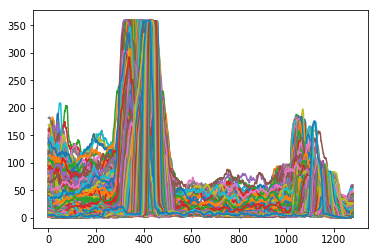

In [144]:
#complete videoclip
clip = VideoFileClip("project_video.mp4")
clip_annotated = clip.fl_image(process_image)
%time clip_annotated.write_videofile("project_video_out_complete.mp4", audio=False)



In [145]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_out_complete.mp4"))